#### Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
%matplotlib inline
import os
import warnings
import glob
warnings.filterwarnings('ignore')

font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams["font.family"] = font_family

#### Data Load

In [137]:
# path = './data/'
# filenames = os.listdir('./data')
data_lst = []

path = os.path.abspath('data')
all_files = glob.glob(path + "\data_*.csv")

for file in all_files:
    var_name = file[41:-4]
    globals()[f'{var_name}'] = pd.read_csv(file, low_memory=False)
    data_lst.append(globals()[f'{var_name}'])

In [138]:
data_0

,Gender,Job,Edu,Health,Earn,Self_conf
0,여성,비경활,초등,그렇지 않은 편,중,중
1,남성,임금_중숙련,초등,그렇지 않은 편,중,중
2,여성,비경활,중등,그렇지 않은 편,중,중
3,남성,임금_중숙련,중등,그렇지 않은 편,중,중
4,남성,비경활,대학교 이상,전혀 지장없음,중,중
...,...,...,...,...,...,...
1073,남성,임금_중숙련,중등,전혀 지장없음,중,중
1074,남성,비경활,중등,그렇지 않은 편,하,중
1075,여성,비경활,중등,전혀 지장없음,중,중
1076,여성,임금_중숙련,중등,그렇지 않은 편,중,중


In [98]:
len(data_lst)

8

In [99]:
def to_int(data):
    data['Gender'] = np.where(data['Gender'] == '남성', 0, 1)
    data['Job']  = np.where(data['Job'] == '비경활', 0,
                    np.where(data['Job'] == '은퇴', 1,
                        np.where(data['Job'] == '부분은퇴', 2,
                            np.where(data['Job'] == '임금_고숙련', 3,
                                np.where(data['Job'] == '임금_중숙련', 4,
                                    np.where(data['Job'] == '임금_저숙련', 5,
                                        np.where(data['Job'] == '자영업', 6, 7)))))))
    data['Edu'] = np.where(data['Edu'] == '초등', 0,
                    np.where(data['Edu'] == '중등', 1,
                        np.where(data['Edu'] == '고등', 2, 3)))
    data['Health'] = np.where(data['Health'] == '활동에 제한 있음', 0,
                        np.where(data['Health'] == '그렇지 않은 편', 1, 2))
    data['Earn'] = np.where(data['Earn'] == '하', 0,
                    np.where(data['Earn'] == '중', 1, 2))
    data['Self_conf'] = np.where(data['Self_conf'] == '하', 0,
                            np.where(data['Self_conf'] == '중', 1, 2))
    return data

## Clustering

In [100]:
from kmodes.kmodes import KModes

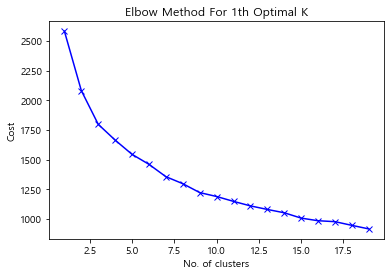

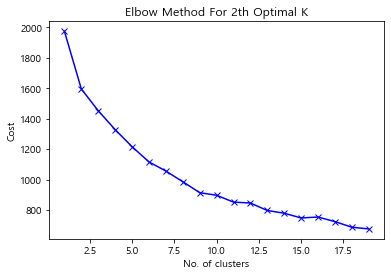

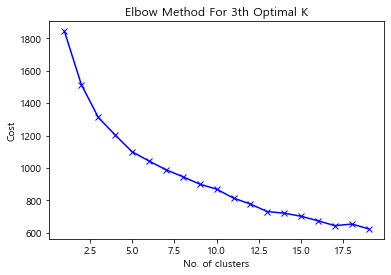

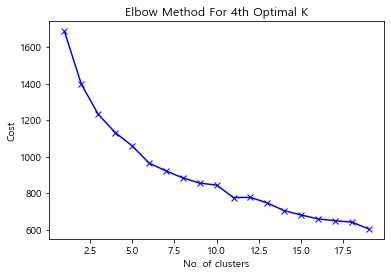

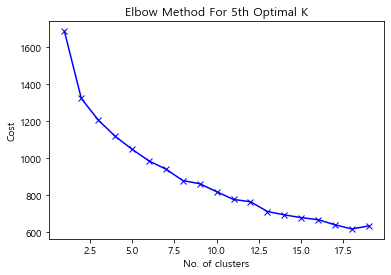

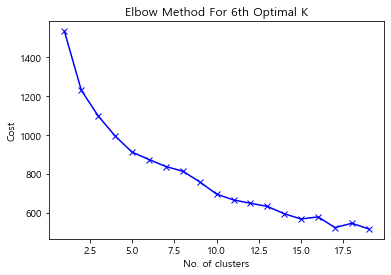

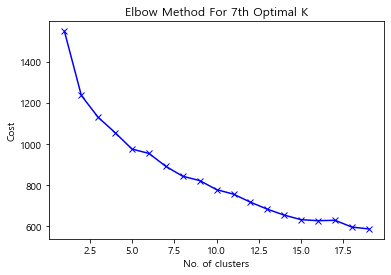

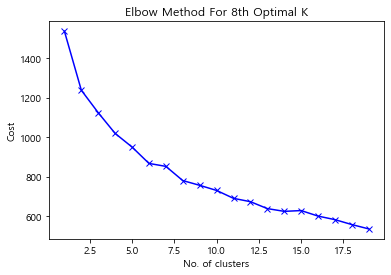

In [101]:
K = range(1, 20)
for idx, df in enumerate(data_lst):
    cost = []
    for num_clusters in list(K):
        kmode = KModes(n_clusters=num_clusters, init = 'random', random_state=2022)
        kmode.fit_predict(df.drop(['Gender'], axis=1))
        cost.append(kmode.cost_)

    plt.plot(K, cost, 'bx-')
    plt.xlabel('No. of clusters')
    plt.ylabel('Cost')
    plt.title(f'Elbow Method For {idx+1}th Optimal K')
    plt.show()

#### Silhouette Score

In [139]:
from sklearn.metrics import silhouette_samples, silhouette_score
kmodes = KModes(n_clusters=6, init='random')
kmodes.fit(data_0.drop(['Gender'], axis=1))

KModes(init='random', n_clusters=6)

In [130]:
kmodes.labels_

array([0, 3, 0, ..., 5, 4, 2], dtype=uint16)

In [131]:
silhouette_score(data_0.drop(['Gender'], axis=1), kmodes.labels_)

-0.07201601910077743

In [105]:
def visualize_silhouette(cluster_lists, X_features): 
    from kmodes.kmodes import KModes
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KModes(n_clusters = n_cluster, max_iter=500, random_state=2022)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

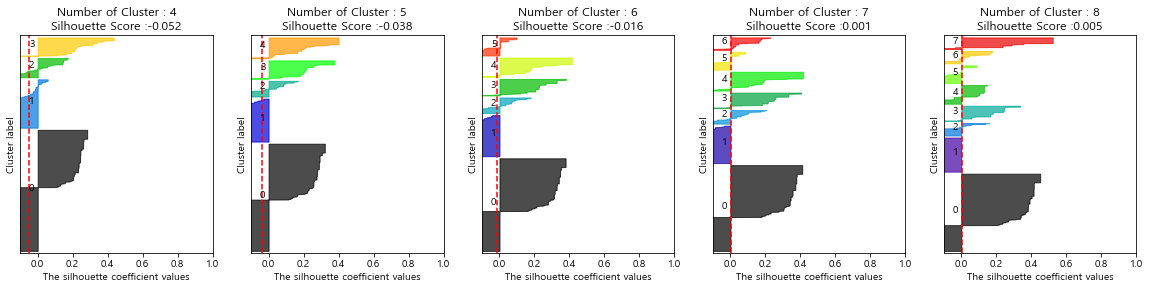

In [132]:
visualize_silhouette([4,5,6,7,8], data_0.drop(['Gender'], axis=1))

In [140]:
for data in data_lst:
    kmode = KModes(n_clusters=6, init='random', random_state=2022)
    kmode.fit(data.drop(['Gender'], axis=1))
    data['Cluster'] = kmode.labels_

In [141]:
for idx, data in enumerate(data_lst):
    data['Year'] = 2006 + (idx*2) 

In [142]:
full_data = pd.concat(data_lst, axis=0)
full_data.reset_index(drop=True)

,Gender,Job,Edu,Health,Earn,Self_conf,Cluster,Year
0,여성,비경활,초등,그렇지 않은 편,중,중,1,2006
1,남성,임금_중숙련,초등,그렇지 않은 편,중,중,4,2006
2,여성,비경활,중등,그렇지 않은 편,중,중,2,2006
3,남성,임금_중숙련,중등,그렇지 않은 편,중,중,4,2006
4,남성,비경활,대학교 이상,전혀 지장없음,중,중,1,2006
...,...,...,...,...,...,...,...,...
6319,남성,임금_중숙련,중등,전혀 지장없음,상,상,4,2020
6320,남성,임금_중숙련,중등,전혀 지장없음,중,중,1,2020
6321,여성,임금_중숙련,중등,전혀 지장없음,중,상,4,2020
6322,여성,임금_중숙련,중등,전혀 지장없음,하,중,0,2020


#### Sequence Analysis

In [143]:
print('Len of Datas')
for idx, data in enumerate(data_lst):
    print(f'len of {idx}th data:', len(data))

Len of Datas
len of 0th data: 1078
len of 1th data: 882
len of 2th data: 804
len of 3th data: 763
len of 4th data: 733
len of 5th data: 697
len of 6th data: 690
len of 7th data: 677


In [144]:
Static = data_7.drop(['Cluster', 'Year'], axis=1)
Static.Gender.value_counts(normalize=True)

여성    0.612999
남성    0.387001
Name: Gender, dtype: float64

In [145]:
Male = Static[Static['Gender']=='남성']
Female = Static[Static['Gender']=='여성']

In [146]:
print('Total: \n', Static.Job.value_counts(normalize=True))
print('Male: \n',Male.Job.value_counts(normalize=True))
print('Female: \n', Female.Job.value_counts(normalize=True))

Total: 
 비경활        0.366322
임금_저숙련     0.302806
임금_중숙련     0.230428
임금_고숙련     0.087149
은퇴         0.010340
자영업        0.001477
무급가족종사자    0.001477
Name: Job, dtype: float64
Male: 
 임금_중숙련     0.389313
임금_저숙련     0.248092
비경활        0.179389
임금_고숙련     0.167939
은퇴         0.007634
무급가족종사자    0.003817
자영업        0.003817
Name: Job, dtype: float64
Female: 
 비경활       0.484337
임금_저숙련    0.337349
임금_중숙련    0.130120
임금_고숙련    0.036145
은퇴        0.012048
Name: Job, dtype: float64


In [147]:
print('Total: \n', Static.Edu.value_counts(normalize=True))
print('Male: \n',Male.Edu.value_counts(normalize=True))
print('Female: \n', Female.Edu.value_counts(normalize=True))

Total: 
 중등        0.527326
초등        0.196455
고등        0.177253
대학교 이상    0.098966
Name: Edu, dtype: float64
Male: 
 중등        0.488550
초등        0.309160
고등        0.125954
대학교 이상    0.076336
Name: Edu, dtype: float64
Female: 
 중등        0.551807
고등        0.209639
초등        0.125301
대학교 이상    0.113253
Name: Edu, dtype: float64


In [148]:
print('Total: \n', Static.Health.value_counts(normalize=True))
print('Male: \n',Male.Health.value_counts(normalize=True))
print('Female: \n', Female.Health.value_counts(normalize=True))

Total: 
 전혀 지장없음      0.536189
그렇지 않은 편     0.454948
활동에 제한 있음    0.008863
Name: Health, dtype: float64
Male: 
 전혀 지장없음      0.515267
그렇지 않은 편     0.465649
활동에 제한 있음    0.019084
Name: Health, dtype: float64
Female: 
 전혀 지장없음      0.549398
그렇지 않은 편     0.448193
활동에 제한 있음    0.002410
Name: Health, dtype: float64


In [149]:
print('Total: \n', Static.Earn.value_counts(normalize=True))
print('Male: \n',Male.Earn.value_counts(normalize=True))
print('Female: \n', Female.Earn.value_counts(normalize=True))

Total: 
 중    0.562777
상    0.218612
하    0.218612
Name: Earn, dtype: float64
Male: 
 중    0.564885
상    0.312977
하    0.122137
Name: Earn, dtype: float64
Female: 
 중    0.561446
하    0.279518
상    0.159036
Name: Earn, dtype: float64


In [150]:
print('Total: \n', Static.Self_conf.value_counts(normalize=True))
print('Male: \n',Male.Self_conf.value_counts(normalize=True))
print('Female: \n', Female.Self_conf.value_counts(normalize=True))

Total: 
 중    0.735598
상    0.257016
하    0.007386
Name: Self_conf, dtype: float64
Male: 
 중    0.778626
상    0.213740
하    0.007634
Name: Self_conf, dtype: float64
Female: 
 중    0.708434
상    0.284337
하    0.007229
Name: Self_conf, dtype: float64


#### For Pre New Elder

In [151]:
pre = pd.read_csv('./data/Lt08.csv')
pre

,pid,hhid,HHID20,CID20,ed,w08wgt_c,w08wgt_p,w01,w02,w03,...,w08G014,w08G026,w08G027,w08G028,w08G029,w08G030,w08G031,w08G032,w08Ba001,w08Ba002
0,11,1,10000000,11,833,1600.303883,2189.837105,1,1.0,1.0,...,NaN,80,60,NaN,60.0,70,4,20,1.0,NaN
1,21,2,20000000,21,833,3180.749884,3919.849664,1,1.0,1.0,...,NaN,50,40,60.0,50.0,30,5,10,1.0,NaN
2,22,2,20000000,21,833,4525.161503,5994.598161,1,1.0,1.0,...,NaN,60,50,60.0,NaN,60,4,20,1.0,NaN
3,41,4,40000000,41,833,1239.297401,1695.840060,1,1.0,1.0,...,NaN,70,60,60.0,70.0,60,5,10,1.0,NaN
4,42,4,40000000,41,833,1069.049862,1207.745056,1,1.0,1.0,...,NaN,60,60,70.0,NaN,60,6,5,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5712,61671,6167,61670000000,61671,672,1962.325562,2019.482662,1,1.0,1.0,...,NaN,30,30,NaN,80.0,50,5,5,1.0,NaN
5713,61681,6168,61680000000,61681,672,1439.828558,1481.766769,1,1.0,1.0,...,NaN,20,30,NaN,50.0,50,6,2,1.0,NaN
5714,61691,6169,61690000000,61691,672,1440.165656,1482.113687,1,1.0,1.0,...,NaN,50,50,NaN,80.0,50,5,2,1.0,NaN
5715,61701,6170,61700000000,61701,672,822.192069,1432.032181,1,1.0,1.0,...,NaN,50,50,NaN,80.0,80,4,5,1.0,NaN


In [152]:
def new_preprocessing(data, period):
    # data = data[(data[f'w{period}A002_age'] >= 60) & (data[f'w{period}A002_age'] < 65)]
    data = data[data[f'w{period}A002y'] < 1959]
    data['Gender'] = np.where(data[f'w{period}gender1'] == 1, '남성', '여성')
    
    data['Job'] = np.where(data[f'w{period}present_ecotype'] == 3, '비경활',
                           np.where(data[f'w{period}retired'].isin([1.0, 2.0]), '은퇴',
                                np.where(data[f'w{period}job'].isin([1.0, 2.0]), '임금_고숙련',
                                        np.where(data[f'w{period}job'].isin([3.0, 6.0, 7.0, 8.0, -9.0]), '임금_중숙련',
                                                np.where(data[f'w{period}job'].isin([4.0, 5.0, 9.0]), '임금_저숙련',
                                                        np.where(data[f'w{period}emp'] == 2.0, '자영업', '무급가족종사자'))))))
    data['Edu'] = np.where(data[f'w{period}edu'] == 1, '대학교 이상',
                           np.where(data[f'w{period}edu'] == 2, '고등',
                                   np.where(data[f'w{period}edu'] == 3, '중등', '초등')))
    data['Health_Score'] = data[f'w{period}adl'] + data[f'w{period}iadl'] + data[f'w{period}C001'] + data[f'w{period}C005']

    data['Health'] = np.where(data['Health_Score'] < 7, '전혀 지장없음',
                              np.where(data['Health_Score']>10,'활동에 제한 있음', '그렇지 않은 편'))
    
    data['Earn_Score'] = data[f'w{period}pnetassets'] + data[f'w{period}pinc']

    data['Earn'] = np.where(data['Earn_Score'] > data['Earn_Score'].describe()['75%'], '상',
                            np.where(data['Earn_Score'] < data['Earn_Score'].describe()['25%'], '하', '중'))
    
    data['Self_conf_Score'] = data[f'w{period}G026'] + data[f'w{period}G027'] + data[f'w{period}G028'] + data[f'w{period}G029'] + data[f'w{period}G030']

    data['Self_conf'] = np.where(data['Self_conf_Score'] > 350, '상',
                                 np.where(data['Self_conf_Score'] < 200, '하', '중'))
    
    data = data[['Gender','Job', 'Edu', 'Health', 'Earn', 'Self_conf']]
    data.reset_index(drop=True, inplace=True)
    return data

In [153]:
pre = new_preprocessing(pre, '08')

In [154]:
print('직업지위: \n', pre.Job.value_counts(normalize=True))
print('학력수준: \n', pre.Edu.value_counts(normalize=True))
print('활동제한 수준: \n', pre.Health.value_counts(normalize=True))
print('소득: \n', pre.Earn.value_counts(normalize=True))
print('자아: \n', pre.Self_conf.value_counts(normalize=True))

직업지위: 
 비경활        0.735714
임금_저숙련     0.132937
임금_중숙련     0.107341
임금_고숙련     0.019841
은퇴         0.003571
무급가족종사자    0.000397
자영업        0.000198
Name: Job, dtype: float64
학력수준: 
 대학교 이상    0.460714
중등        0.269246
고등        0.176786
초등        0.093254
Name: Edu, dtype: float64
활동제한 수준: 
 그렇지 않은 편     0.506349
전혀 지장없음      0.414286
활동에 제한 있음    0.079365
Name: Health, dtype: float64
소득: 
 중    0.580159
상    0.209921
하    0.209921
Name: Earn, dtype: float64
자아: 
 중    0.871627
상    0.112897
하    0.015476
Name: Self_conf, dtype: float64


#### Visualization

In [155]:
for idx, data in enumerate(data_lst):
    data.drop(['Year'], axis=1)
    for cluster in range(0, 6):
        temp = data[data['Cluster'] == cluster]
        print('Data Number: ', idx)
        print('Cluster Number: ', cluster)
        print('Distribution of Jobs: \n', temp.Job.value_counts(normalize=True))
        print('Distribution of Edus: \n', temp.Edu.value_counts(normalize=True))
        print('Distribution of Earns: \n', temp.Earn.value_counts(normalize=True))
        print('Distribution of Healthes: \n', temp.Health.value_counts(normalize=True))
        print('Distribution of Selfs: \n', temp.Self_conf.value_counts(normalize=True))

Data Number:  0
Cluster Number:  0
Distribution of Jobs: 
 임금_중숙련     0.373665
임금_저숙련     0.270463
무급가족종사자    0.124555
임금_고숙련     0.106762
비경활        0.099644
자영업        0.024911
Name: Job, dtype: float64
Distribution of Edus: 
 초등        0.505338
중등        0.313167
고등        0.103203
대학교 이상    0.078292
Name: Edu, dtype: float64
Distribution of Earns: 
 중    0.647687
상    0.188612
하    0.163701
Name: Earn, dtype: float64
Distribution of Healthes: 
 전혀 지장없음     0.886121
그렇지 않은 편    0.113879
Name: Health, dtype: float64
Distribution of Selfs: 
 상    0.800712
중    0.185053
하    0.014235
Name: Self_conf, dtype: float64
Data Number:  0
Cluster Number:  1
Distribution of Jobs: 
 비경활        0.571429
임금_저숙련     0.267081
임금_중숙련     0.124224
무급가족종사자    0.037267
Name: Job, dtype: float64
Distribution of Edus: 
 고등        0.664596
대학교 이상    0.167702
초등        0.167702
Name: Edu, dtype: float64
Distribution of Earns: 
 중    0.782609
하    0.180124
상    0.037267
Name: Earn, dtype: float64
Distributio

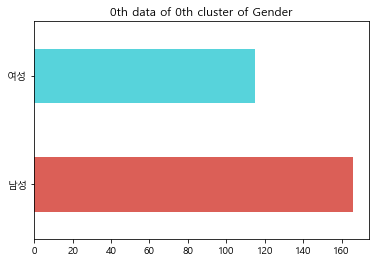

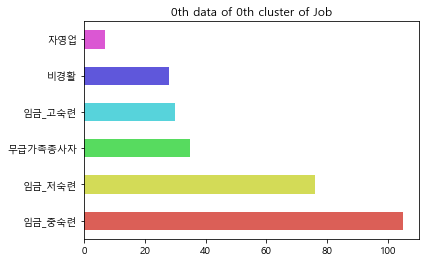

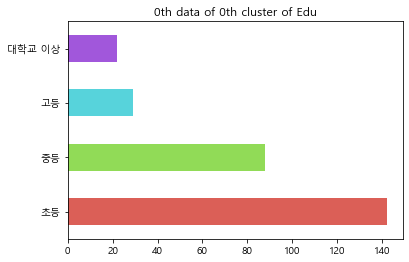

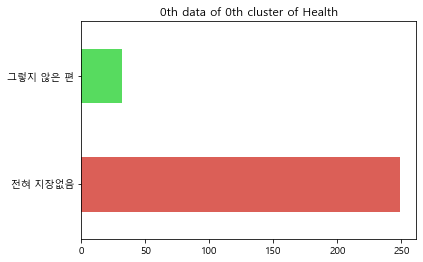

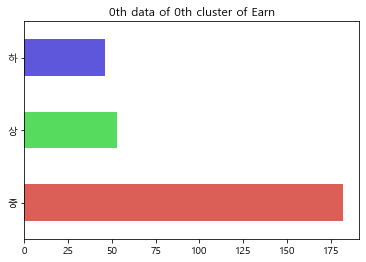

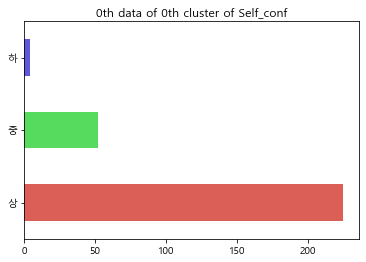

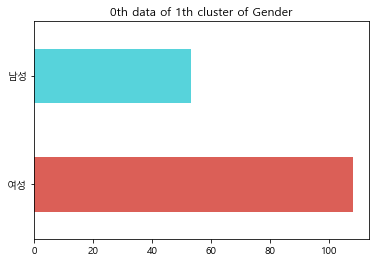

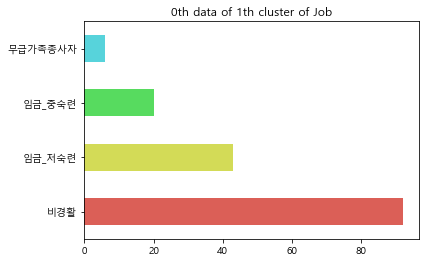

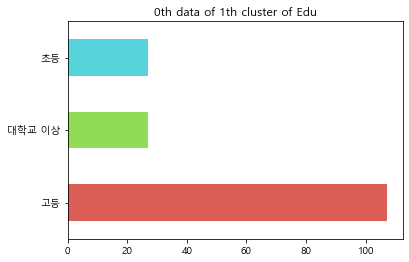

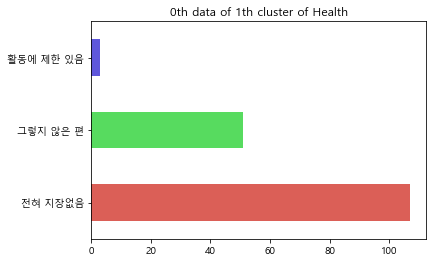

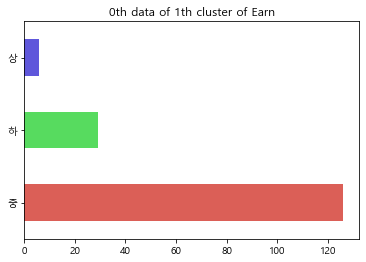

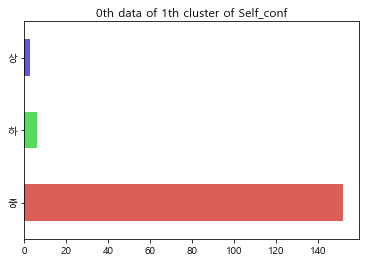

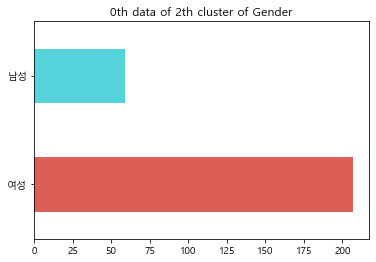

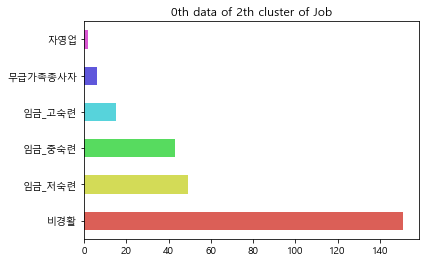

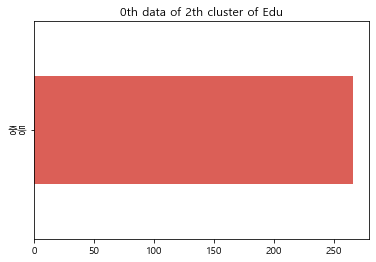

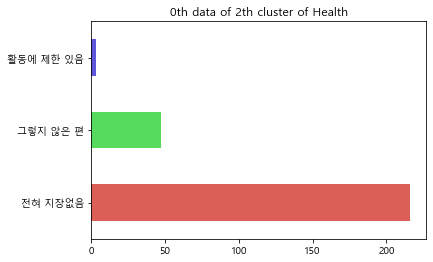

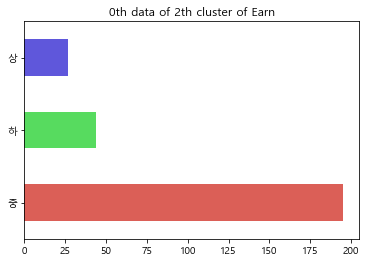

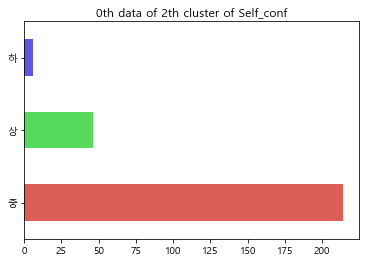

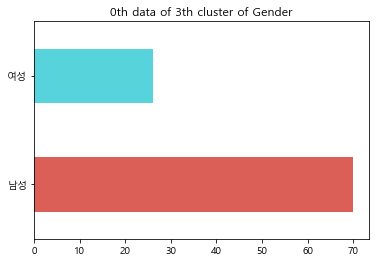

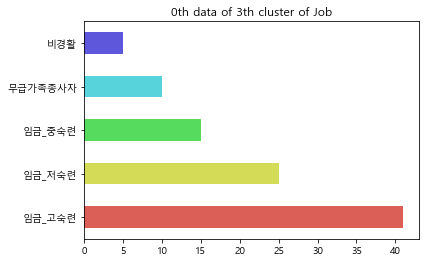

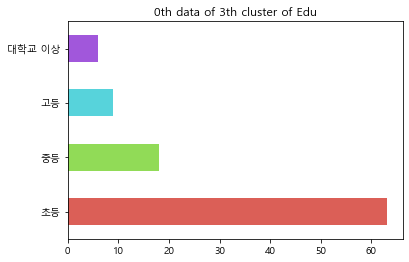

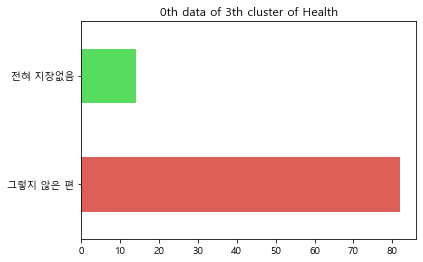

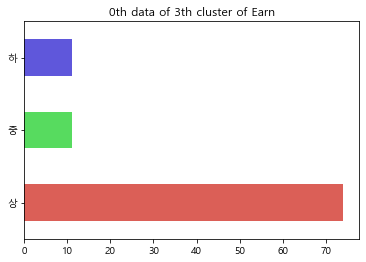

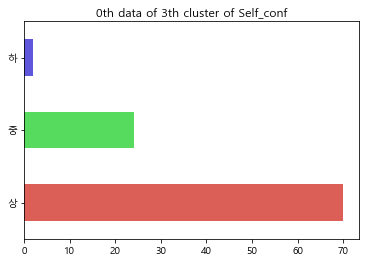

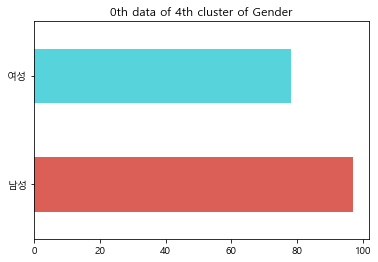

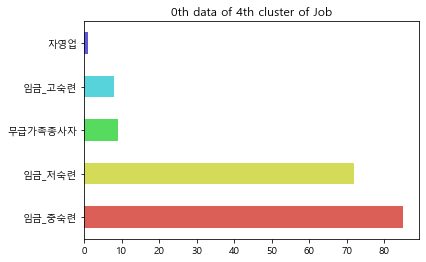

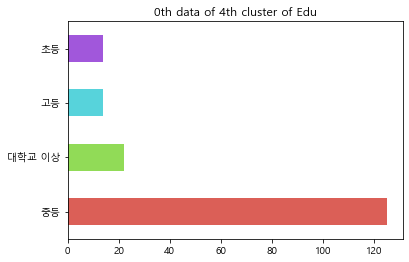

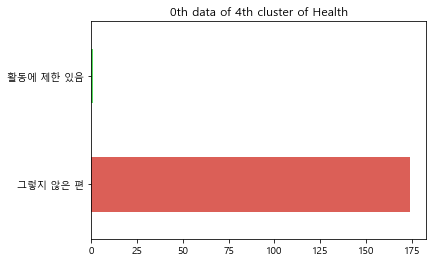

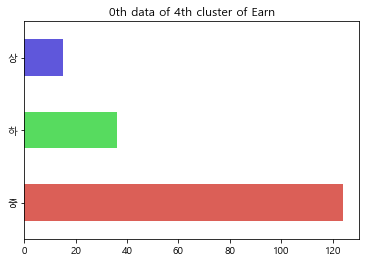

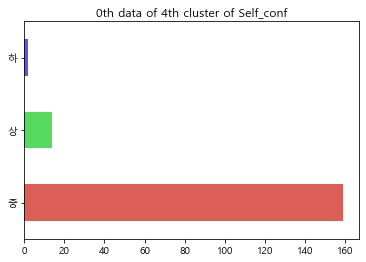

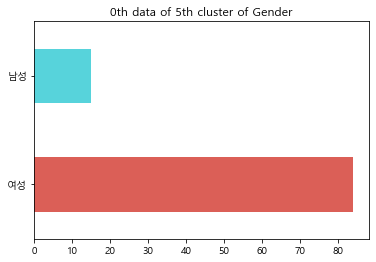

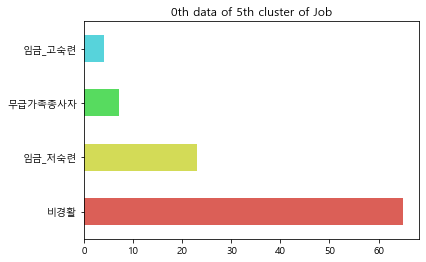

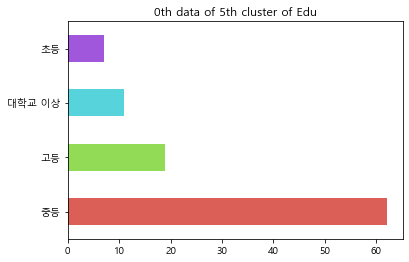

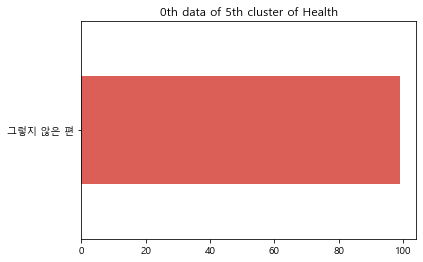

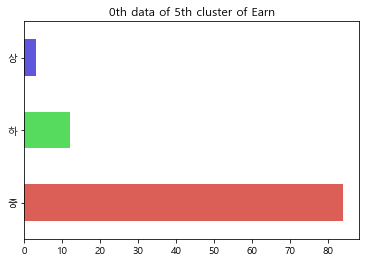

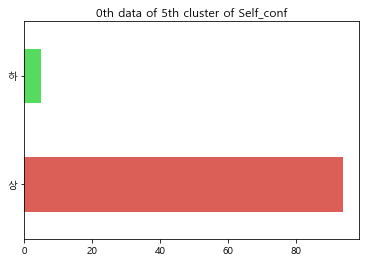

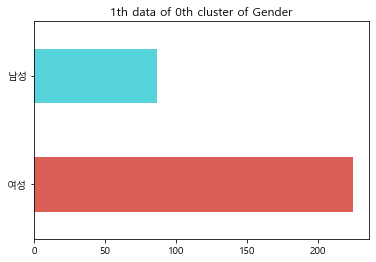

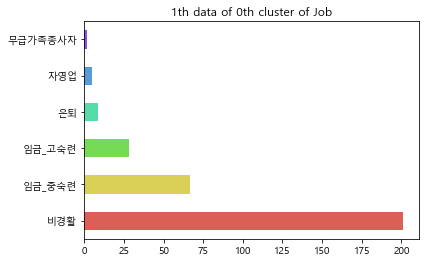

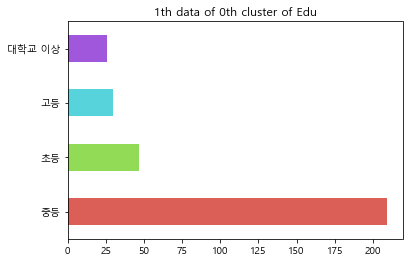

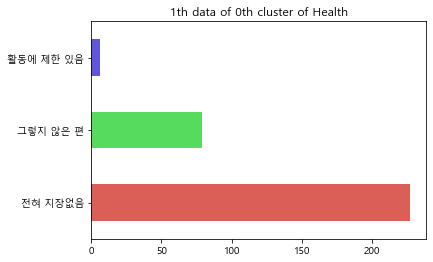

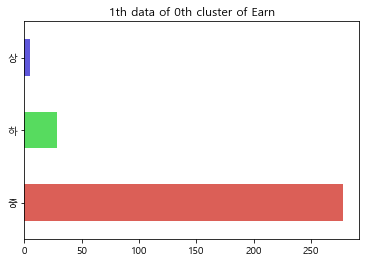

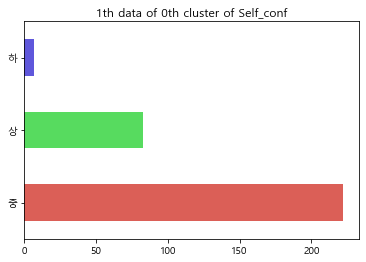

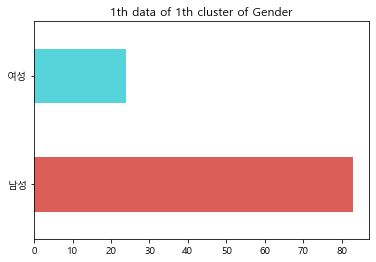

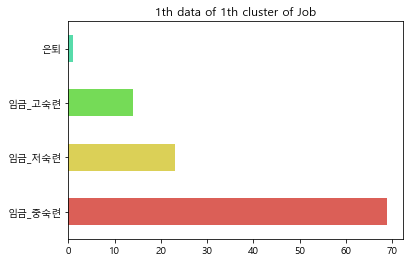

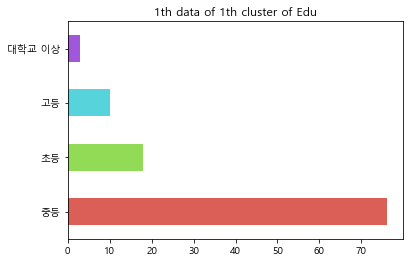

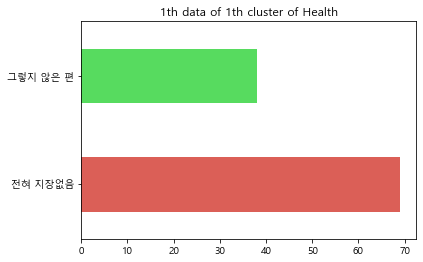

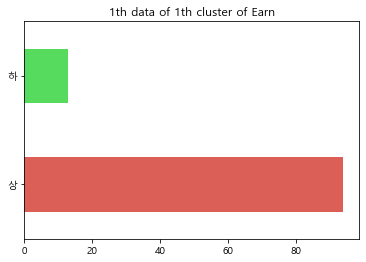

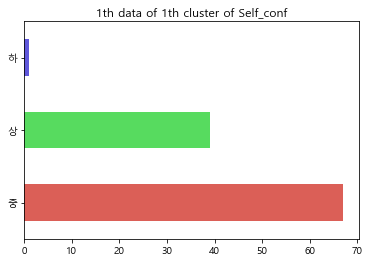

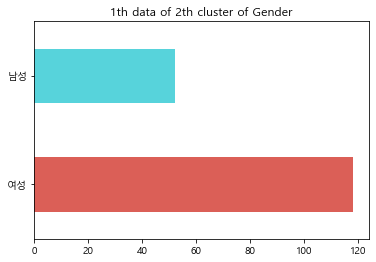

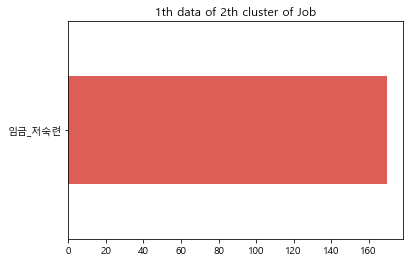

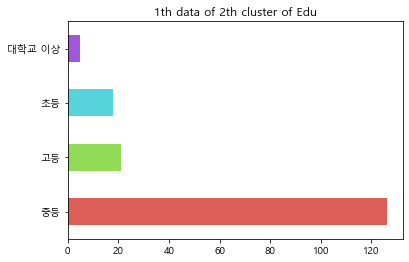

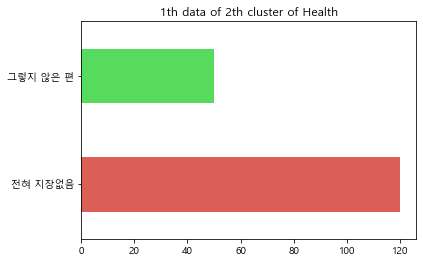

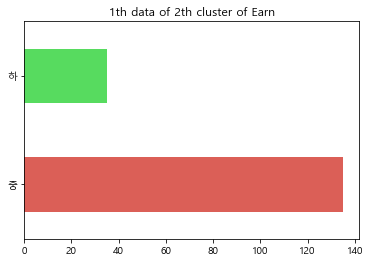

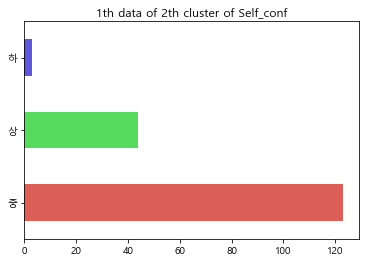

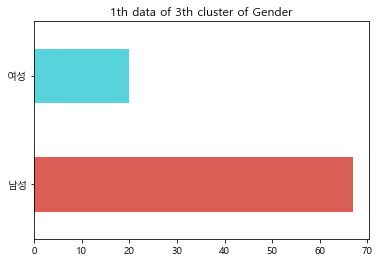

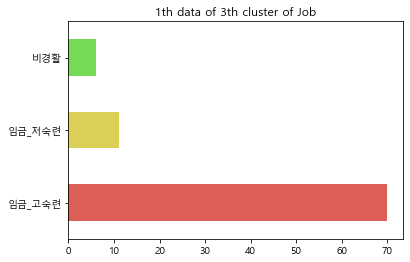

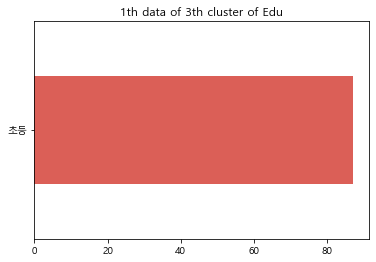

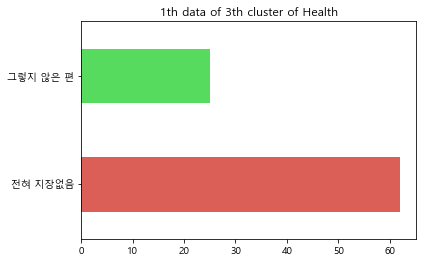

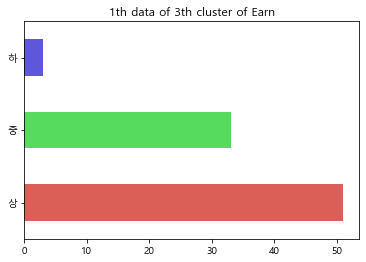

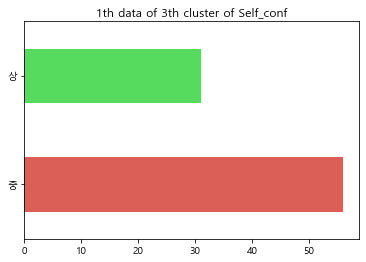

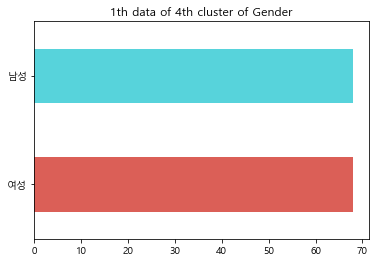

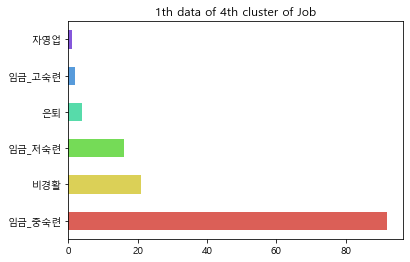

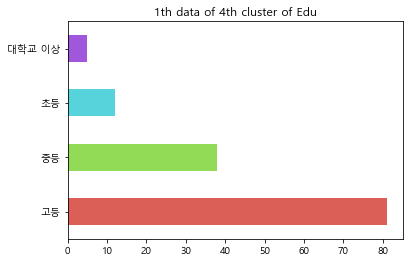

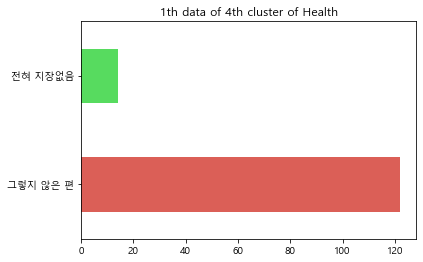

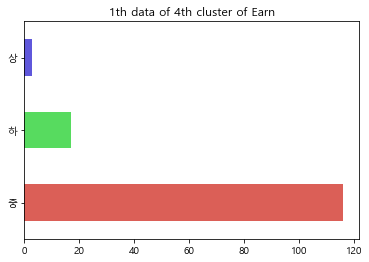

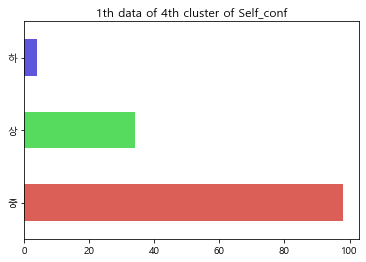

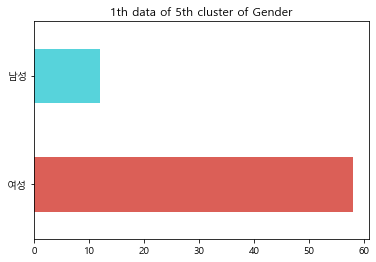

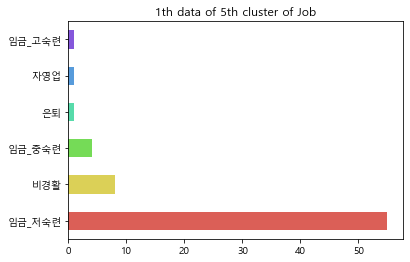

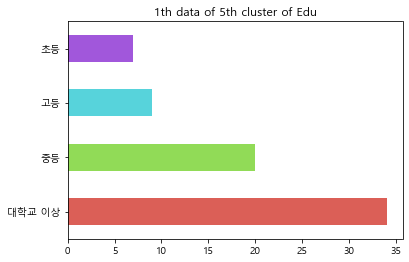

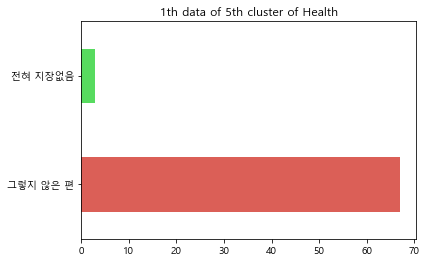

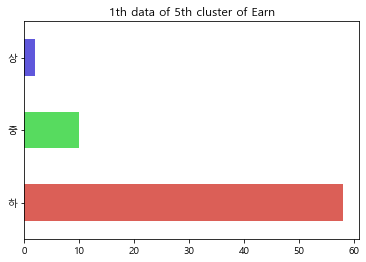

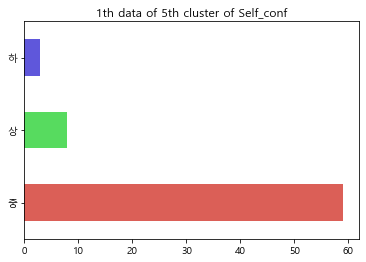

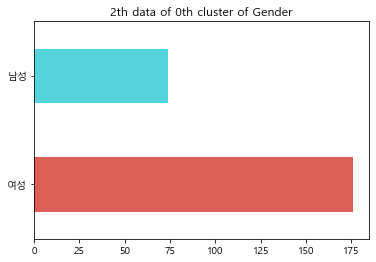

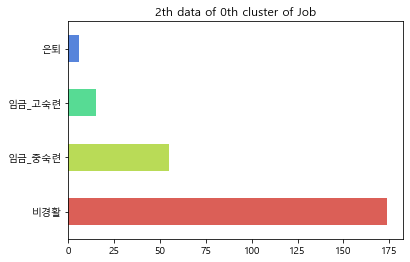

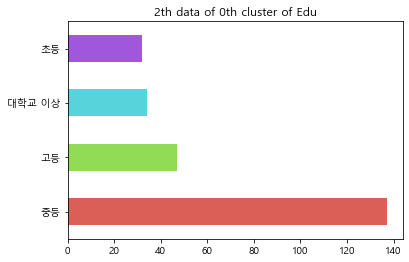

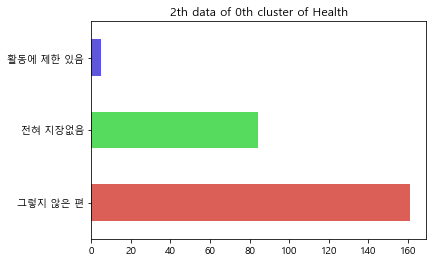

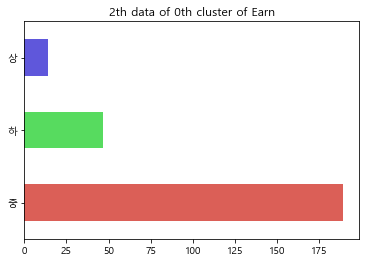

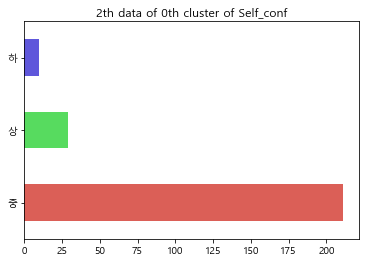

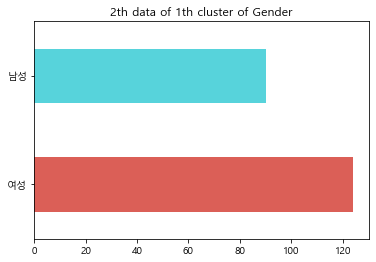

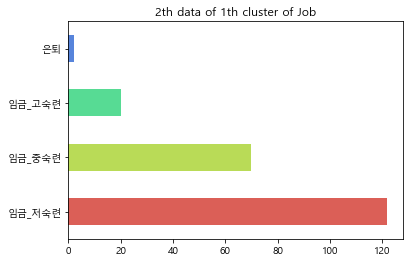

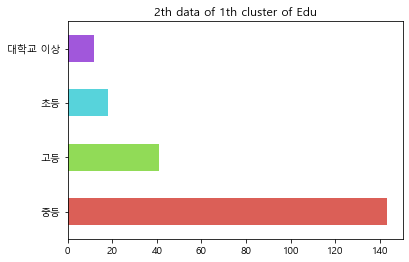

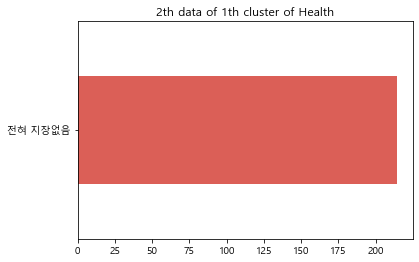

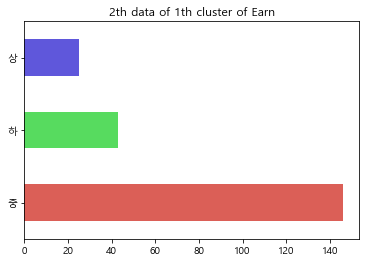

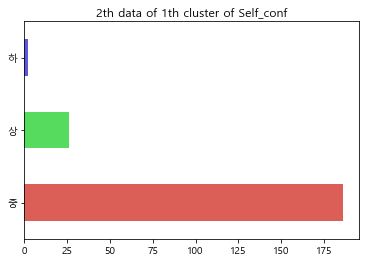

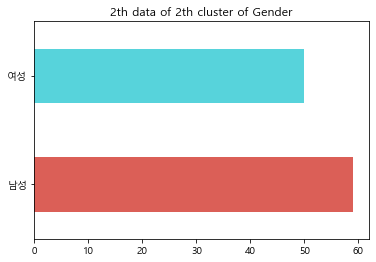

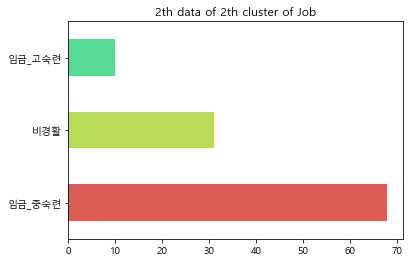

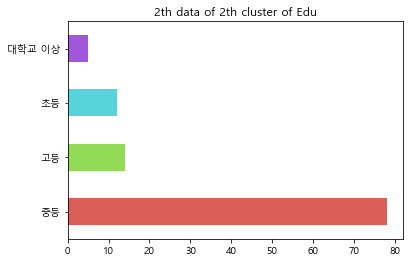

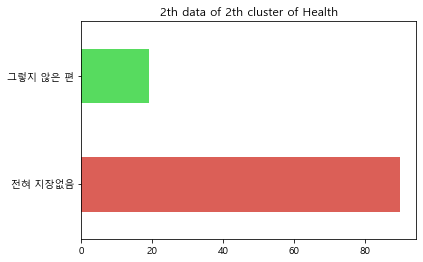

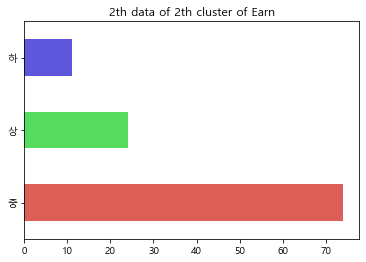

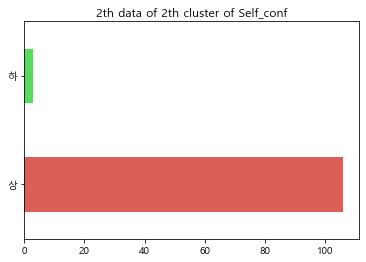

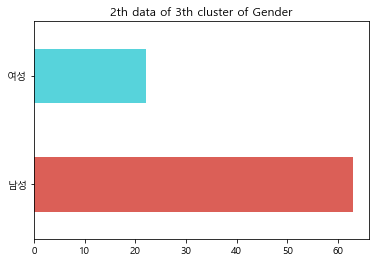

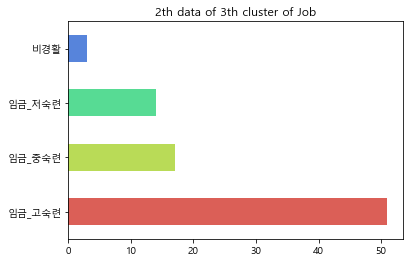

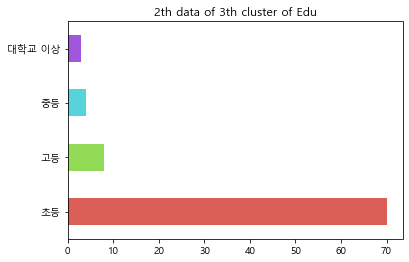

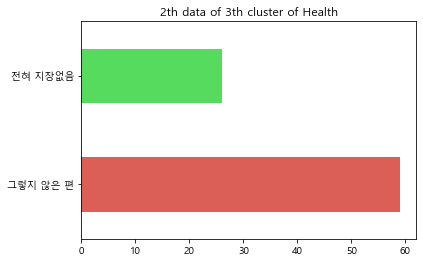

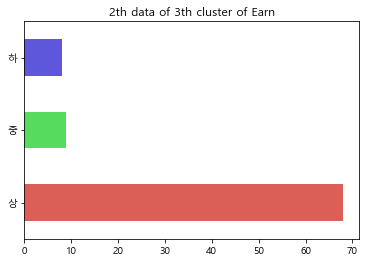

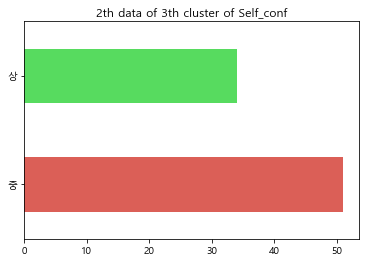

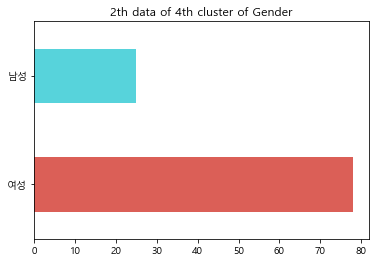

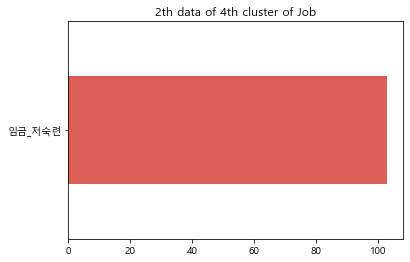

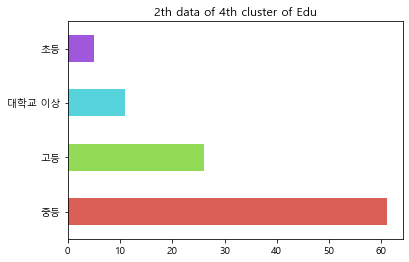

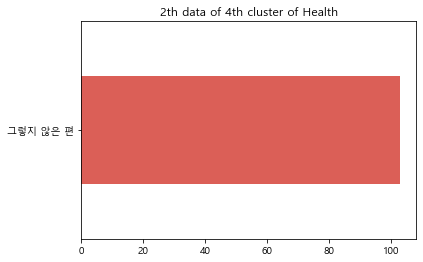

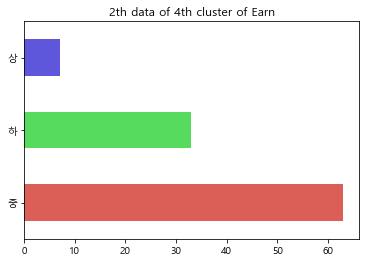

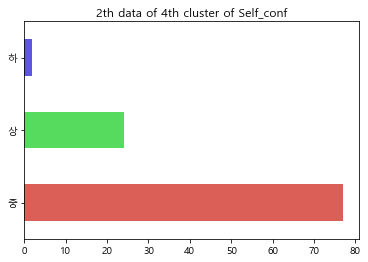

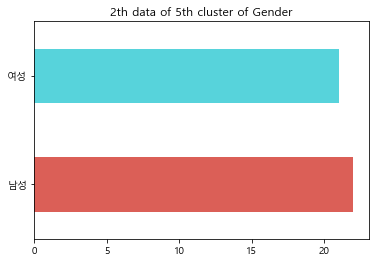

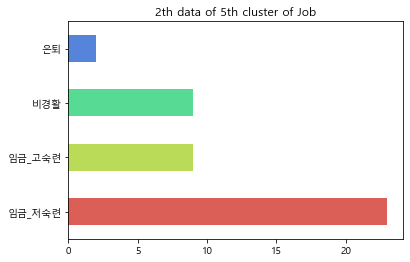

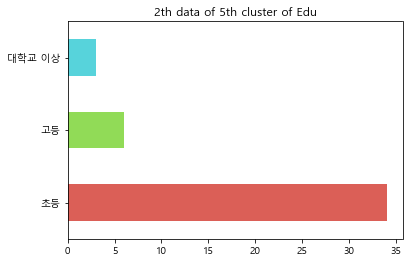

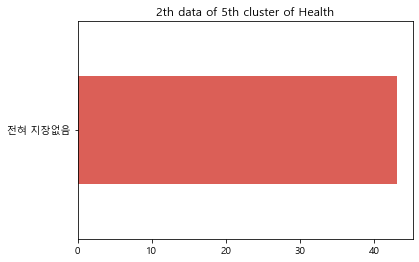

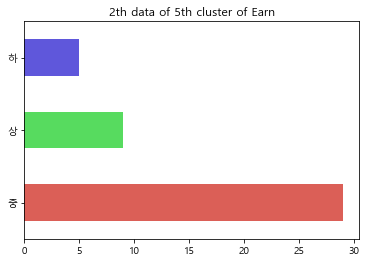

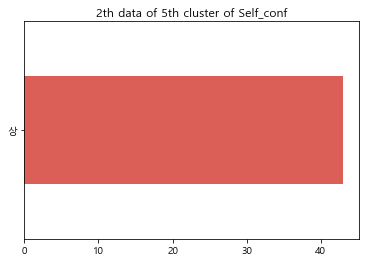

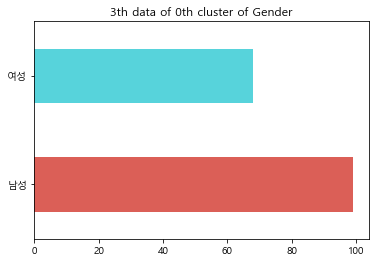

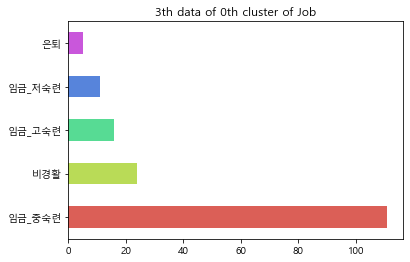

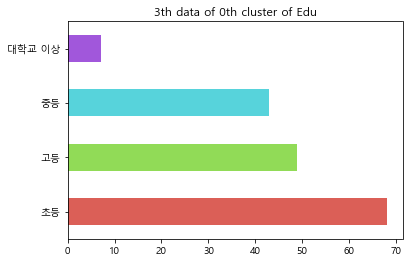

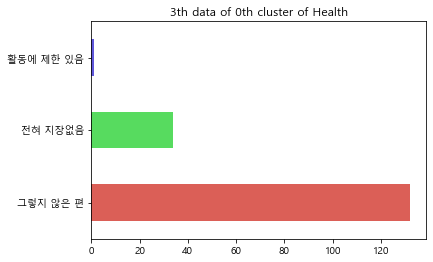

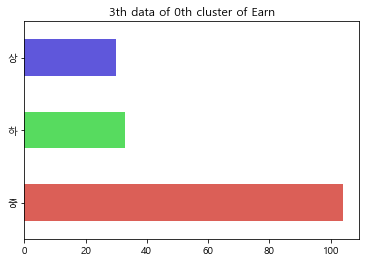

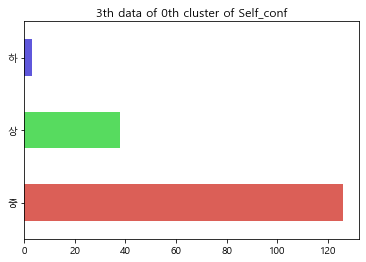

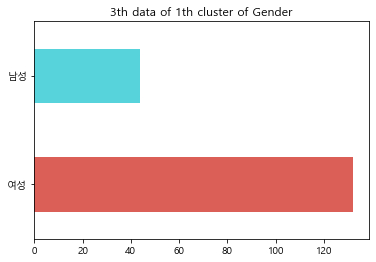

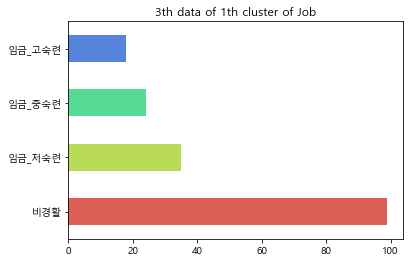

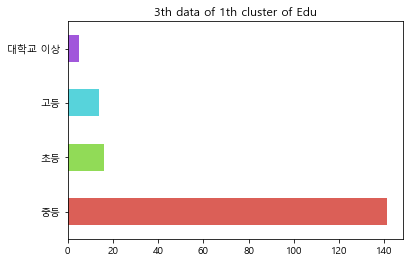

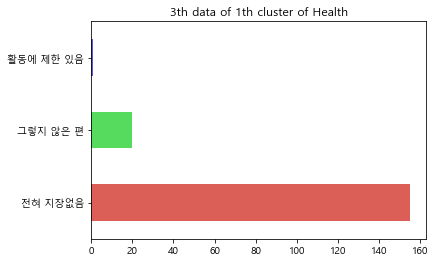

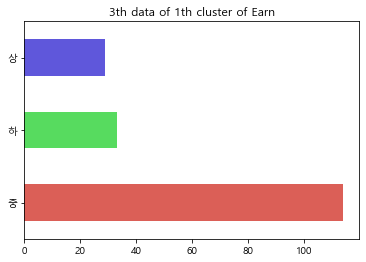

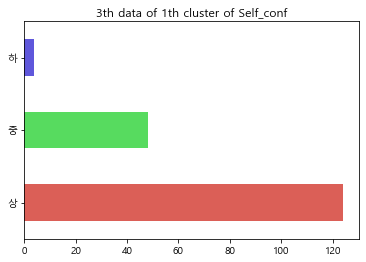

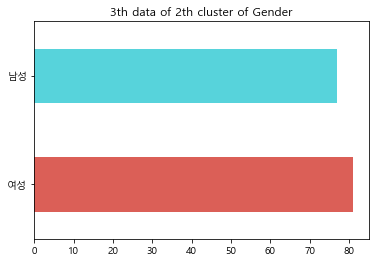

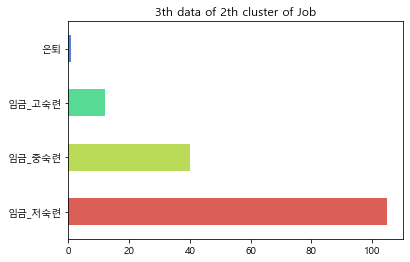

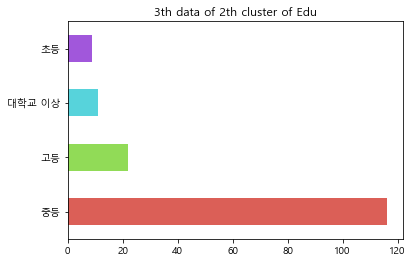

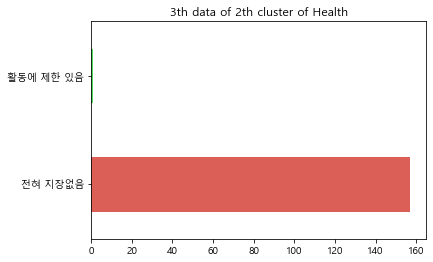

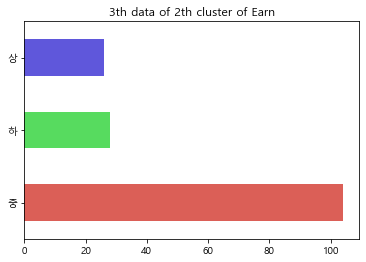

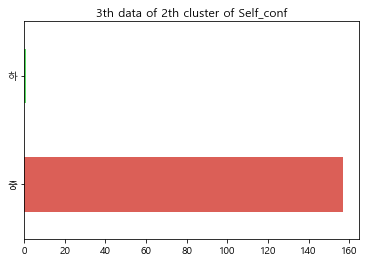

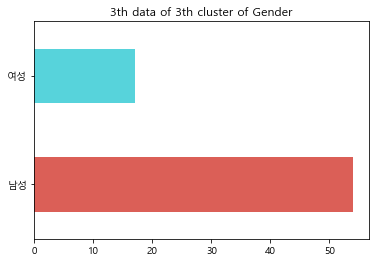

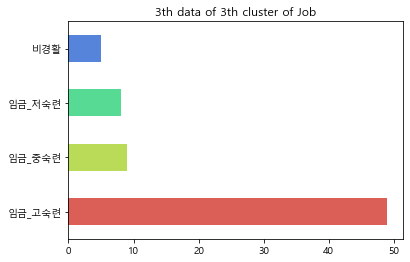

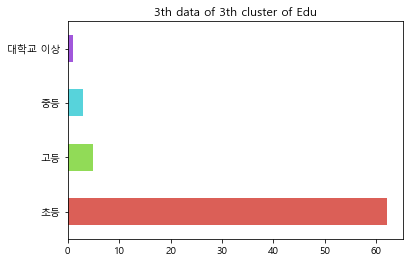

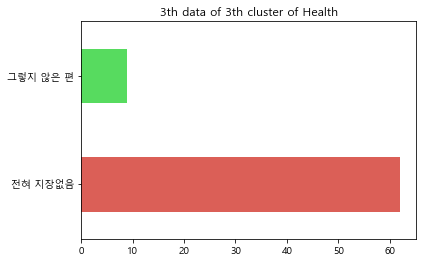

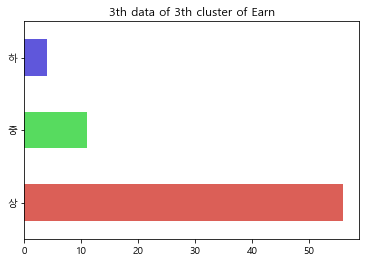

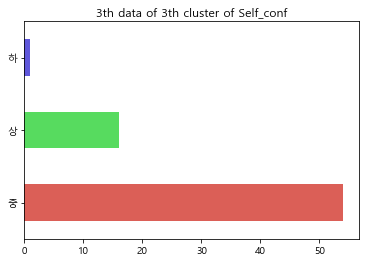

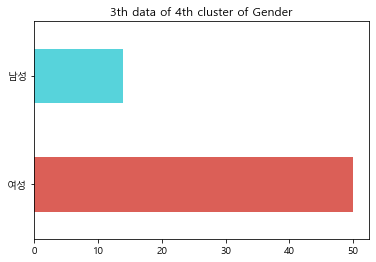

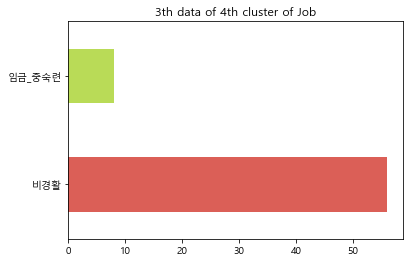

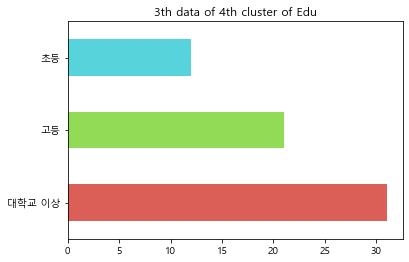

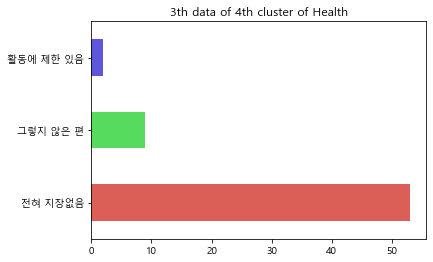

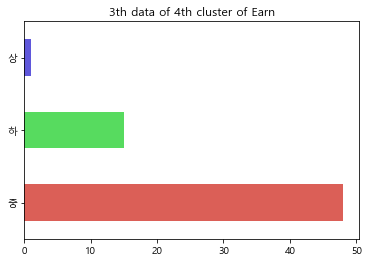

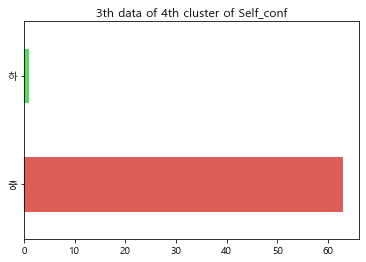

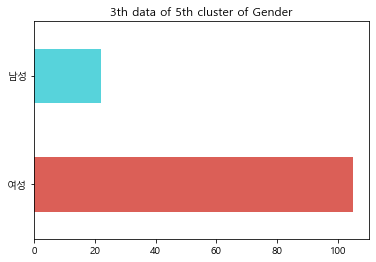

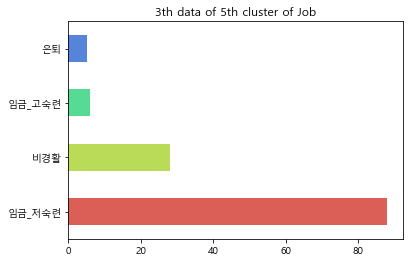

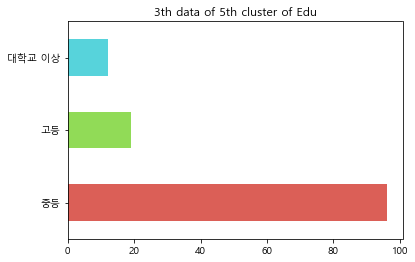

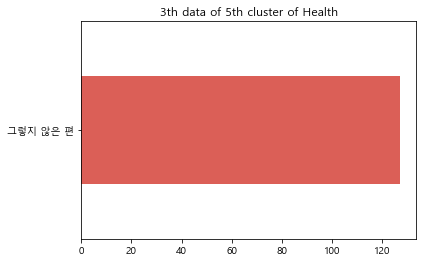

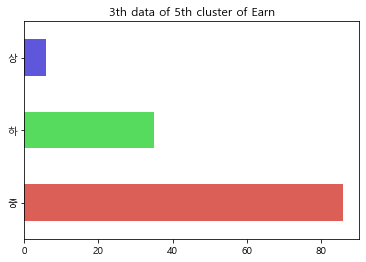

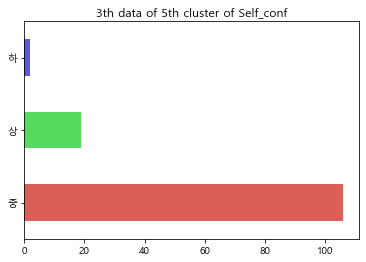

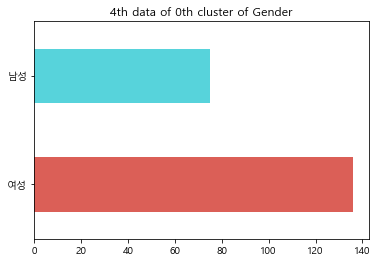

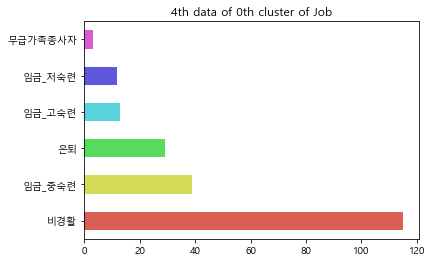

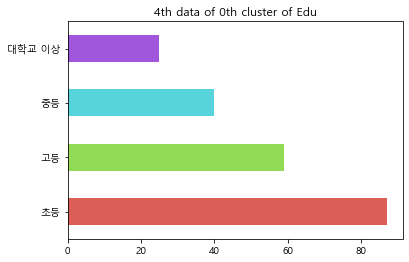

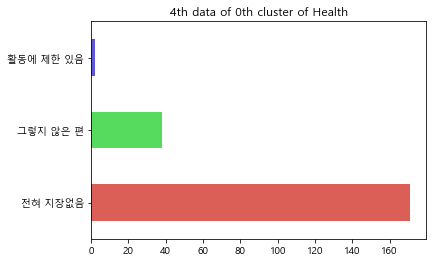

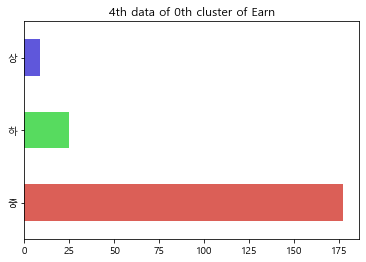

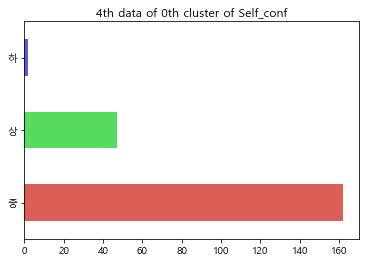

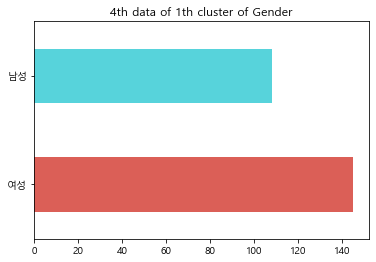

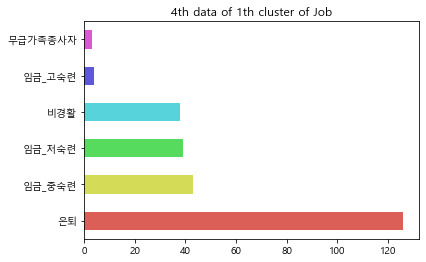

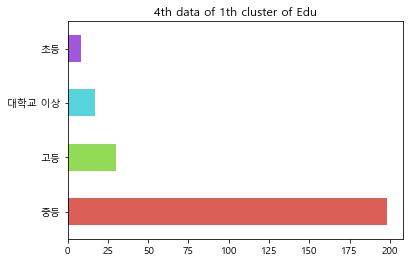

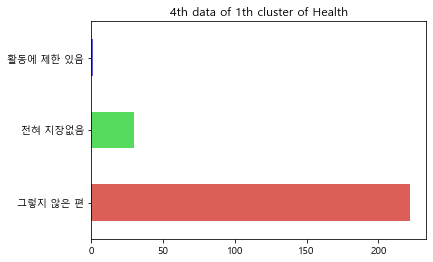

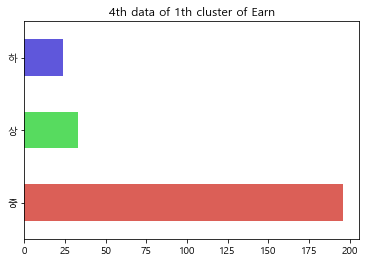

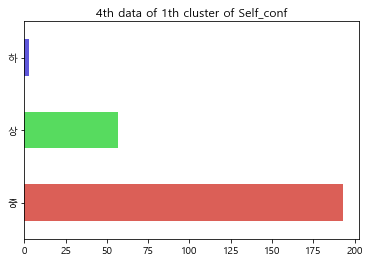

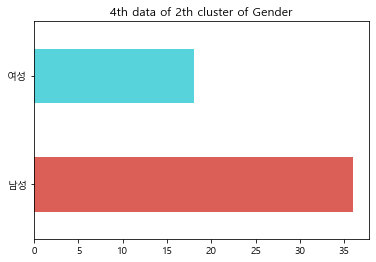

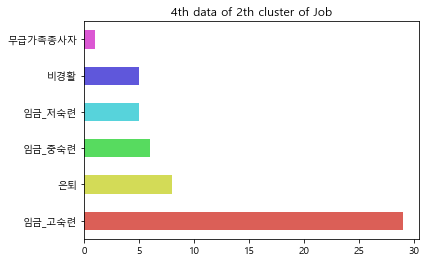

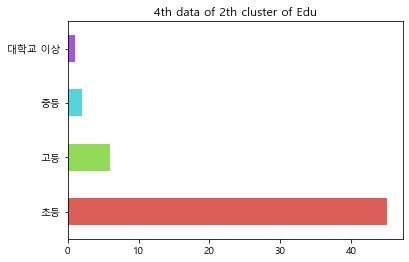

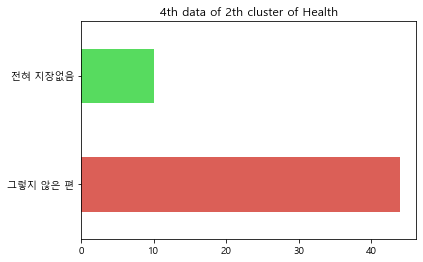

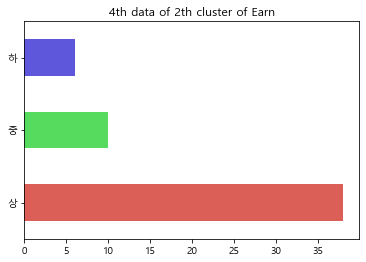

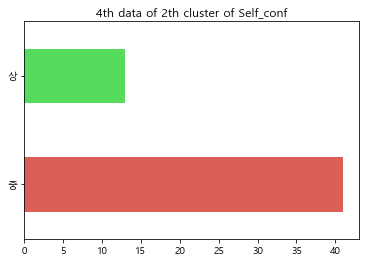

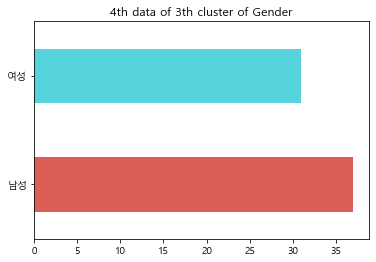

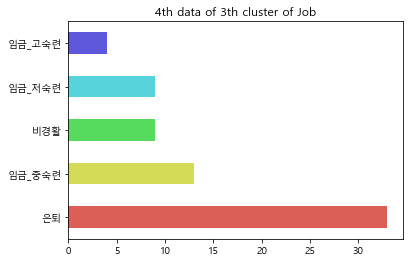

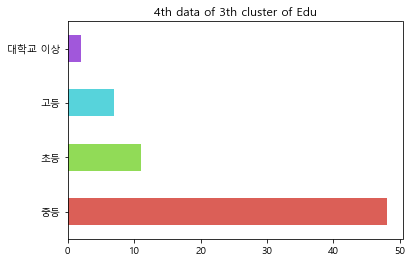

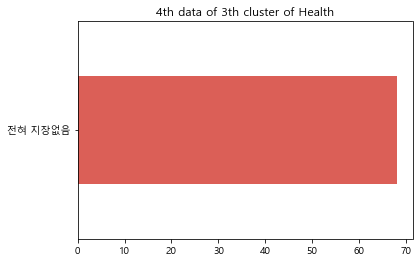

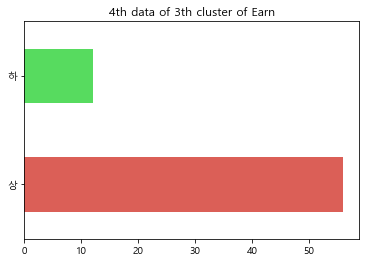

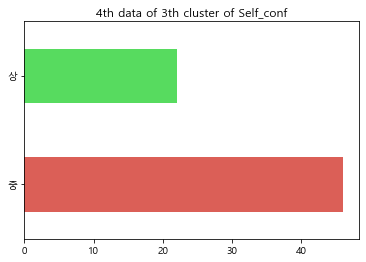

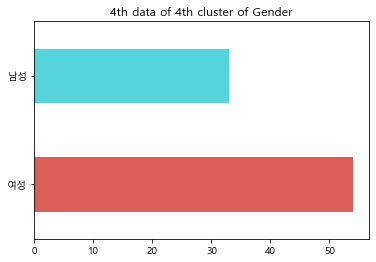

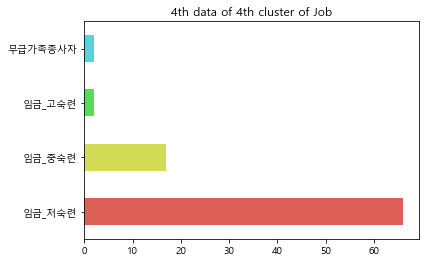

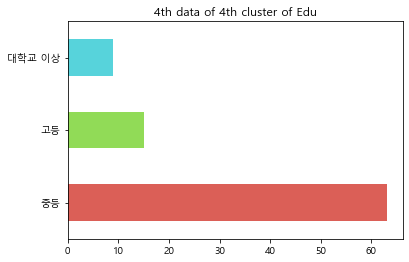

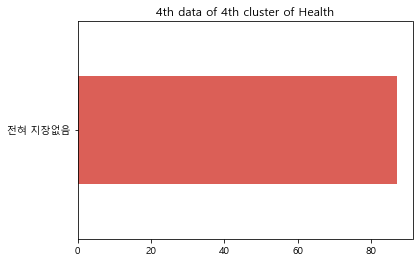

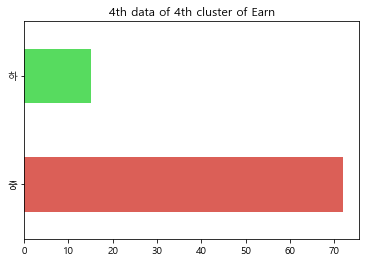

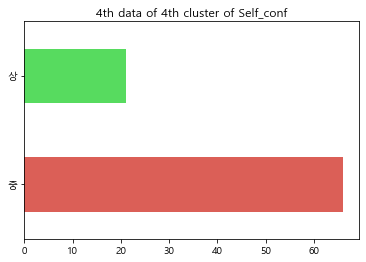

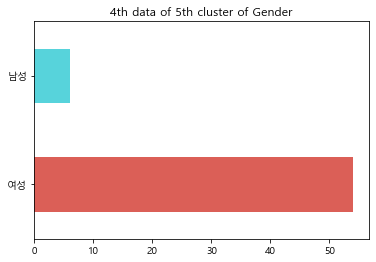

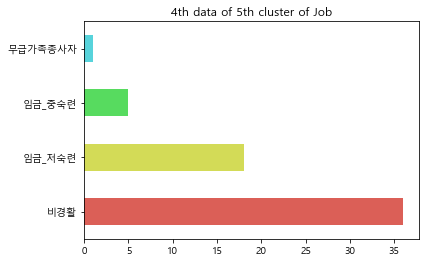

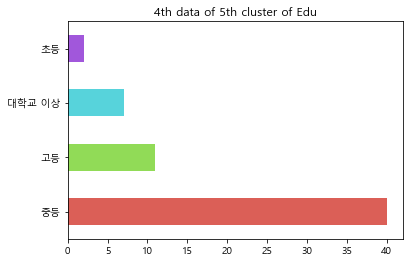

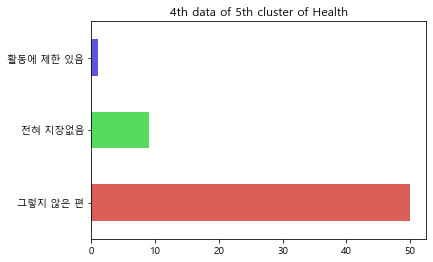

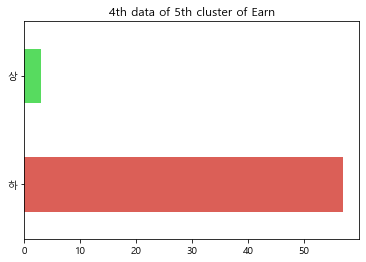

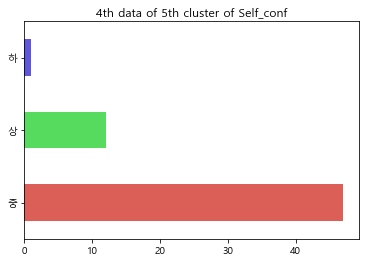

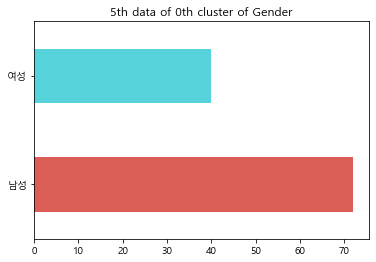

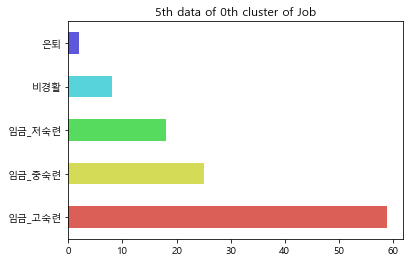

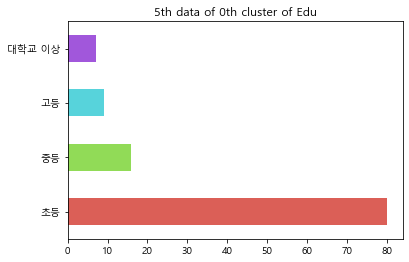

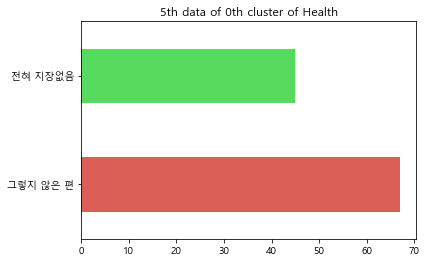

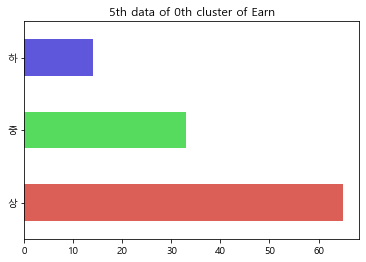

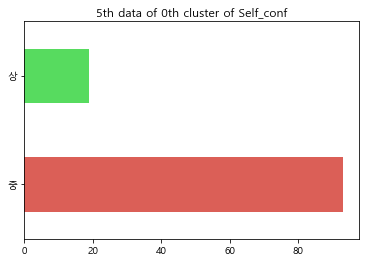

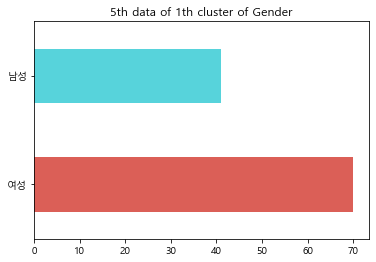

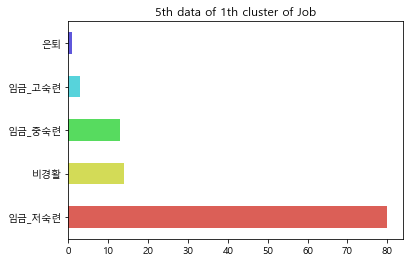

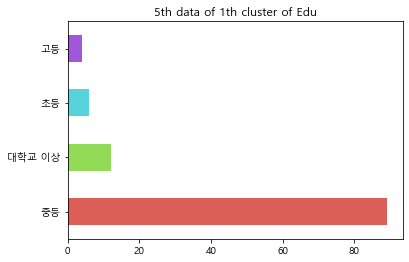

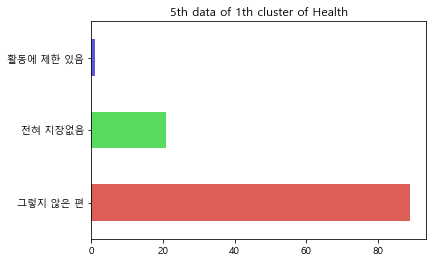

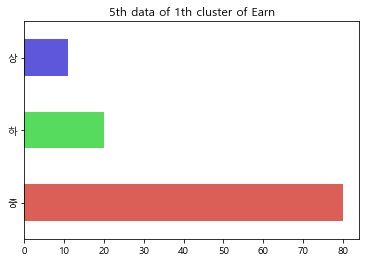

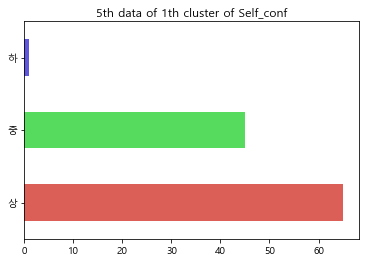

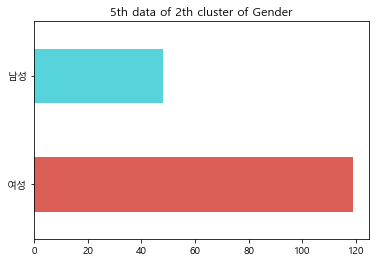

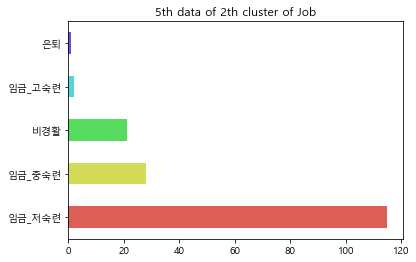

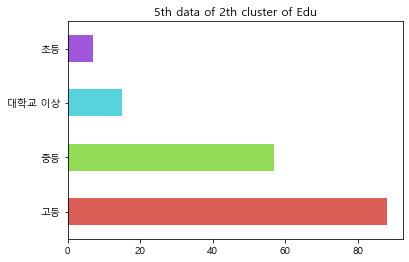

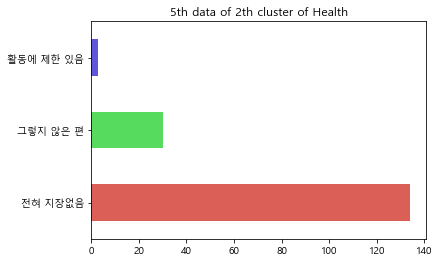

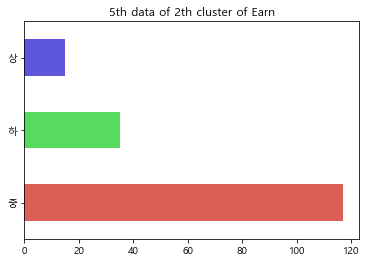

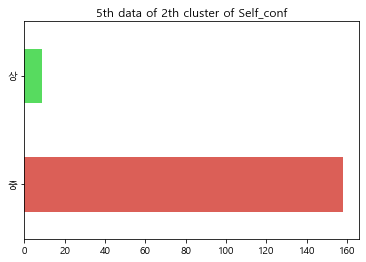

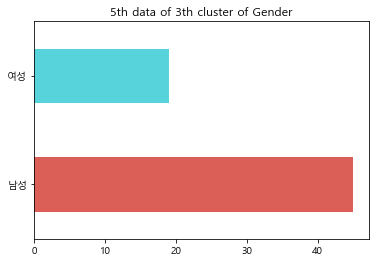

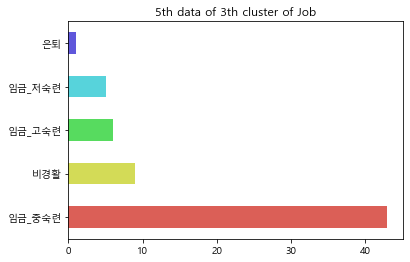

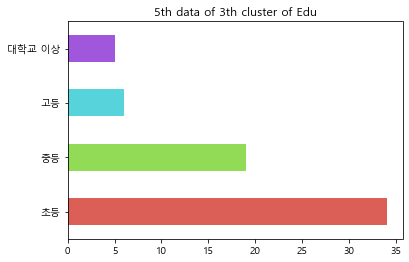

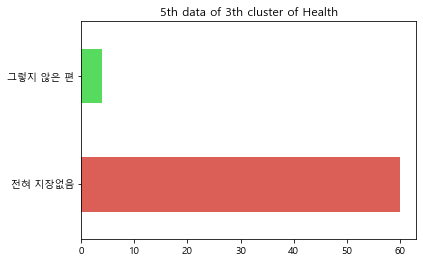

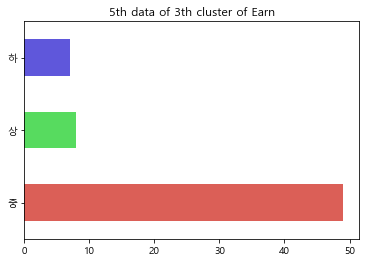

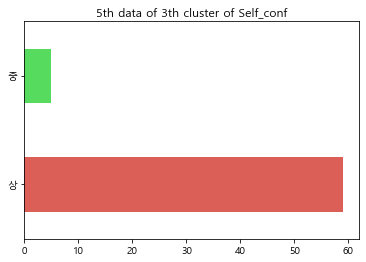

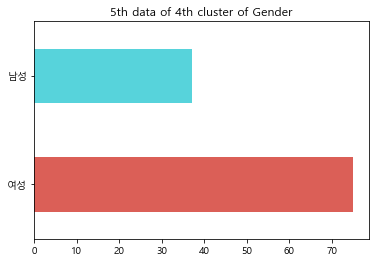

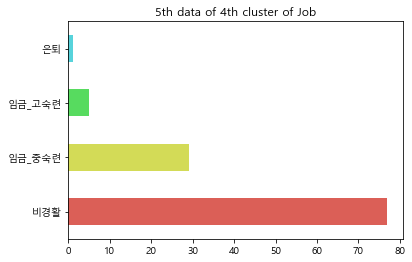

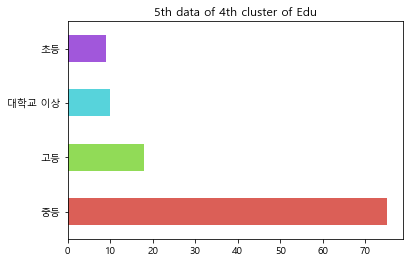

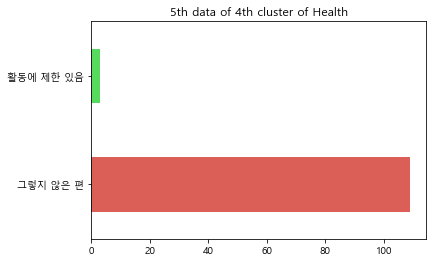

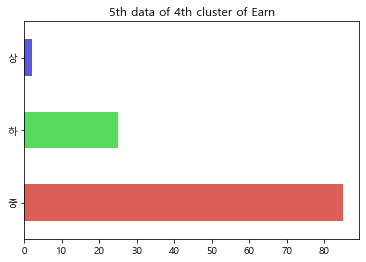

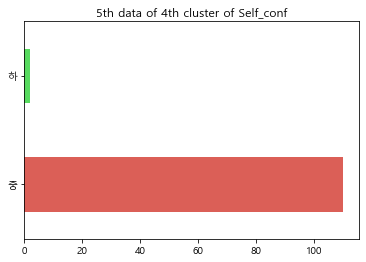

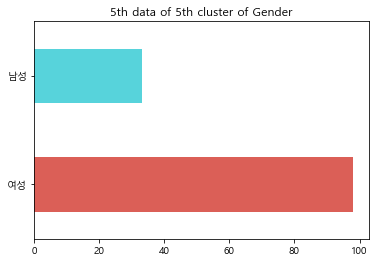

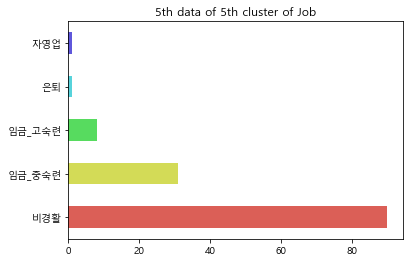

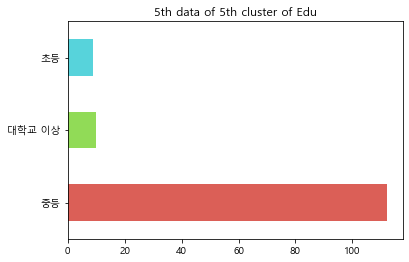

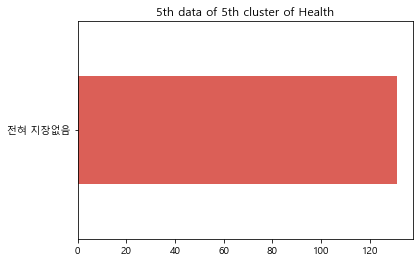

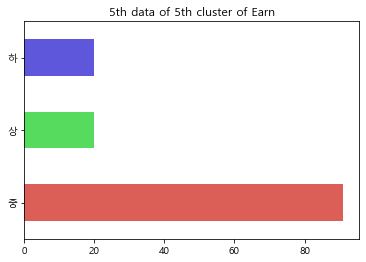

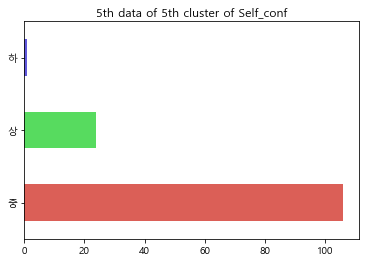

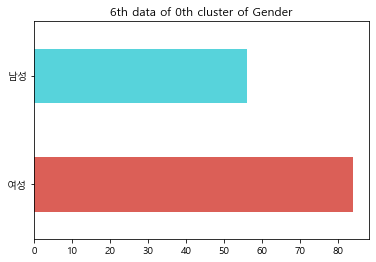

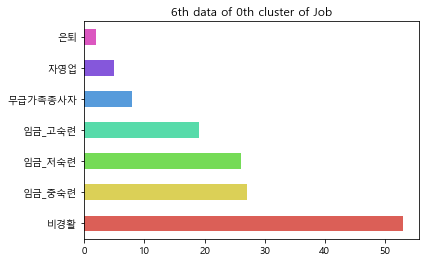

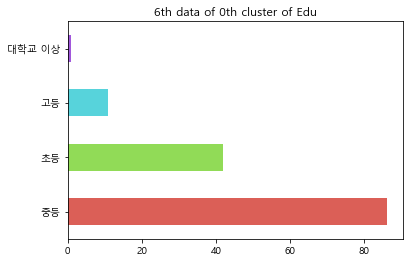

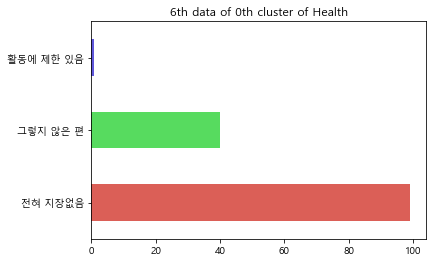

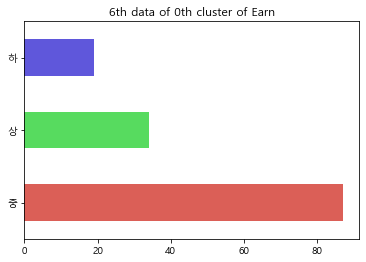

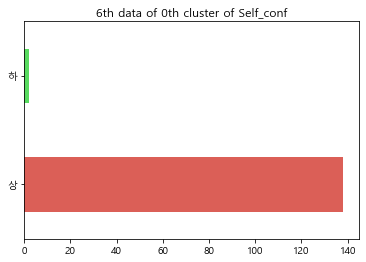

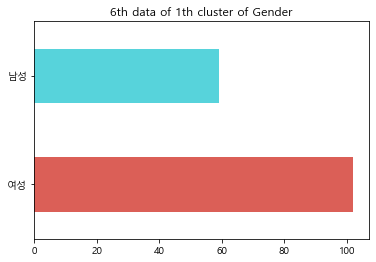

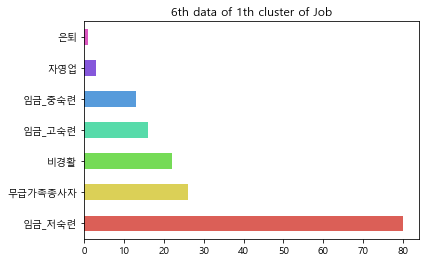

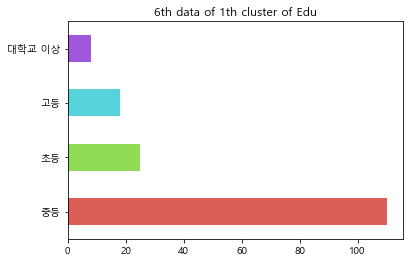

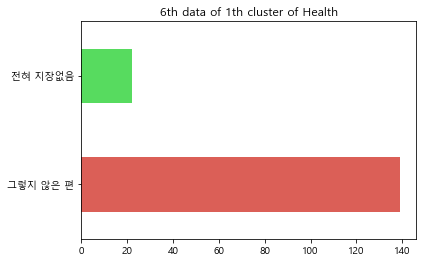

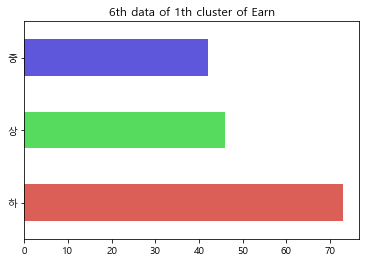

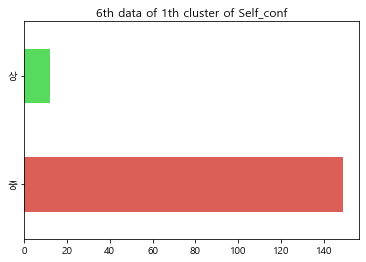

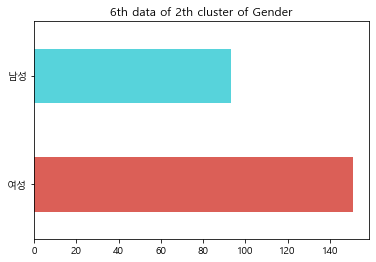

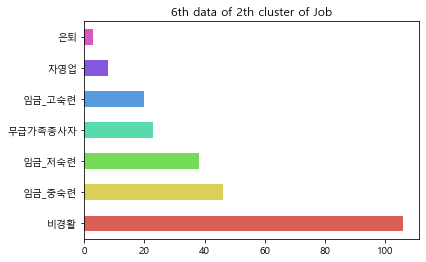

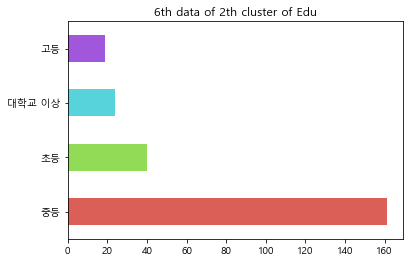

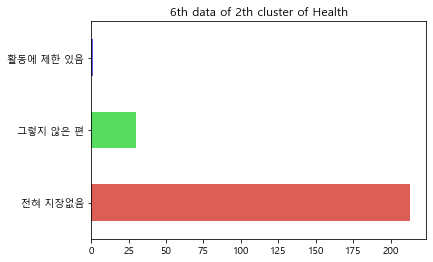

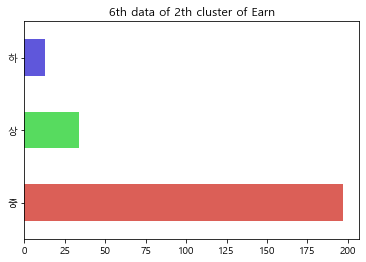

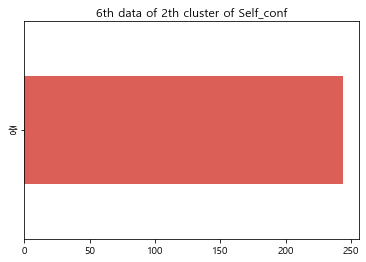

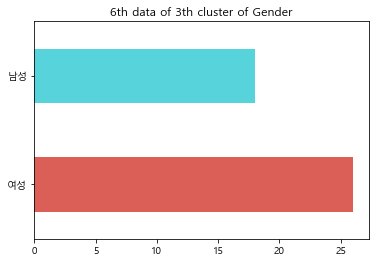

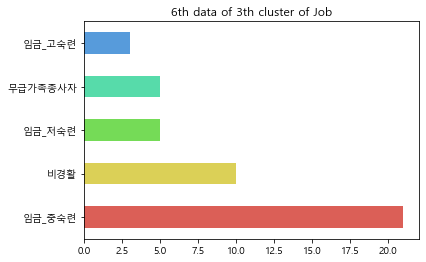

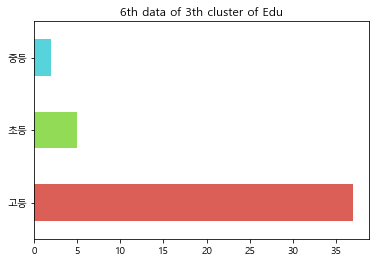

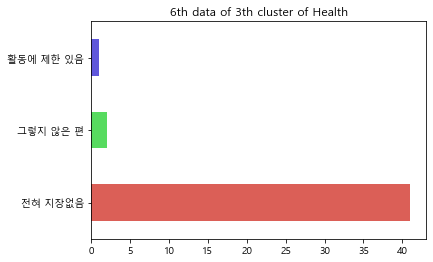

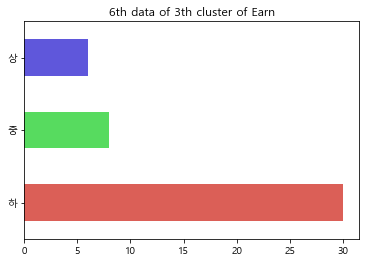

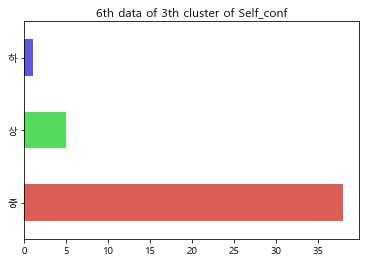

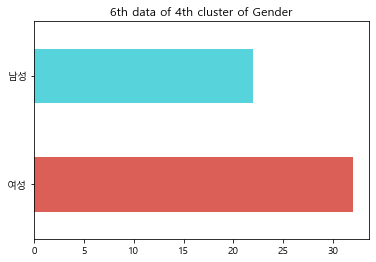

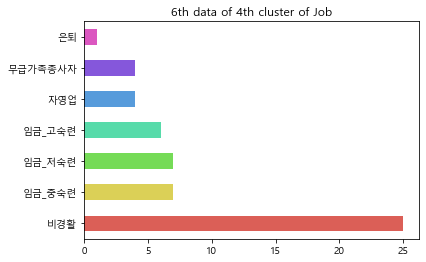

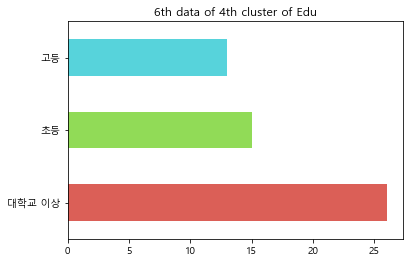

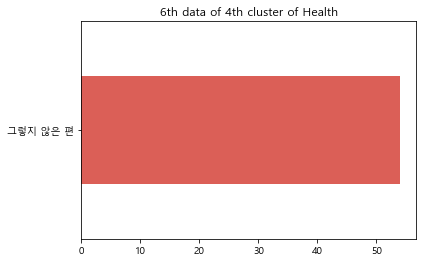

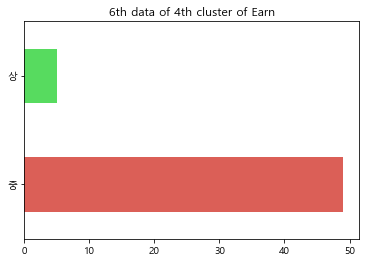

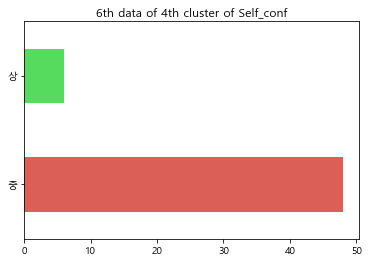

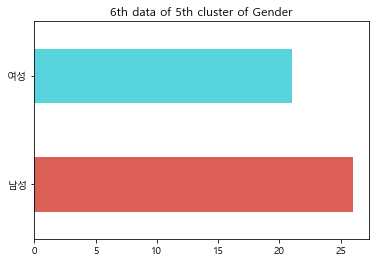

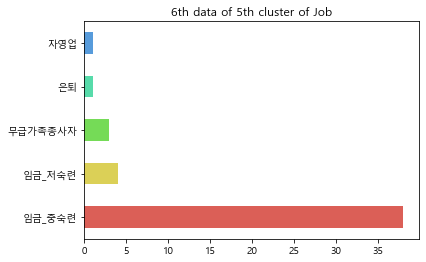

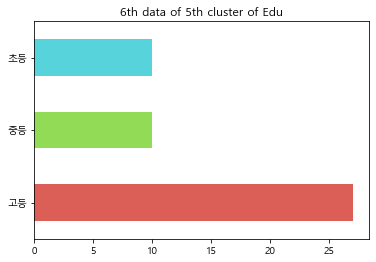

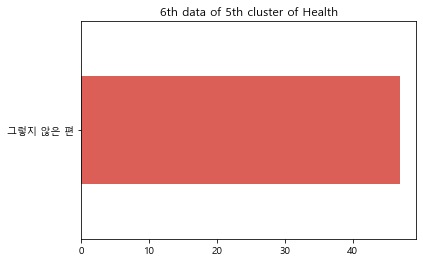

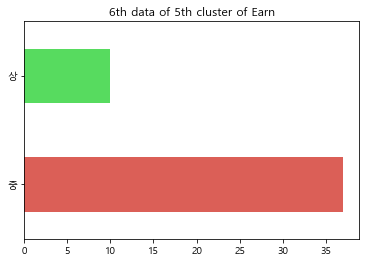

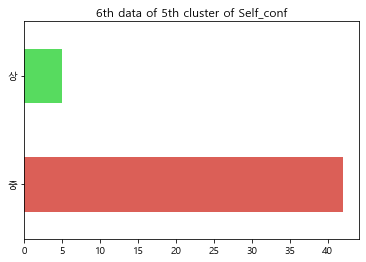

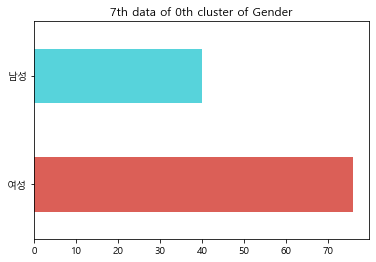

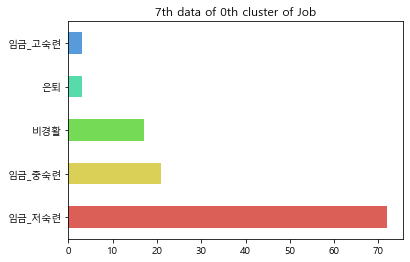

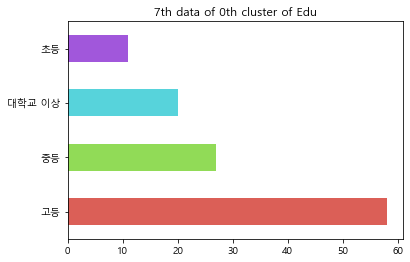

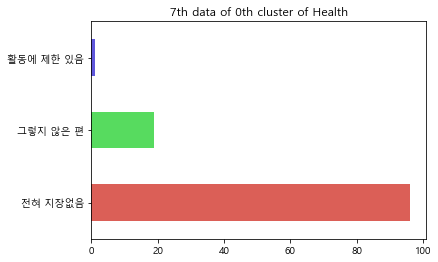

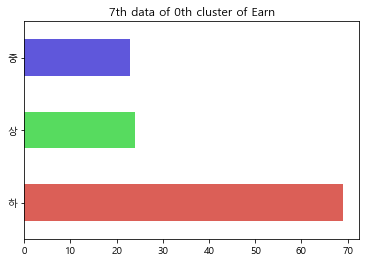

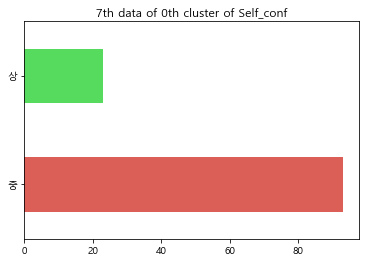

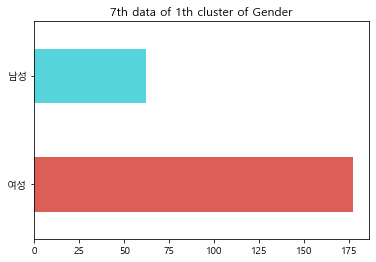

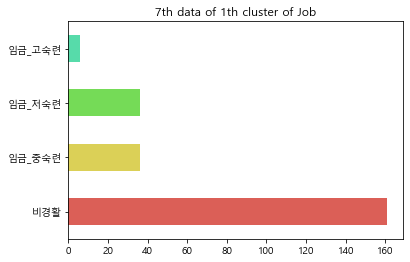

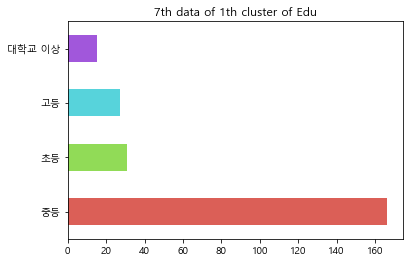

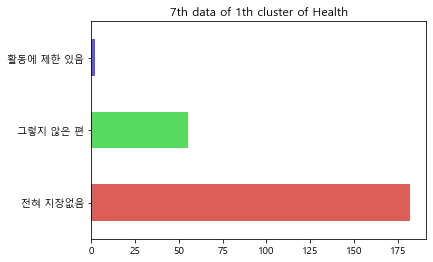

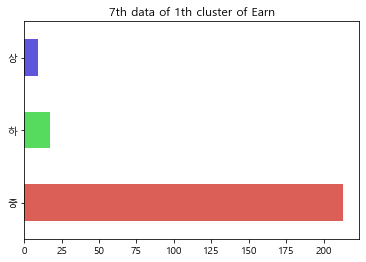

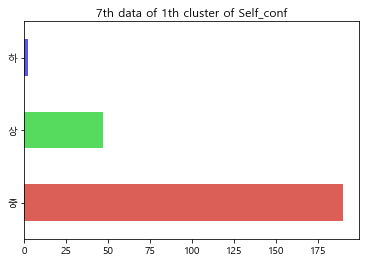

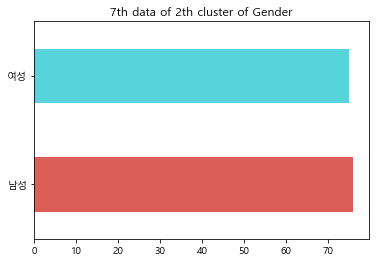

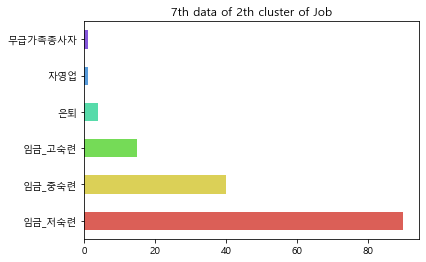

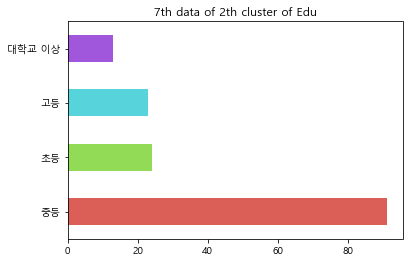

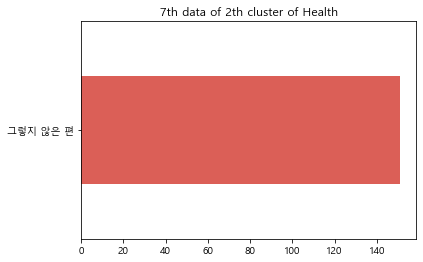

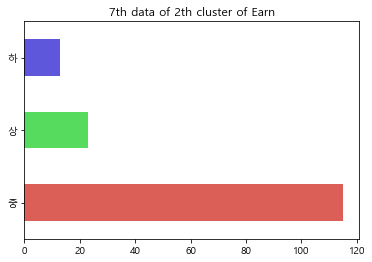

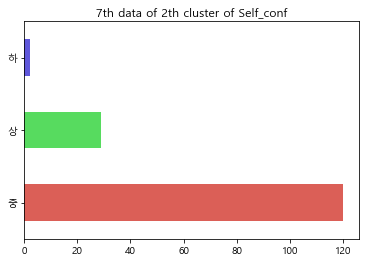

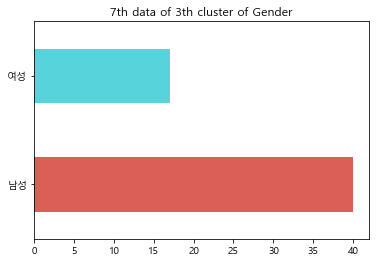

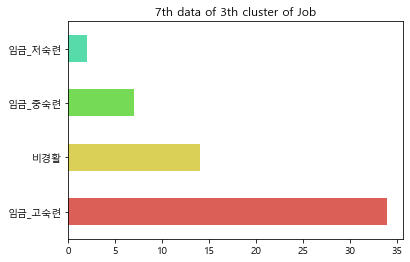

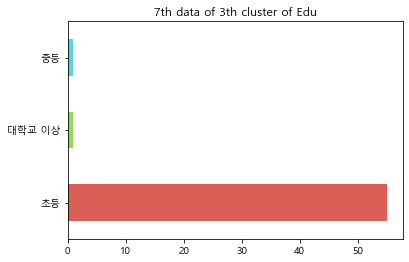

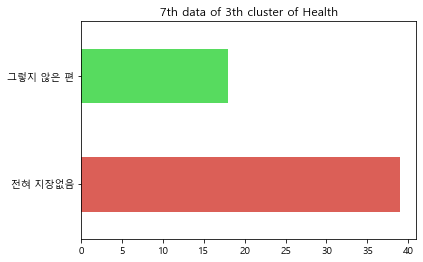

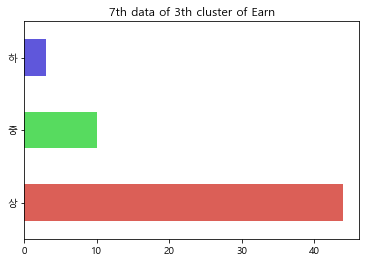

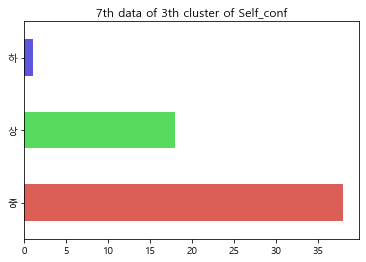

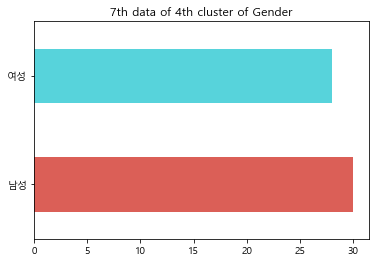

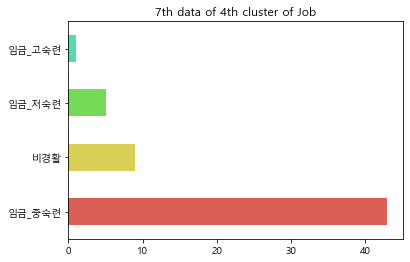

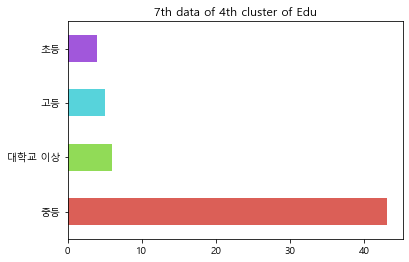

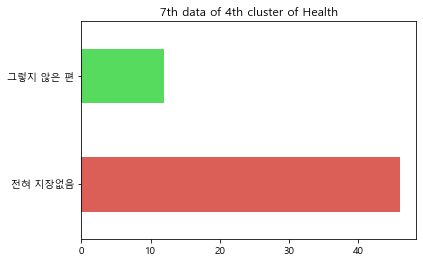

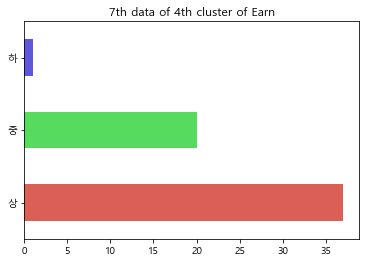

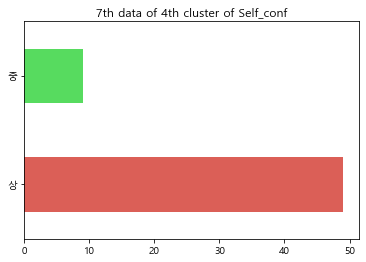

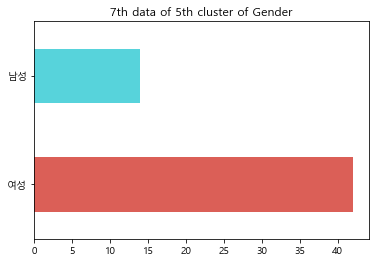

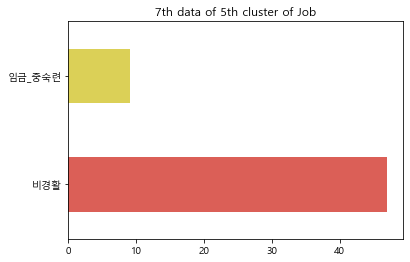

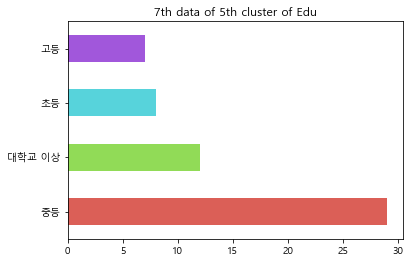

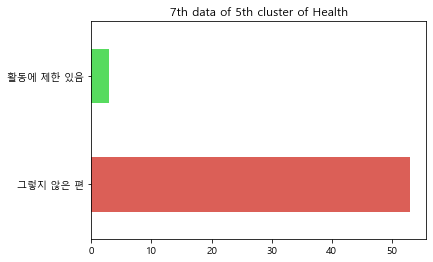

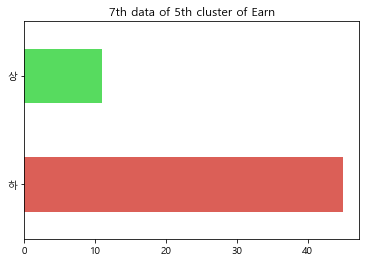

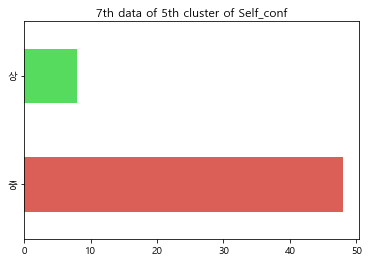

In [175]:
cols = list(data_0.drop(['Year', 'Cluster', 'Gender'], axis=1).columns)
for idx, data in enumerate(data_lst):
    for clus in range(0, 6):
        for col in cols:
            colors = sns.color_palette('hls',len(data[col].value_counts()))
            data[data['Cluster'] == clus].drop(['Year', 'Cluster'], axis=1)[col].value_counts().plot(kind='barh', color = colors)
            plt.title(f'{idx}th data of {clus}th cluster of {col}')
            plt.show()

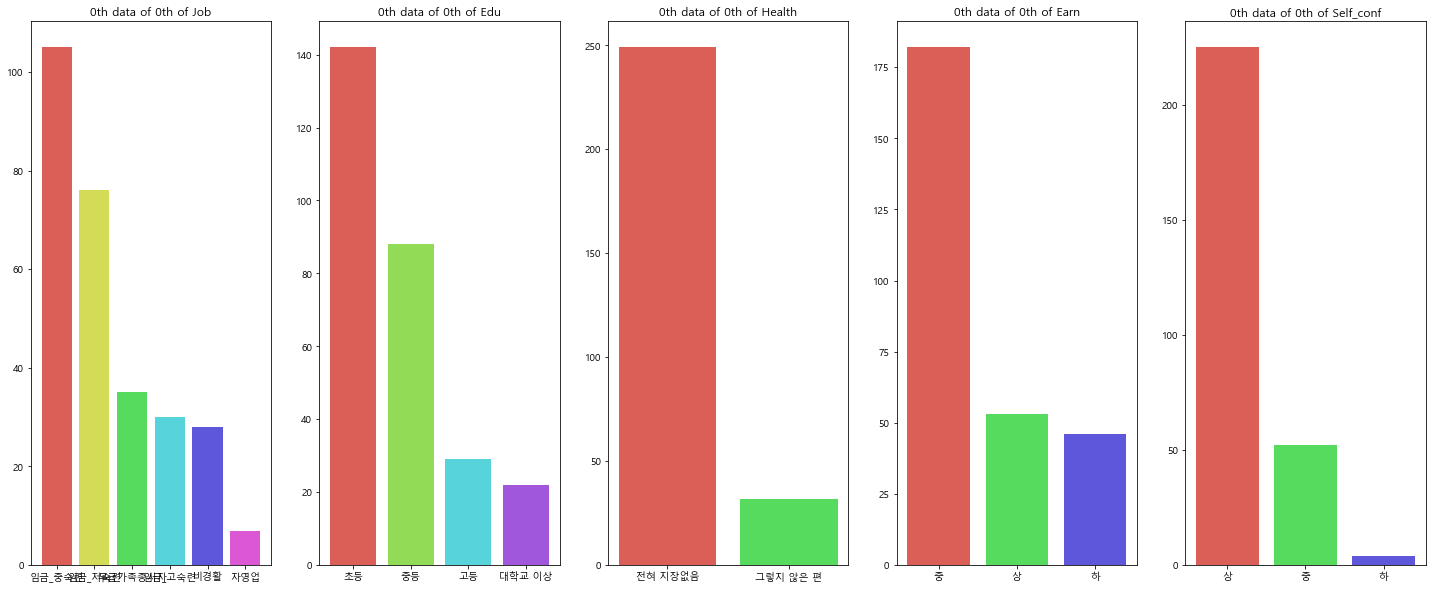

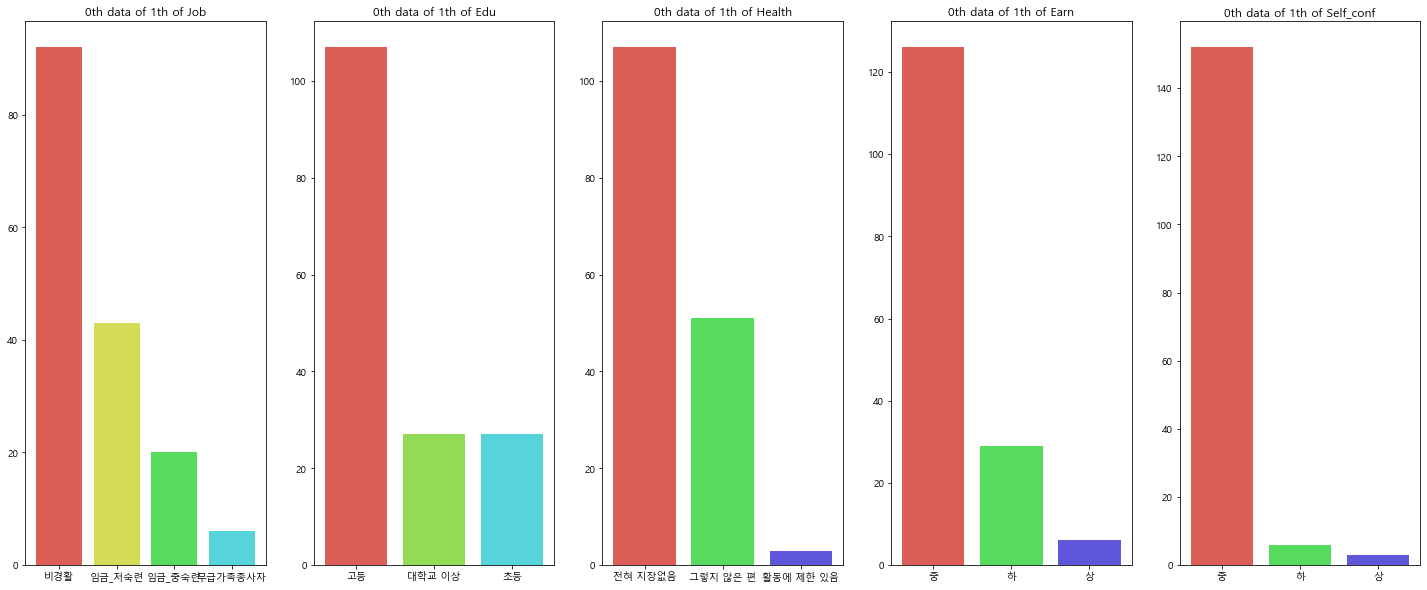

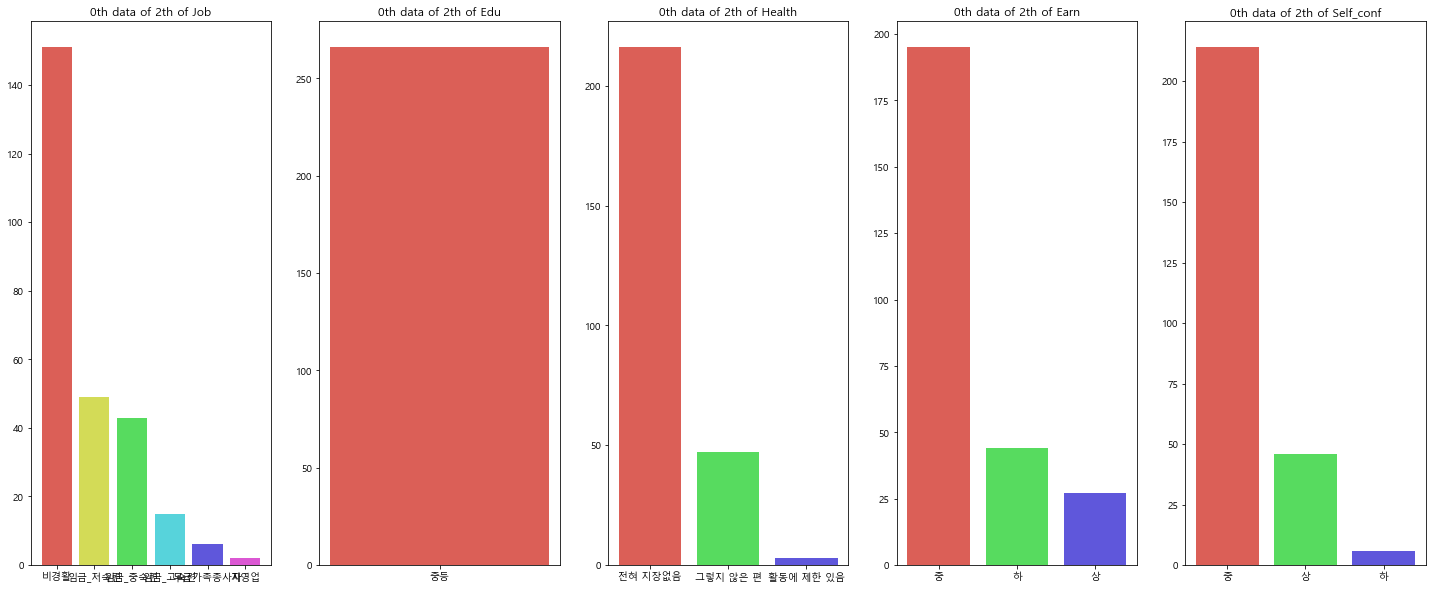

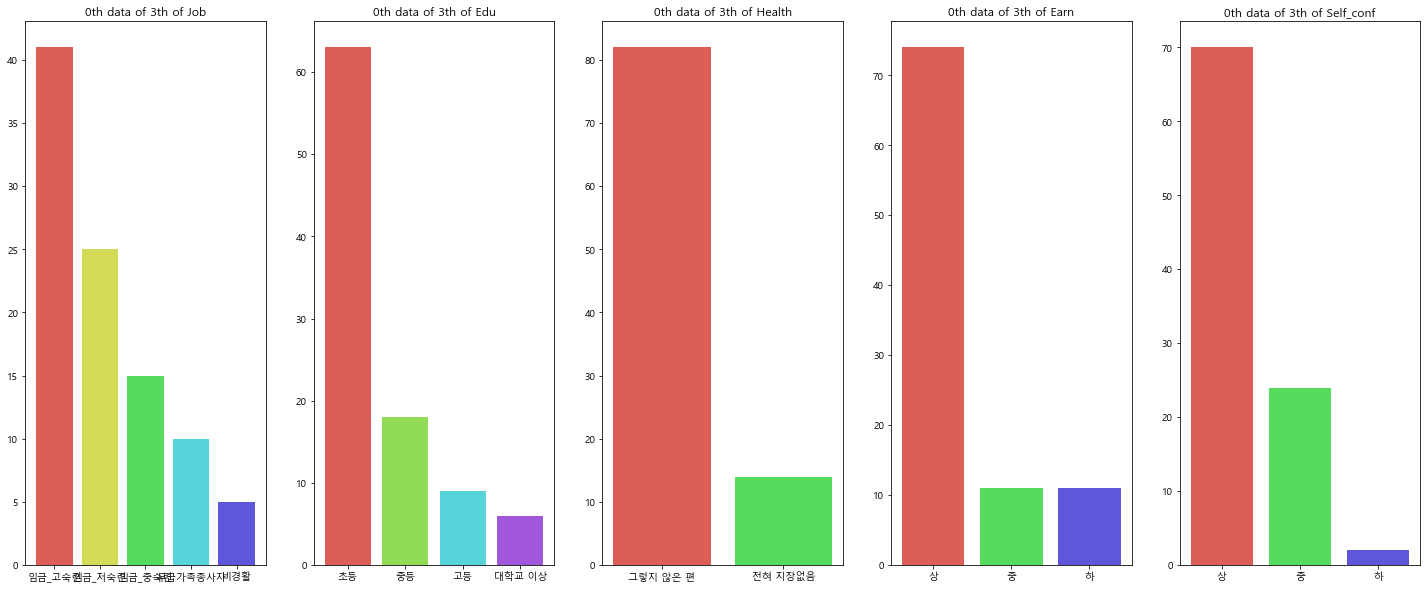

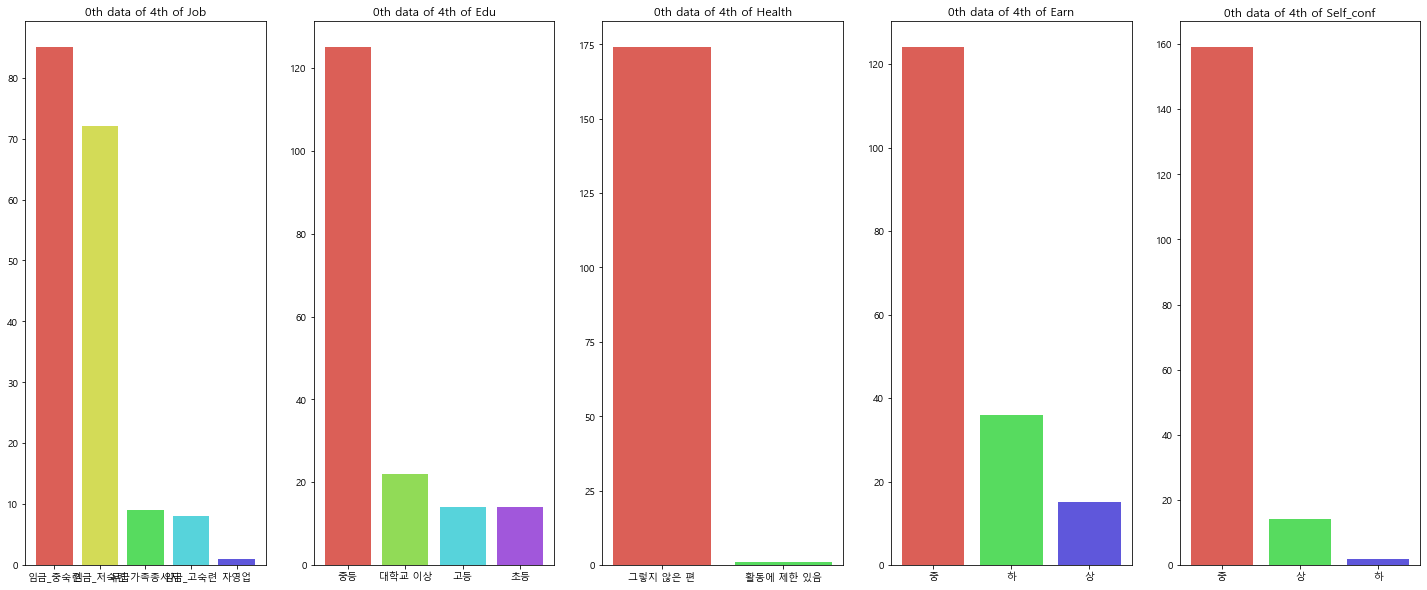

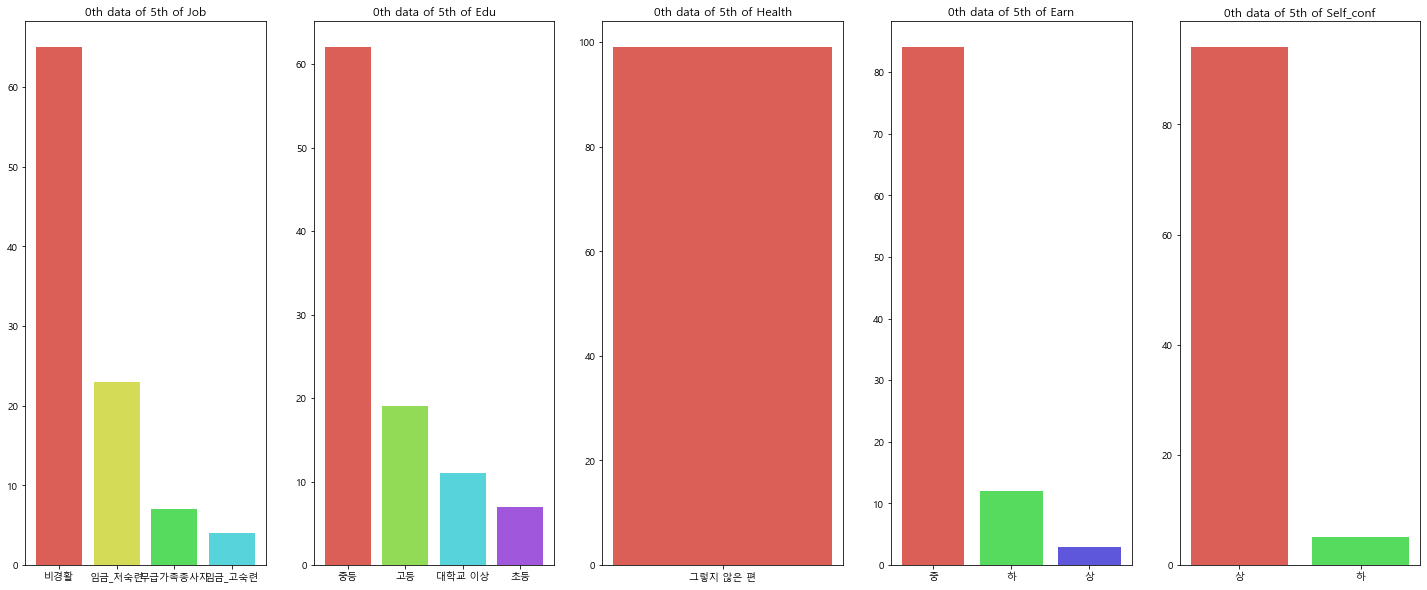

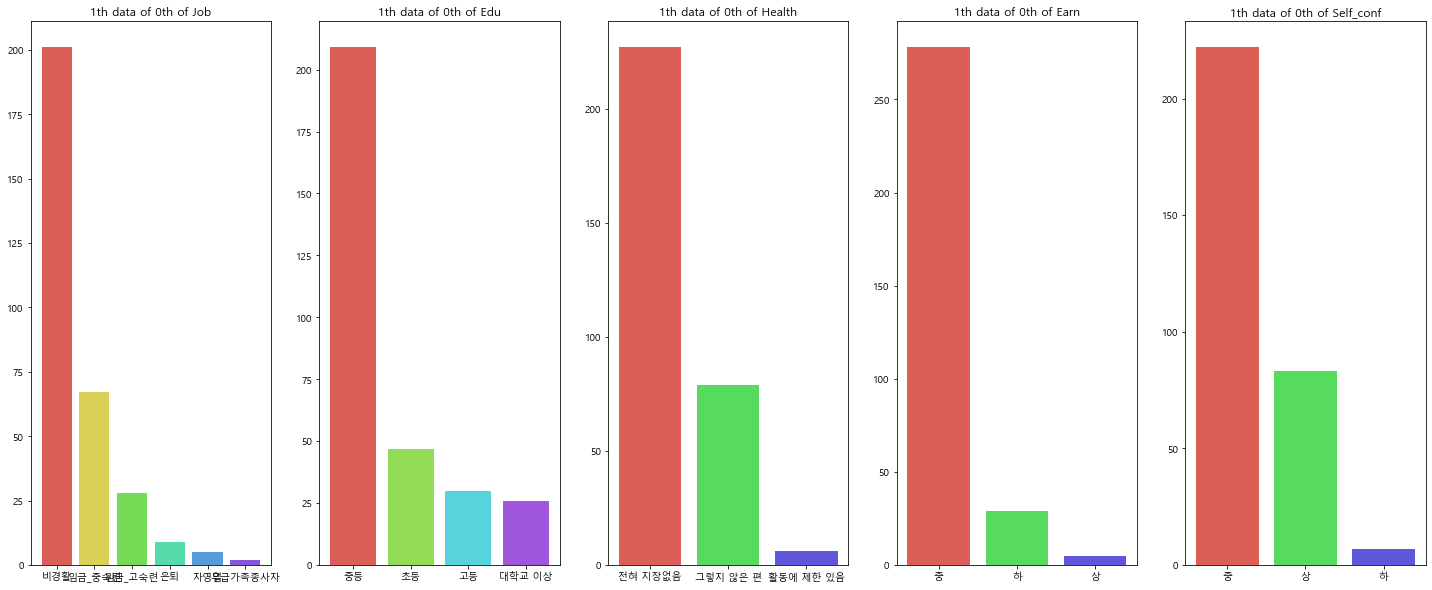

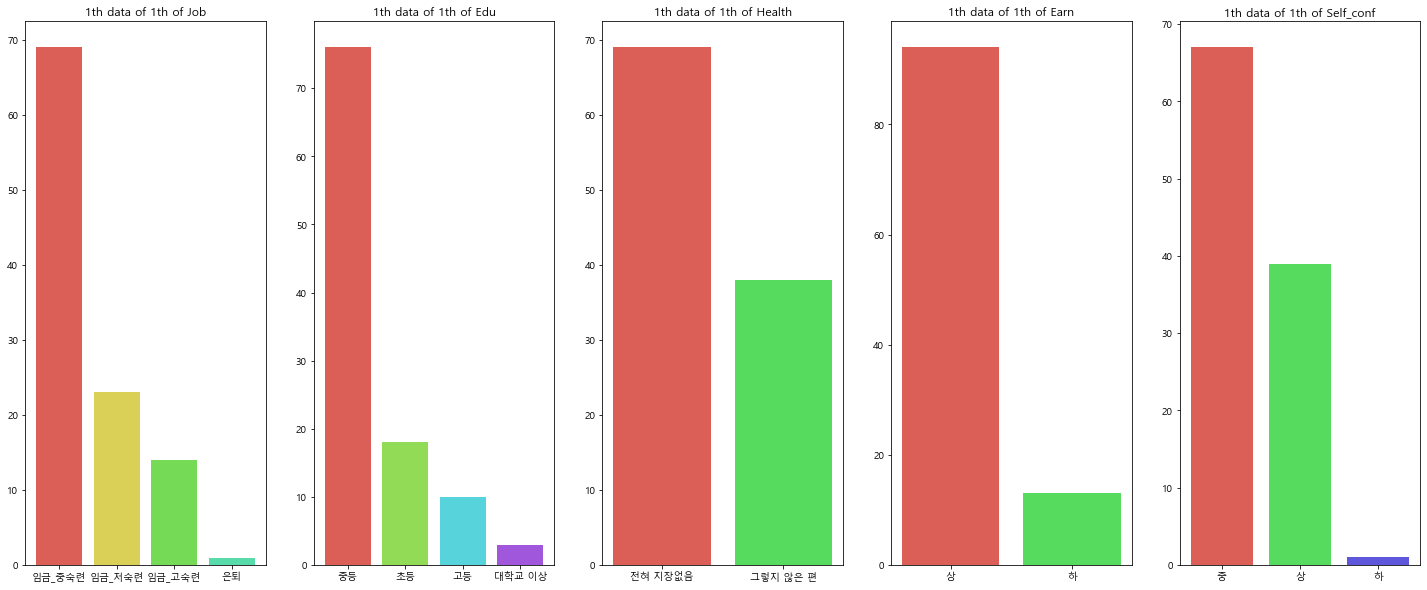

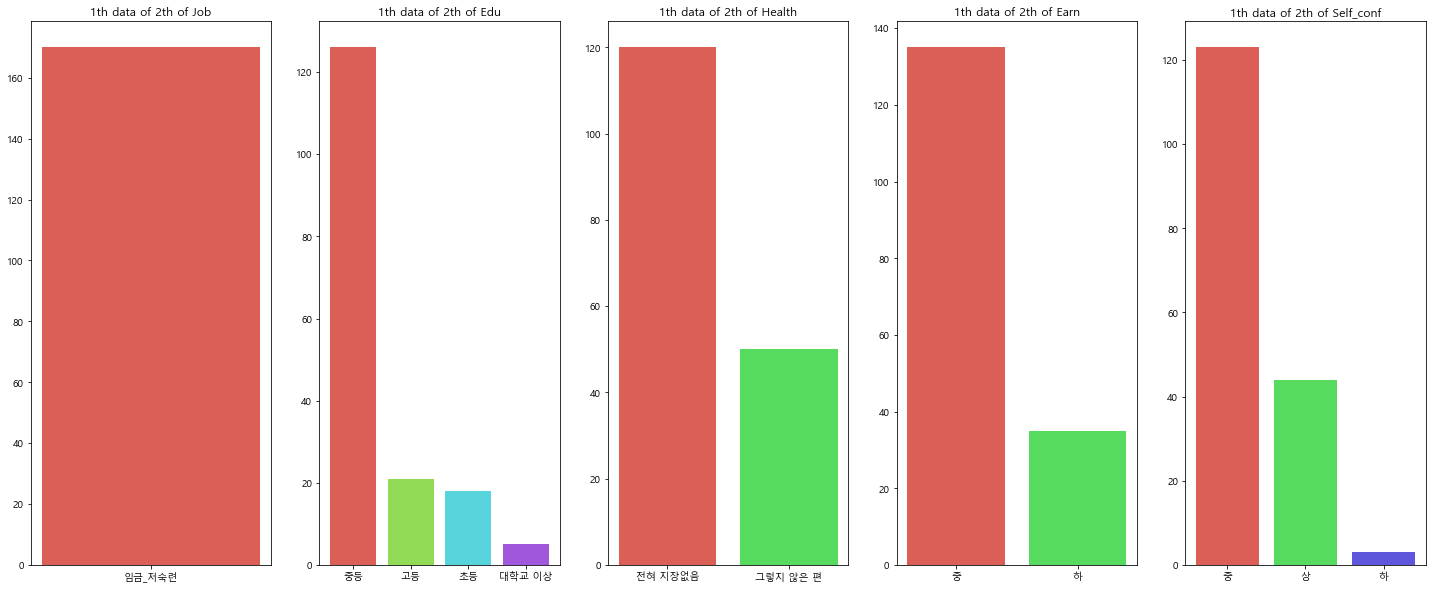

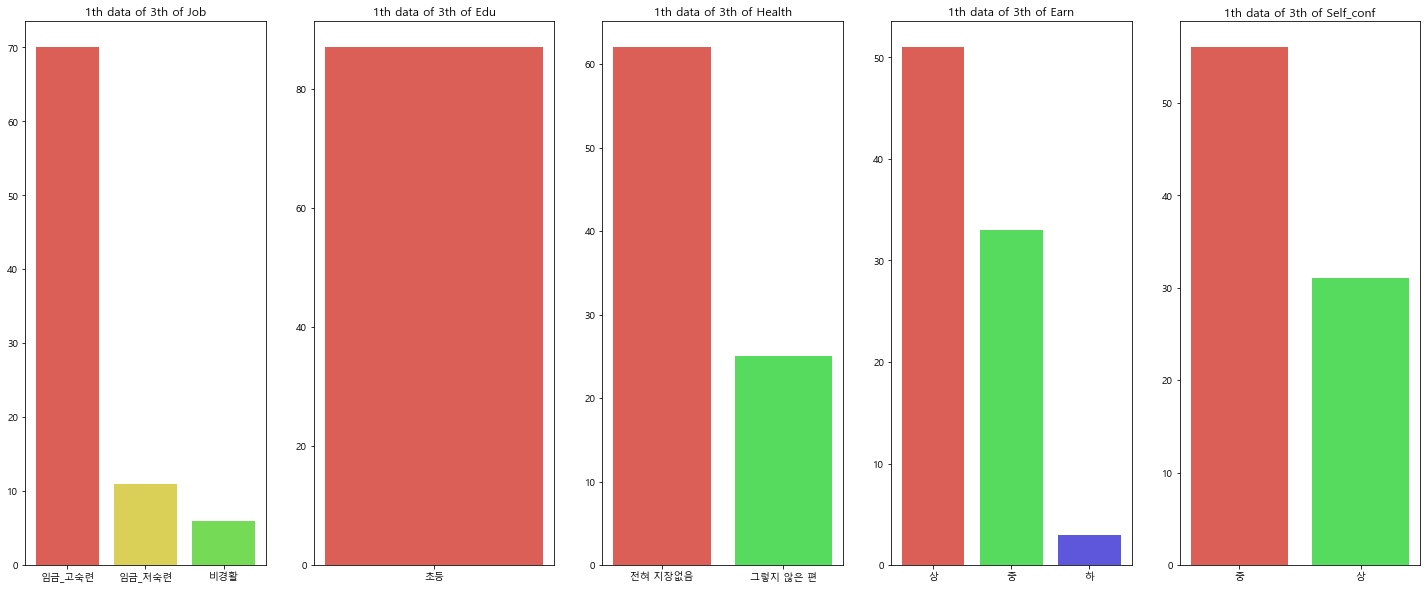

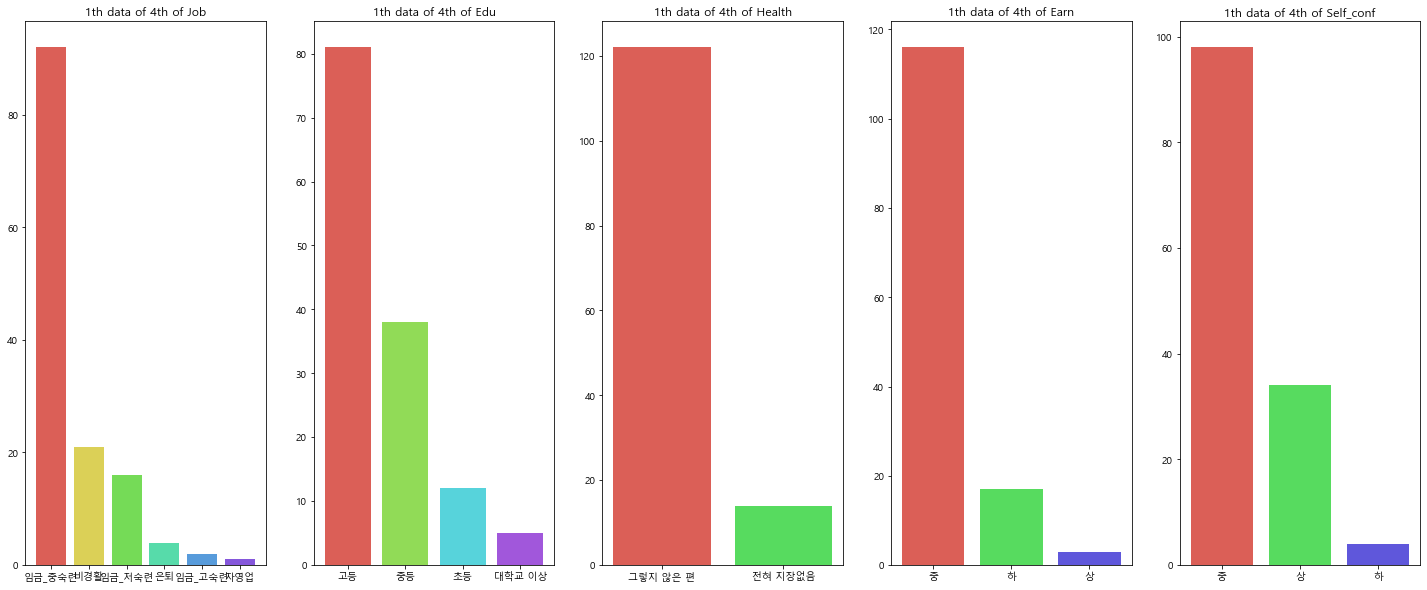

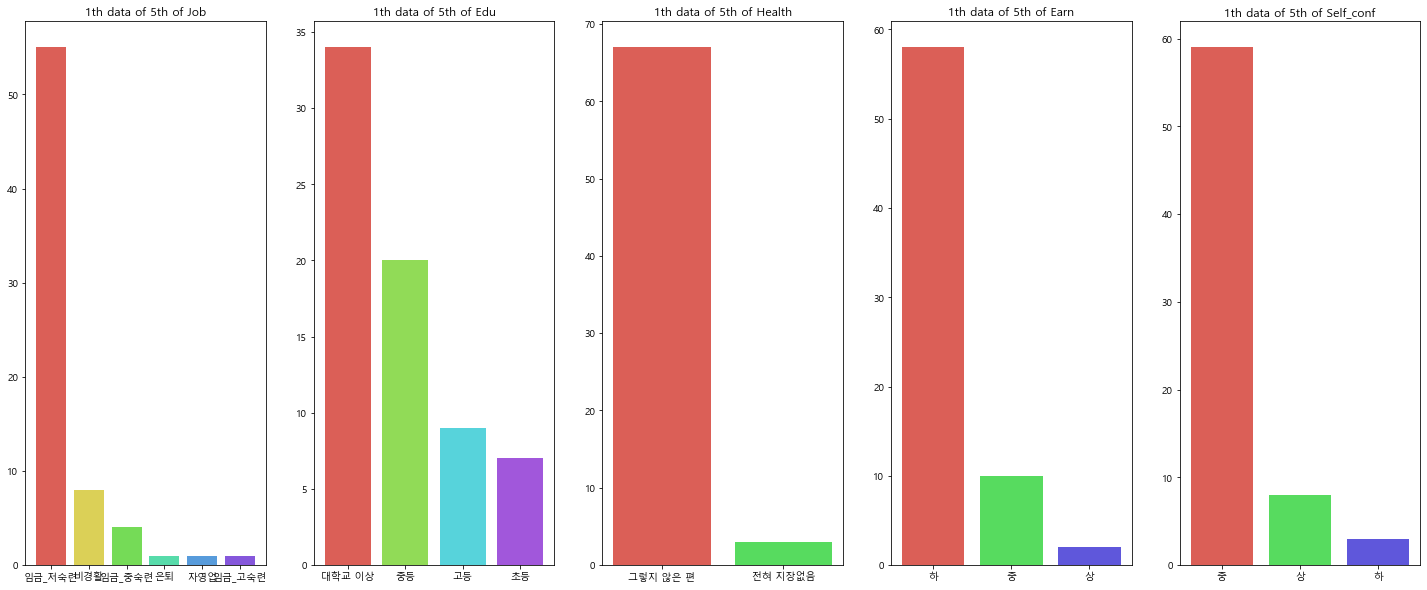

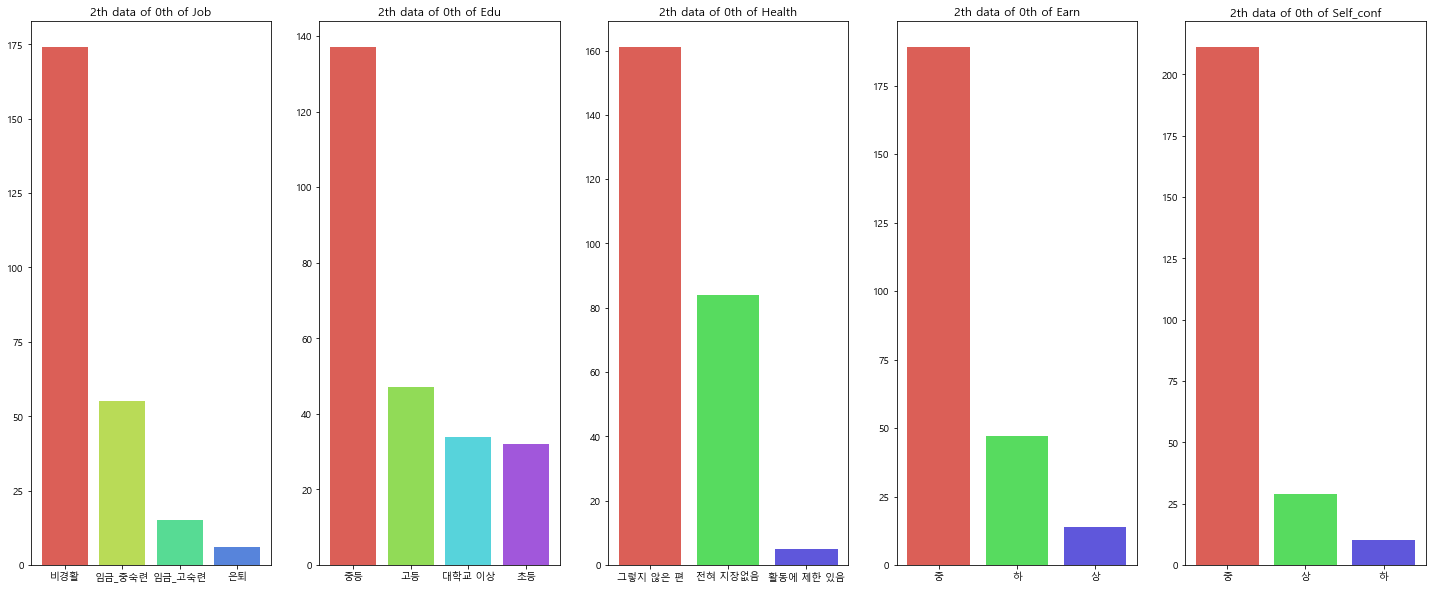

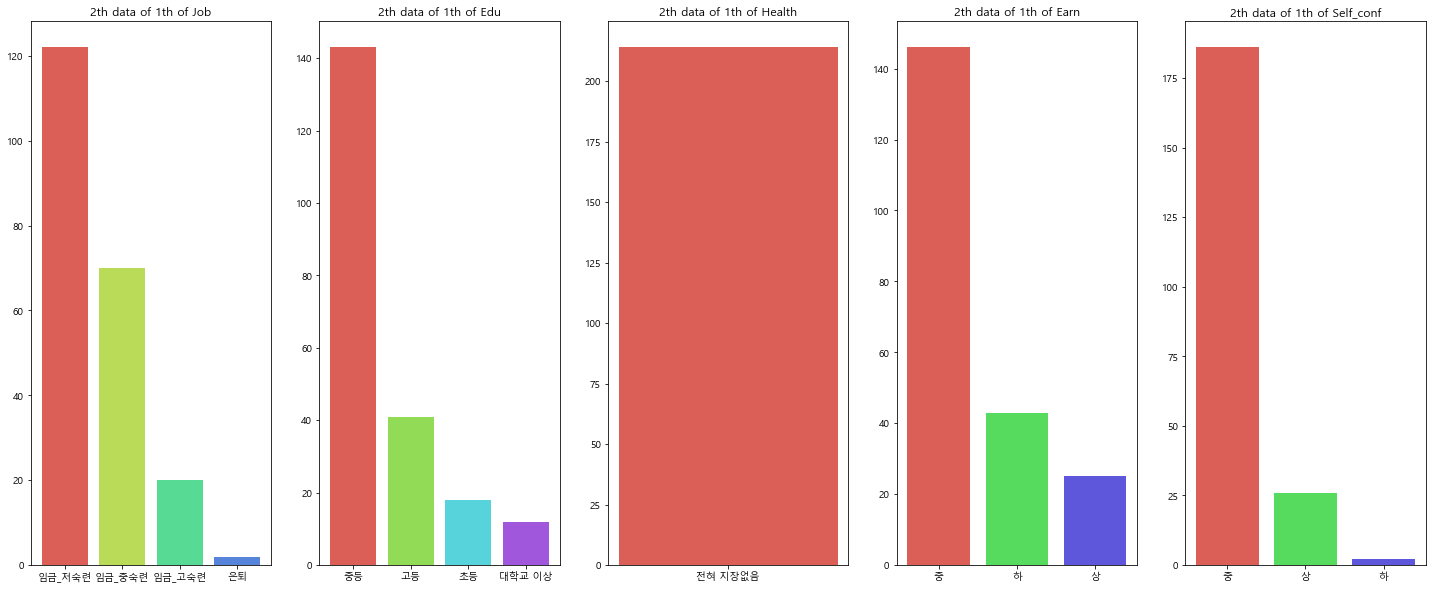

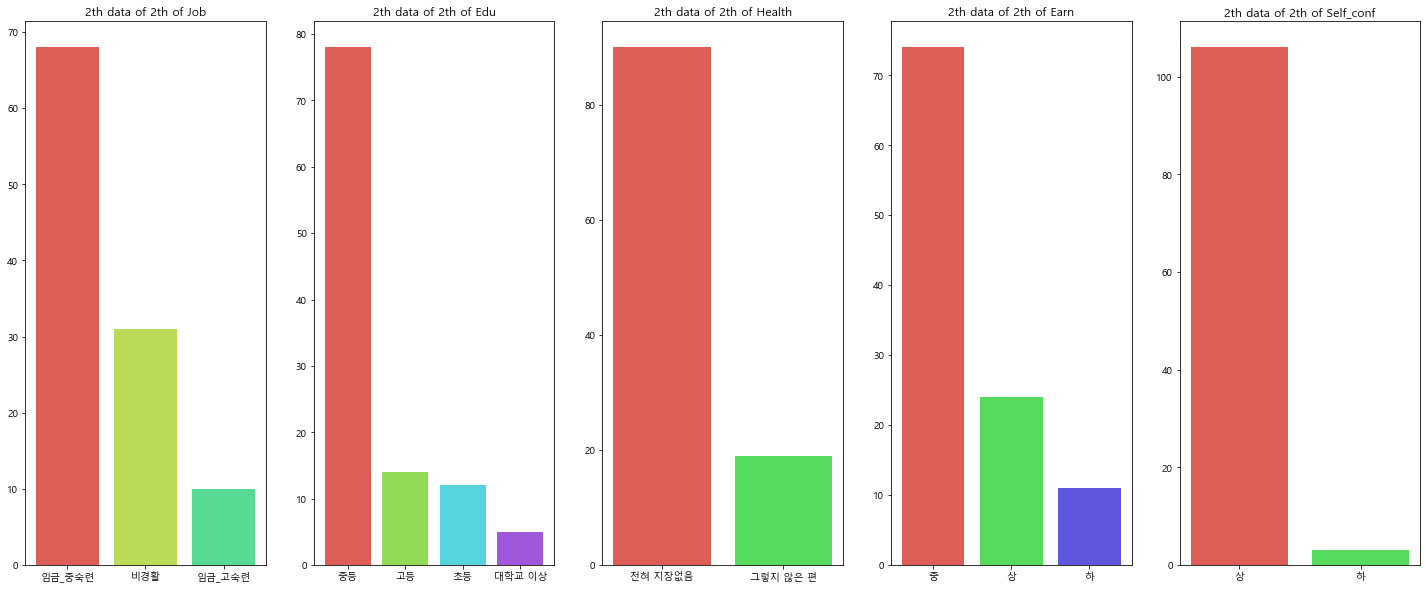

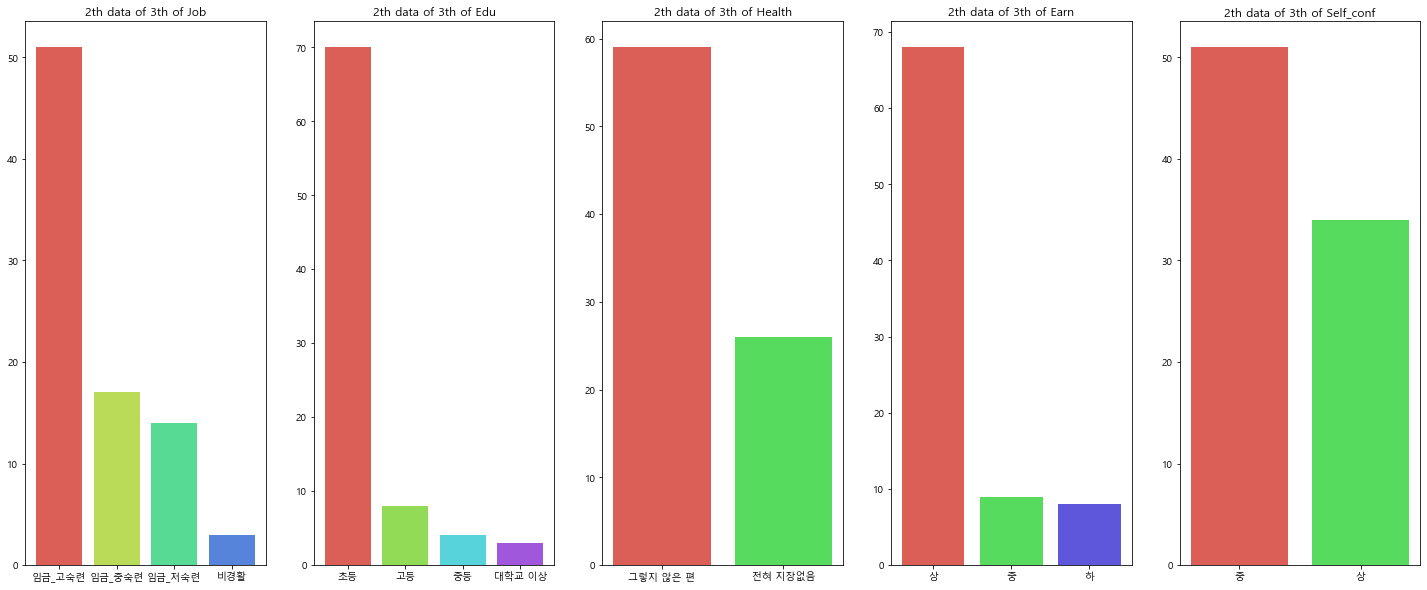

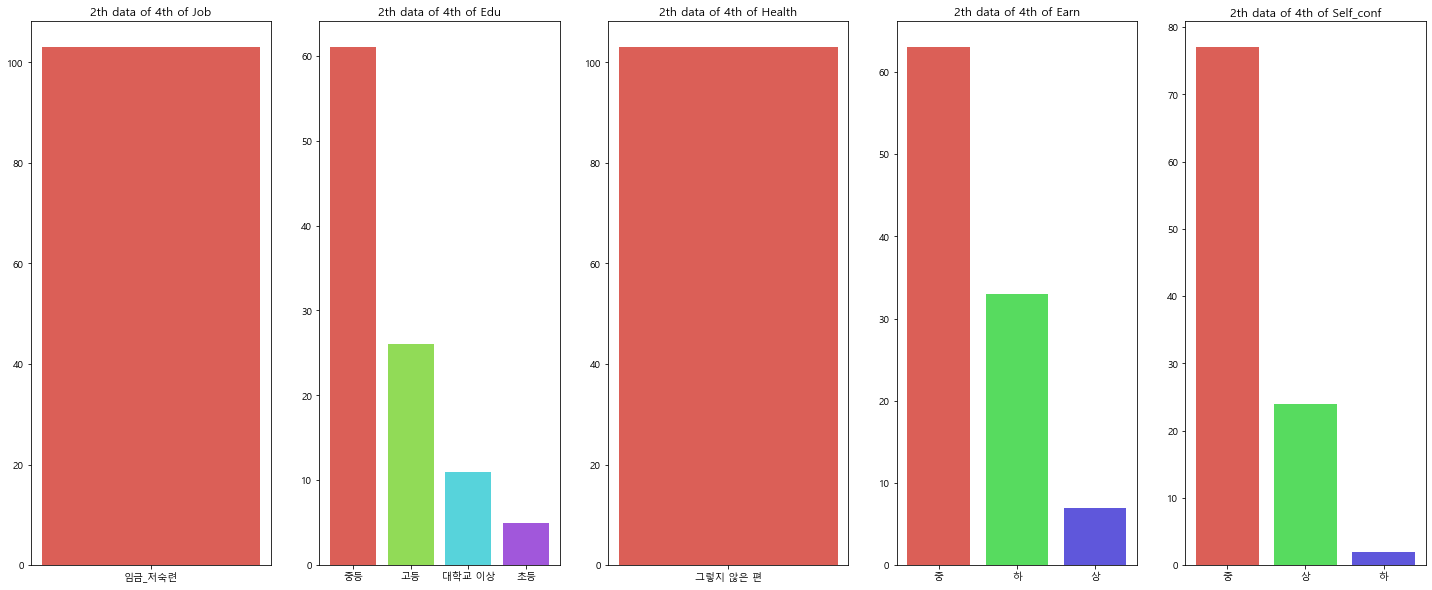

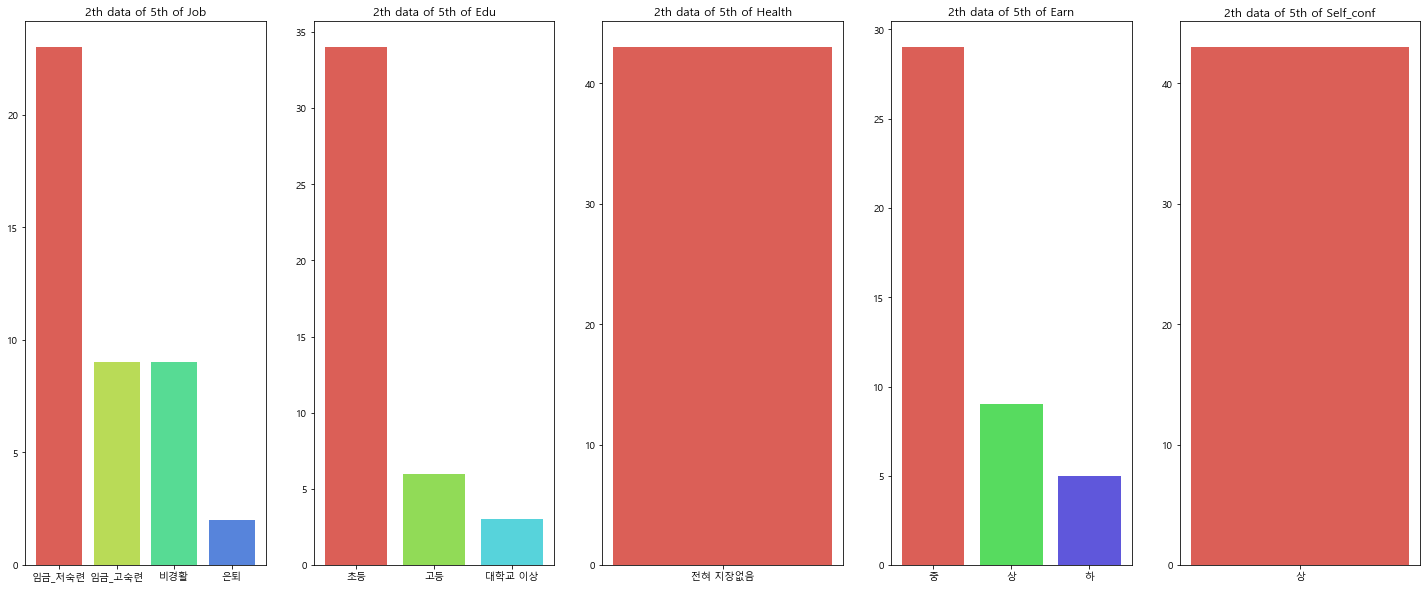

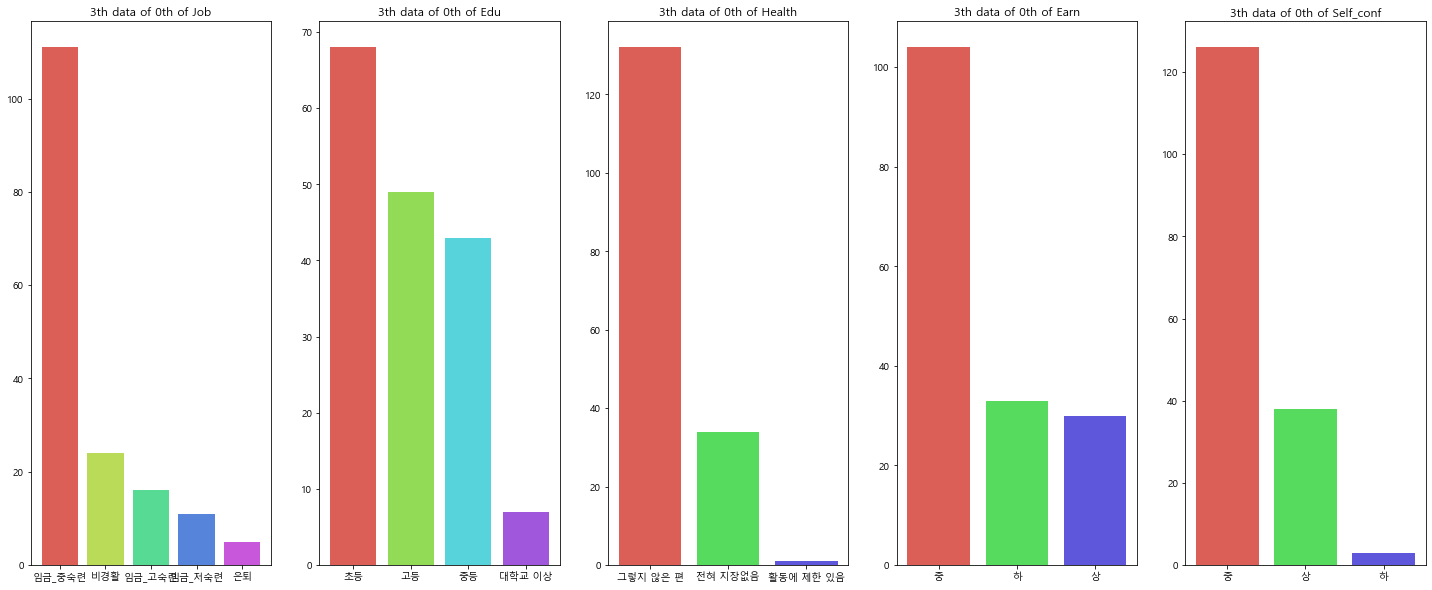

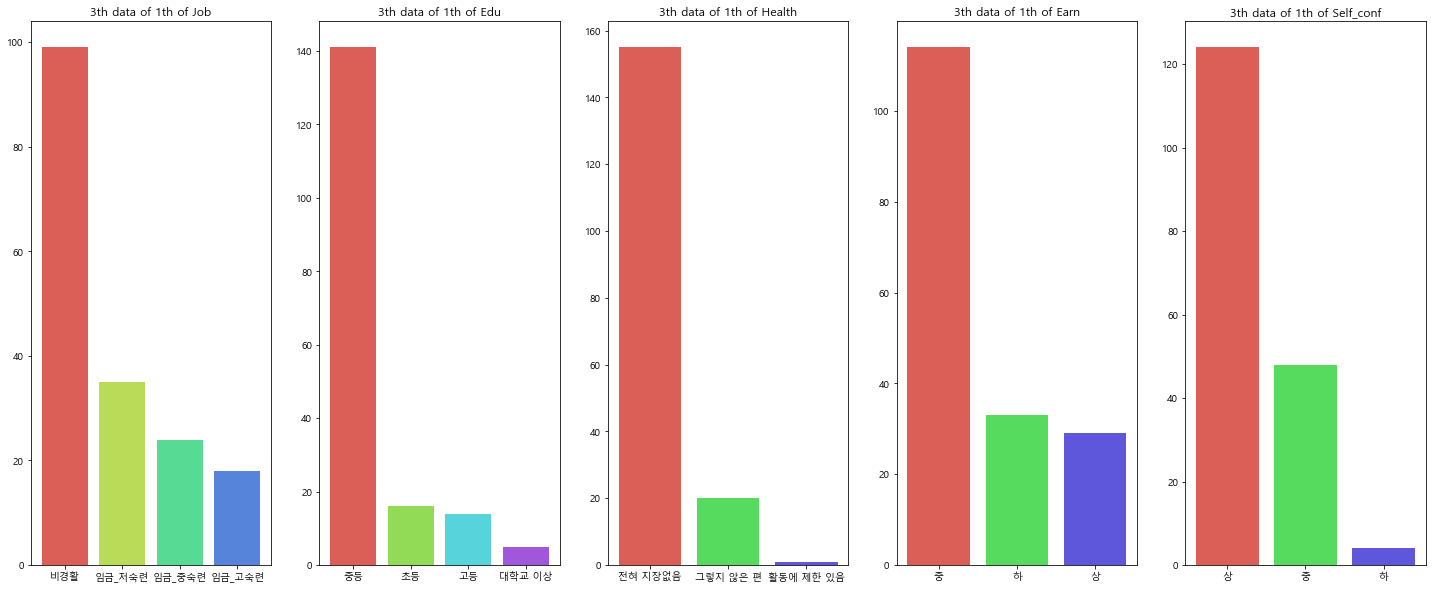

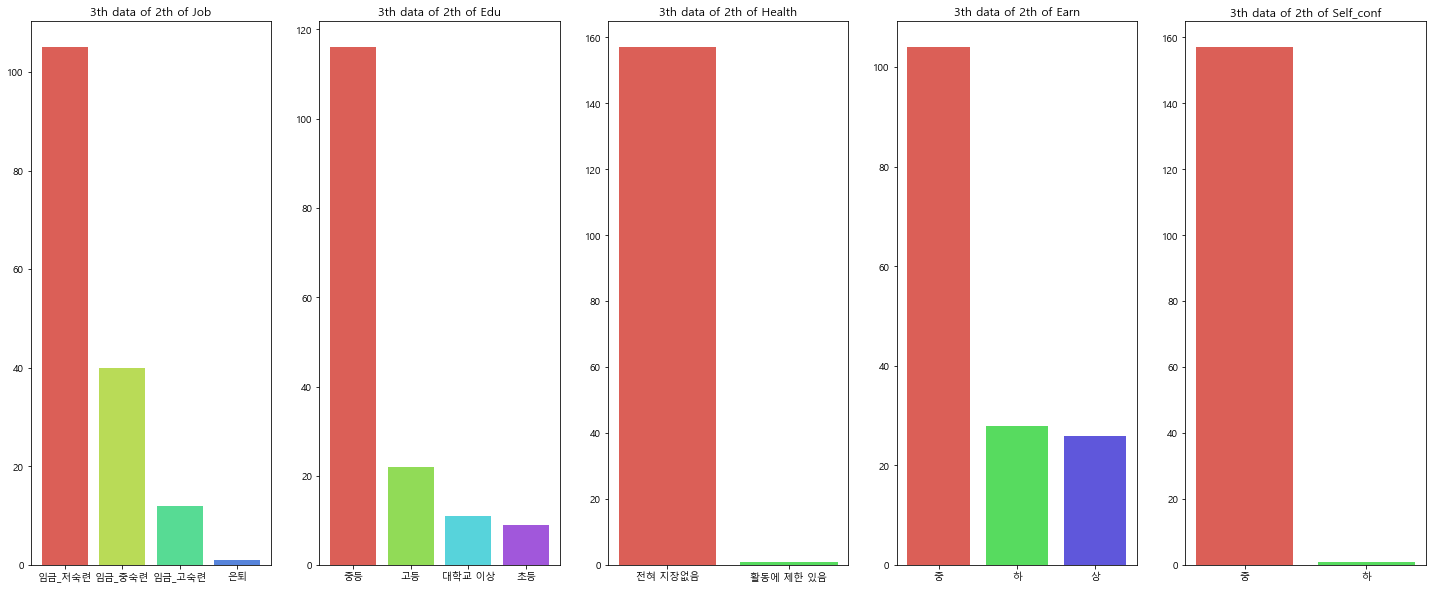

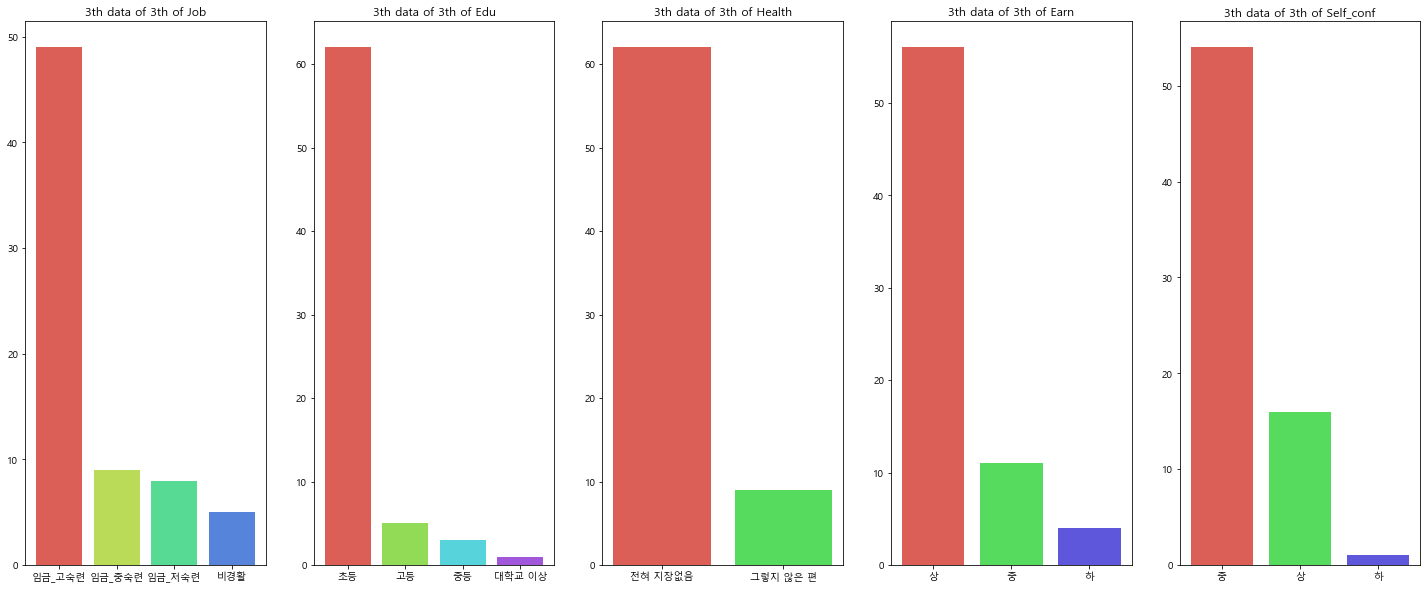

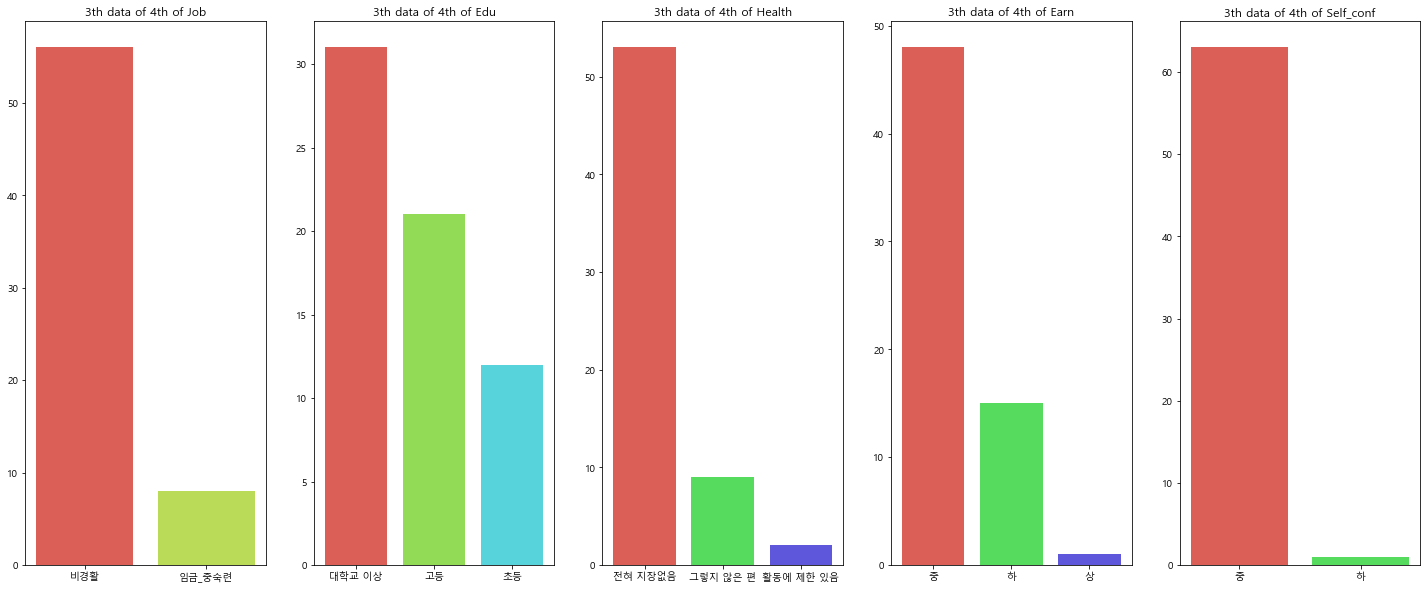

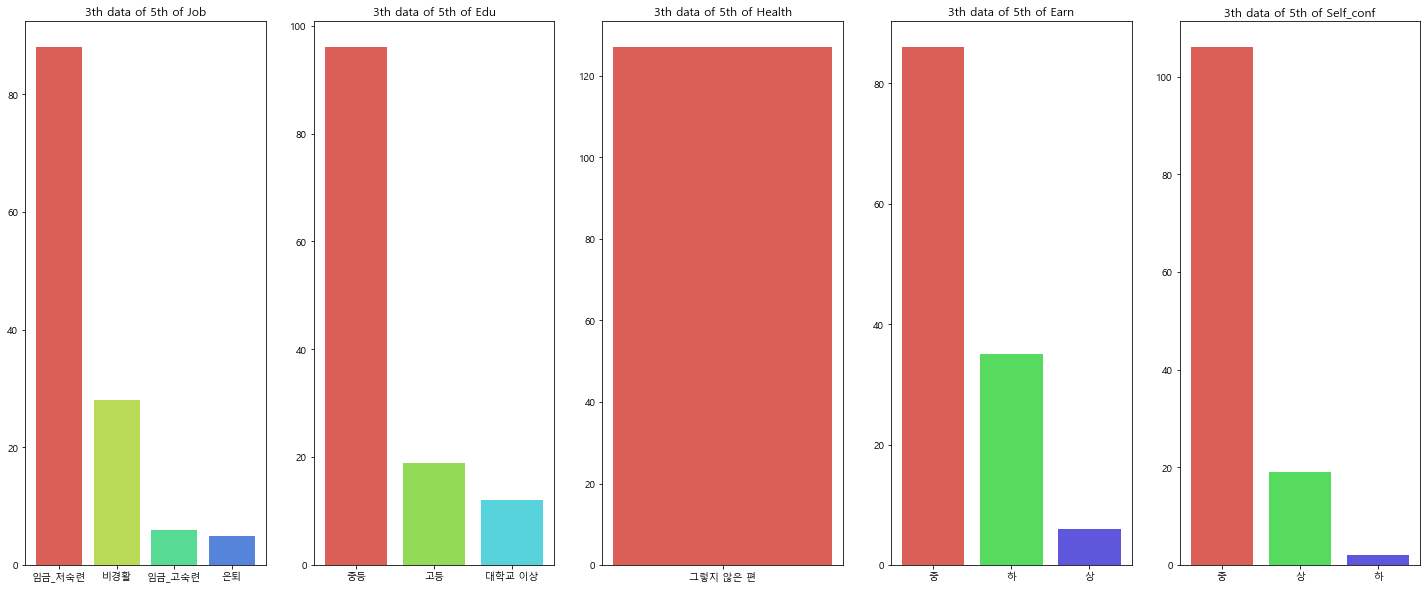

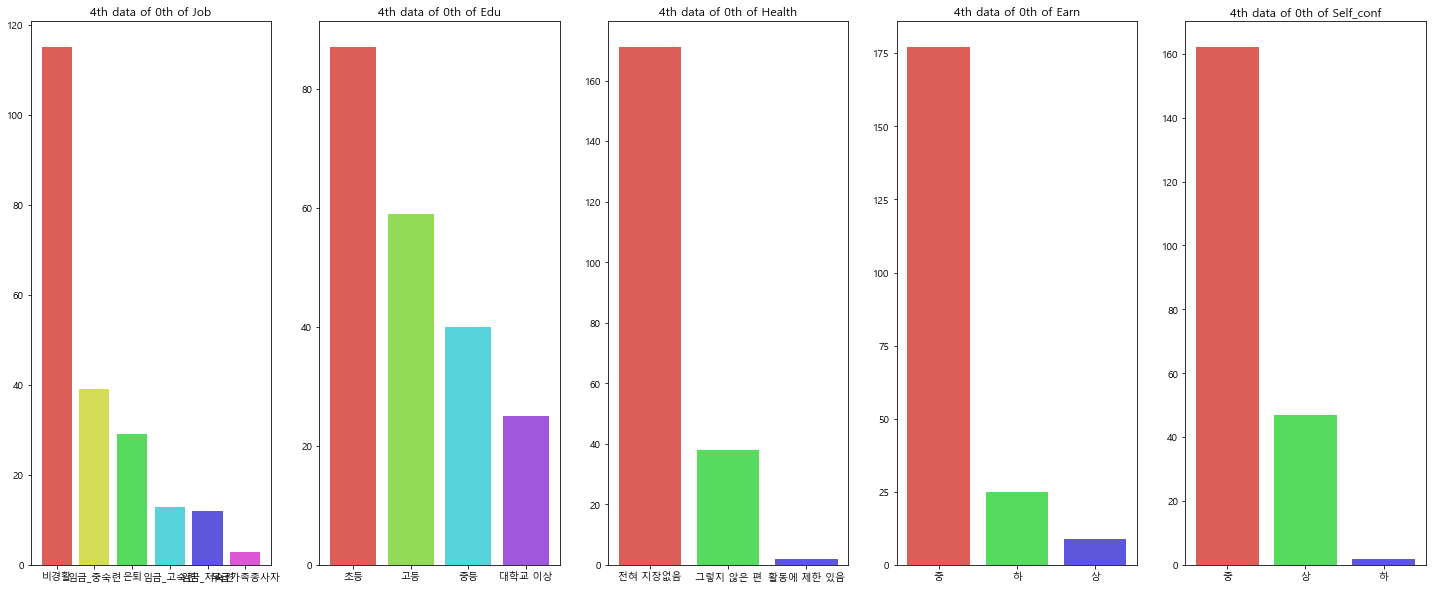

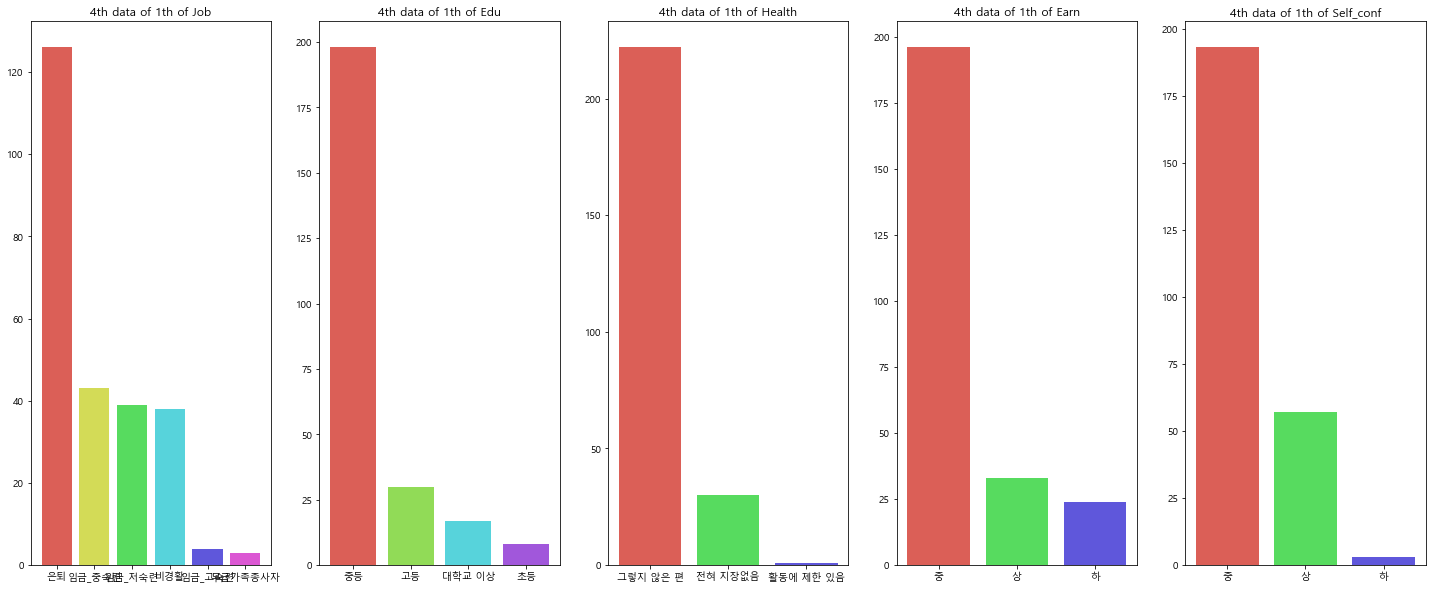

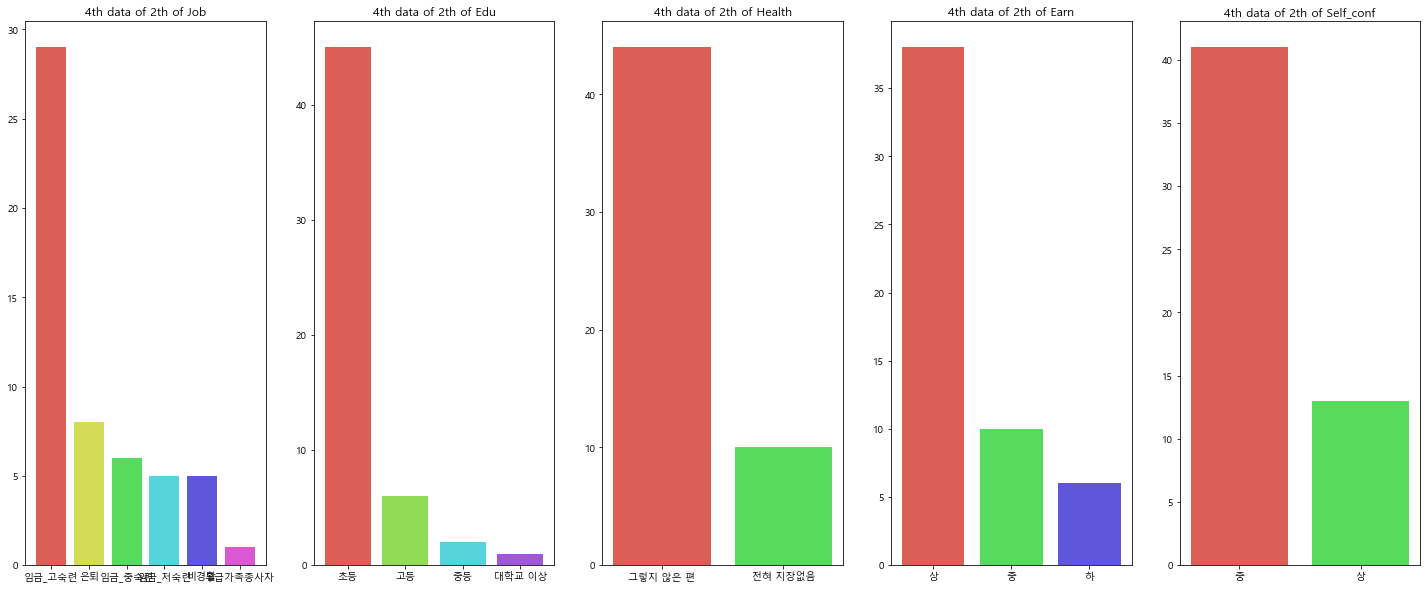

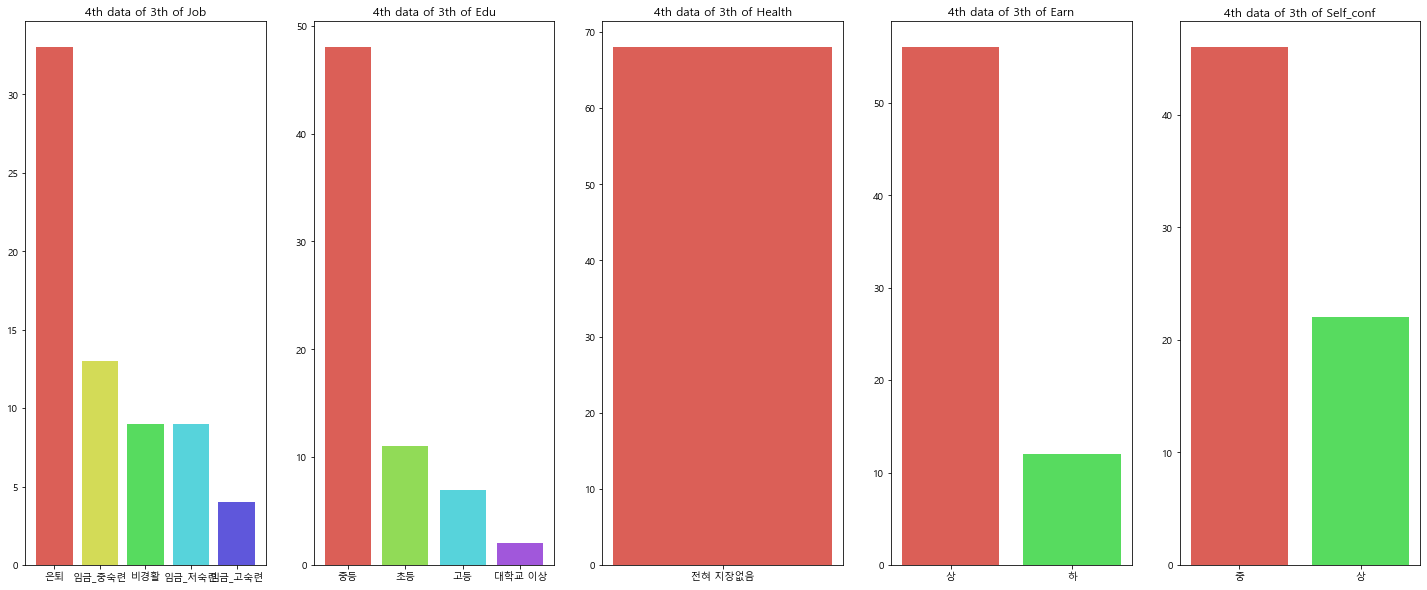

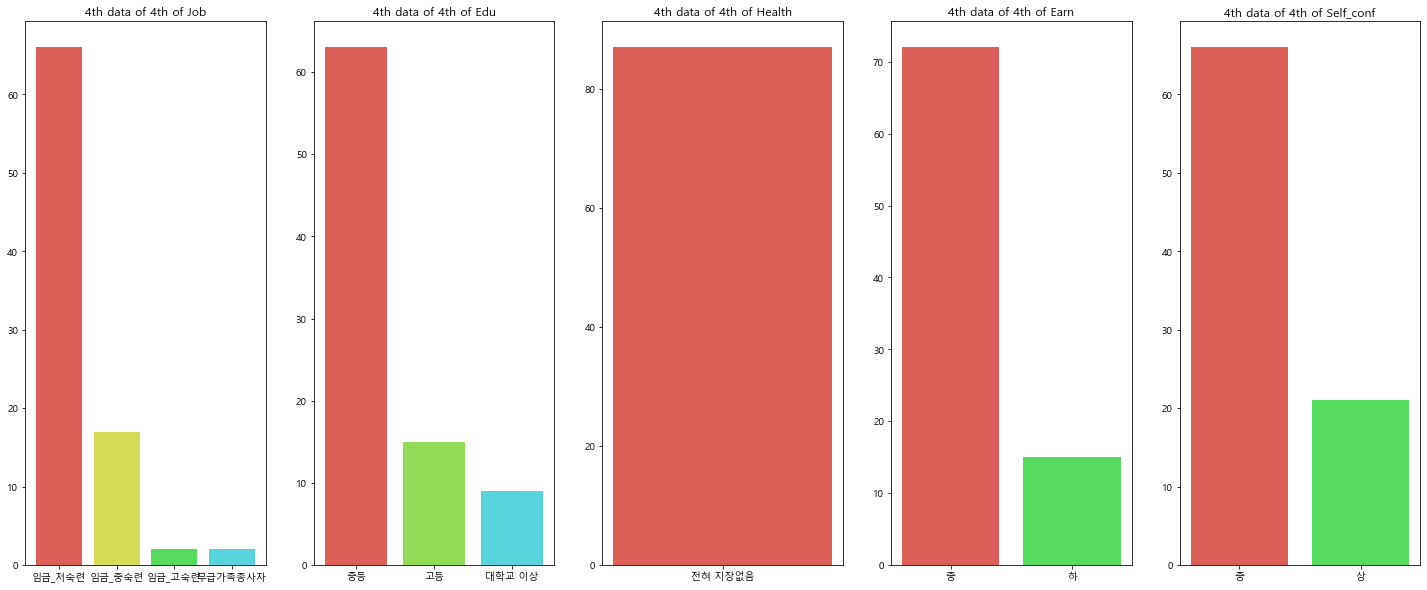

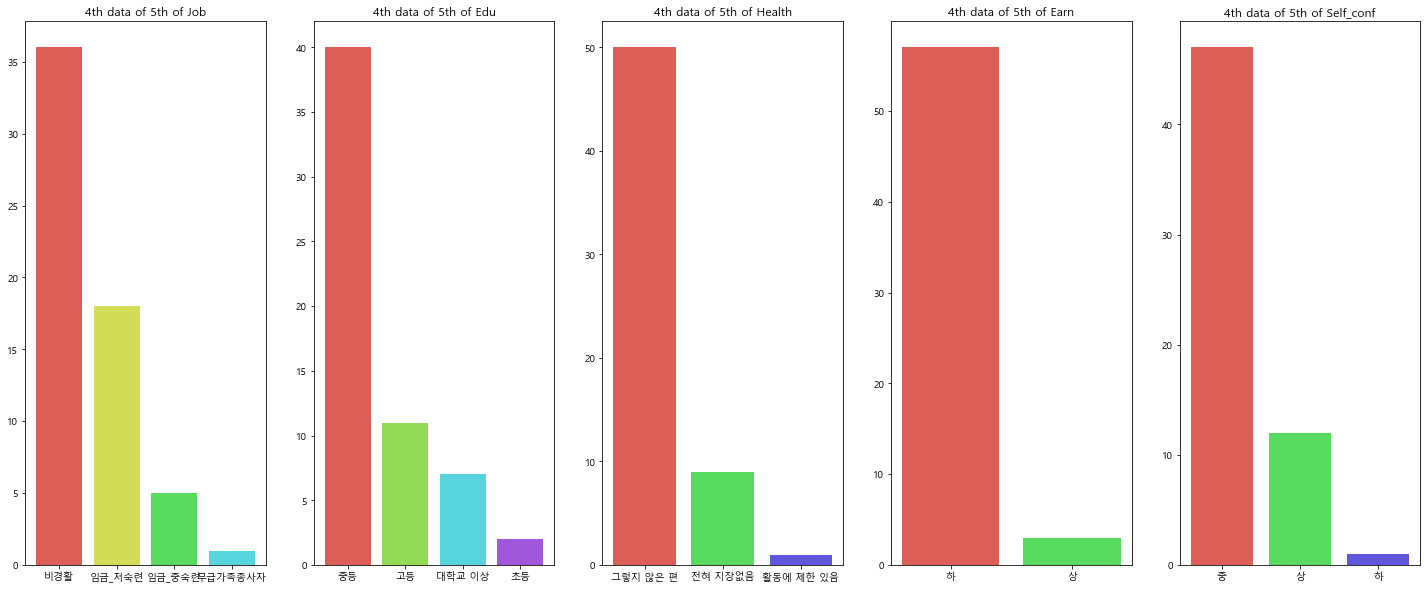

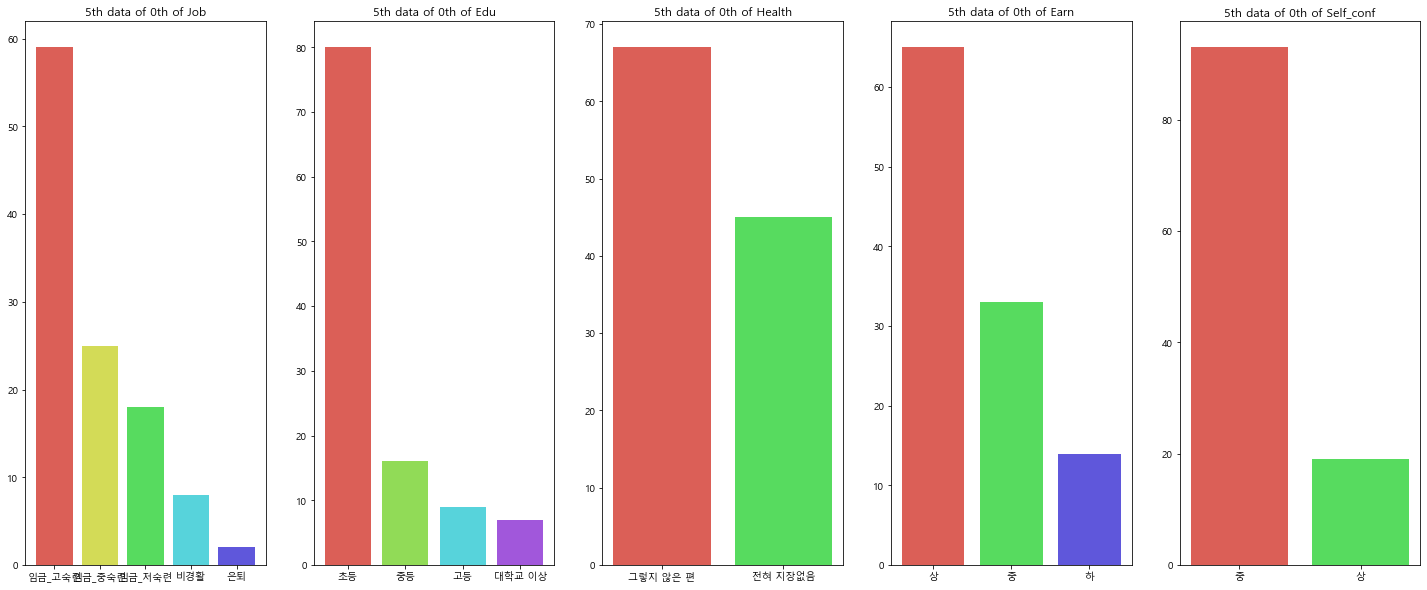

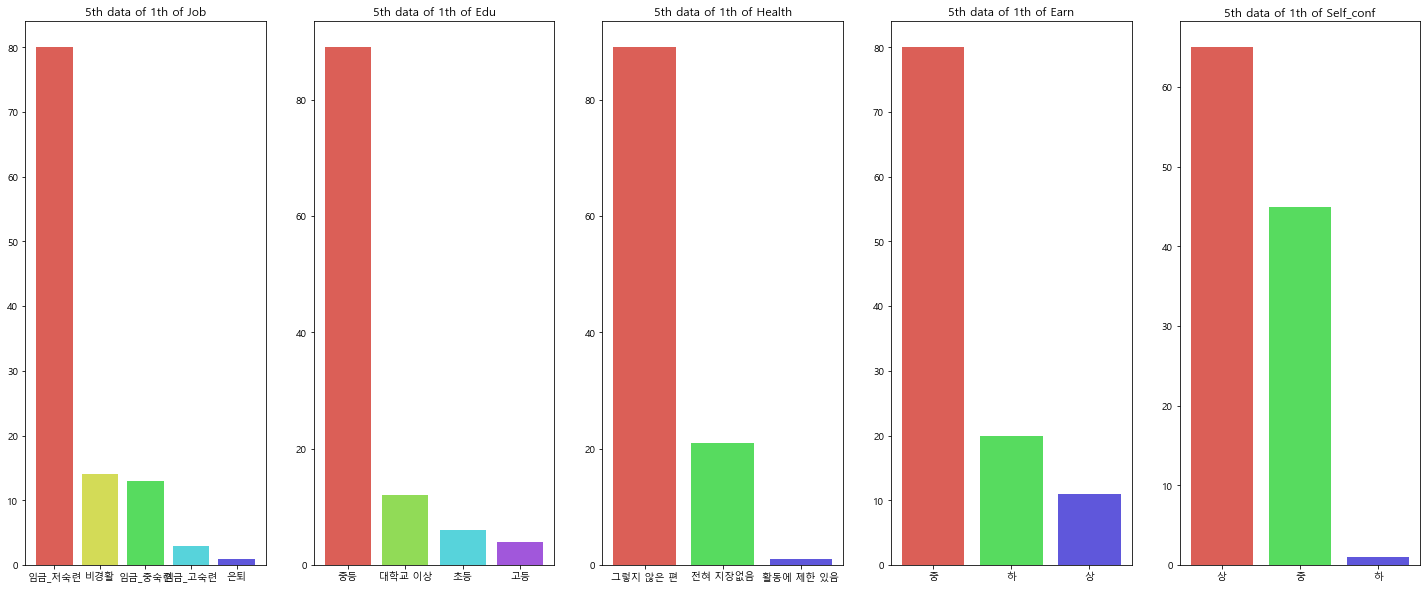

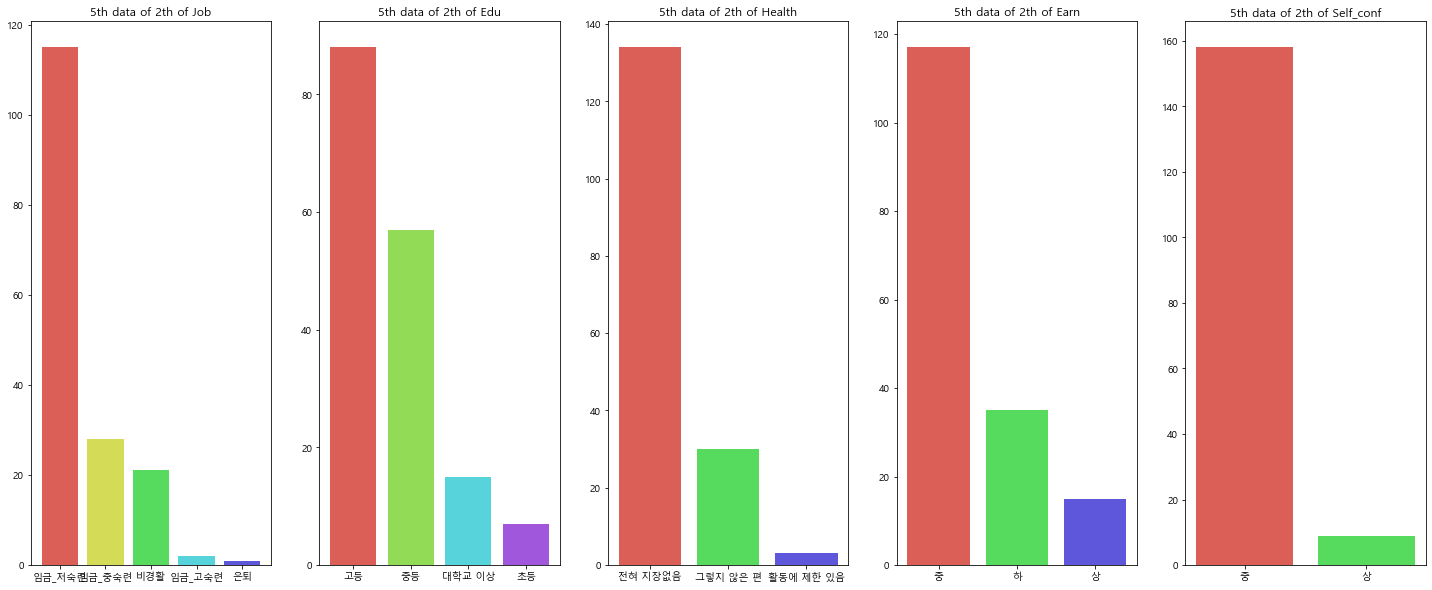

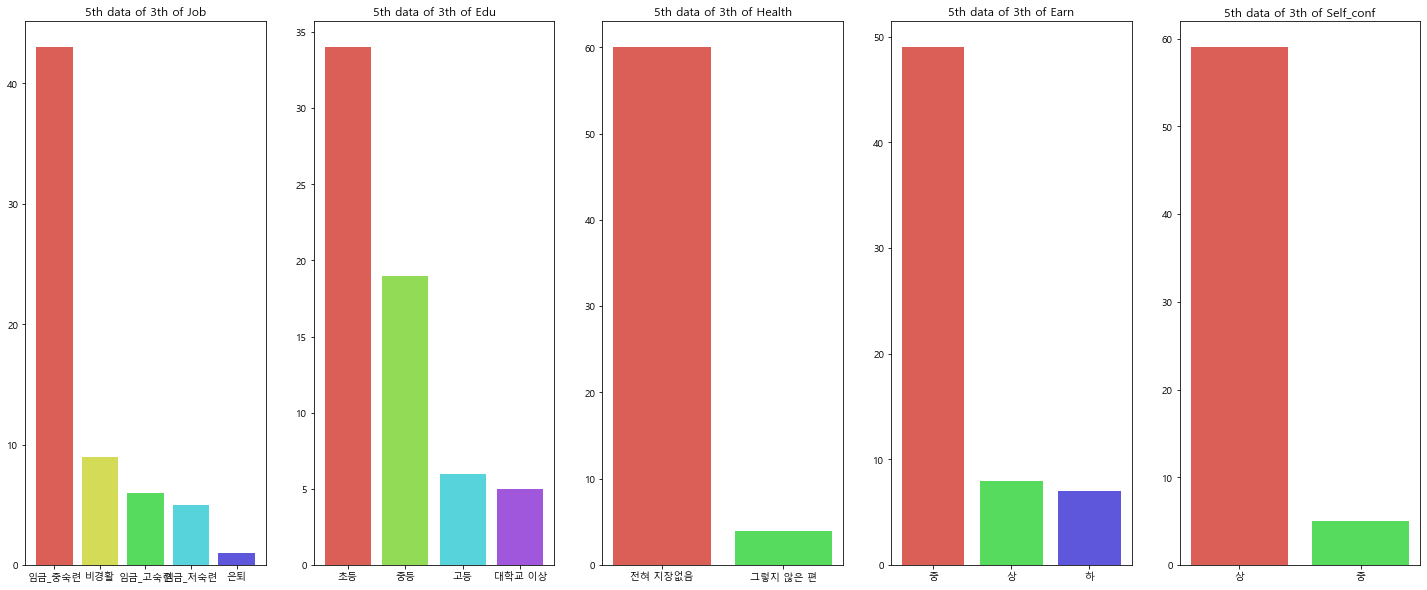

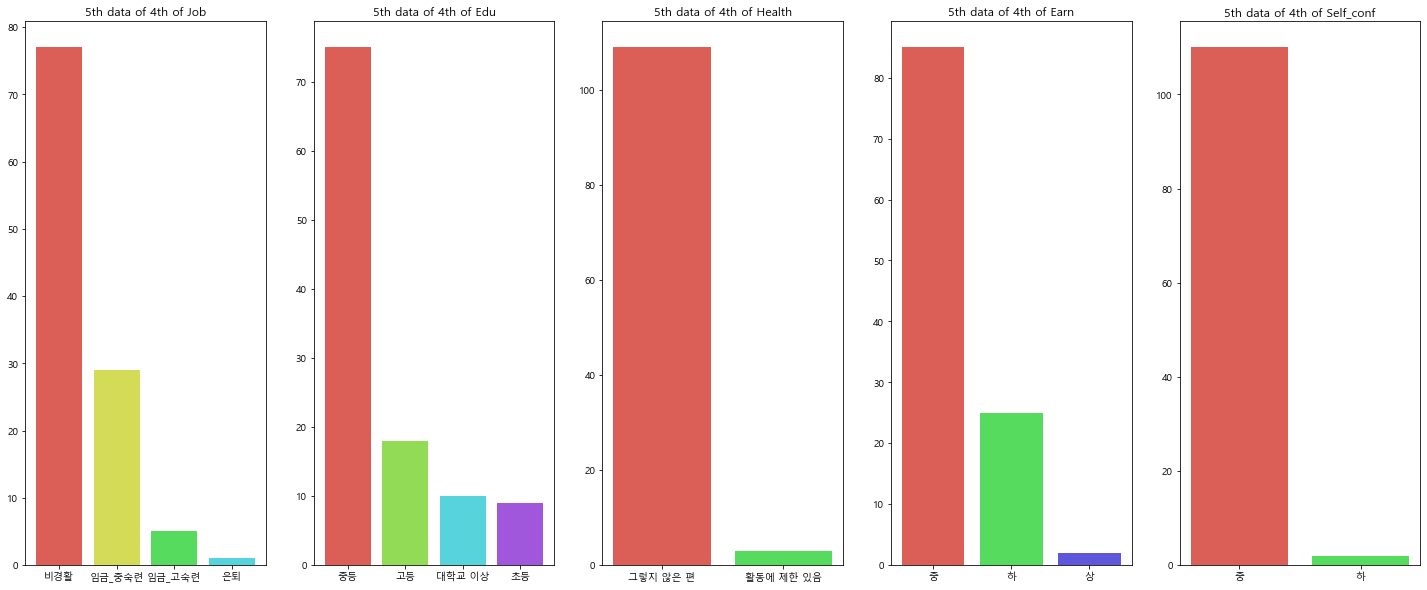

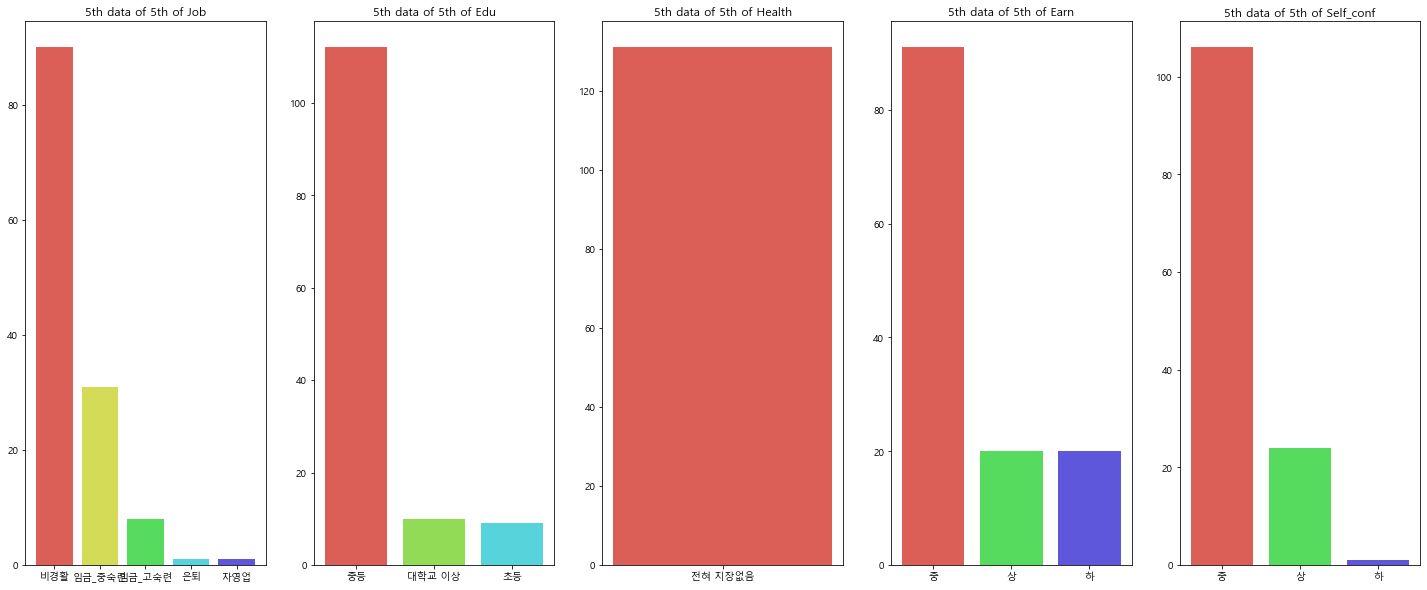

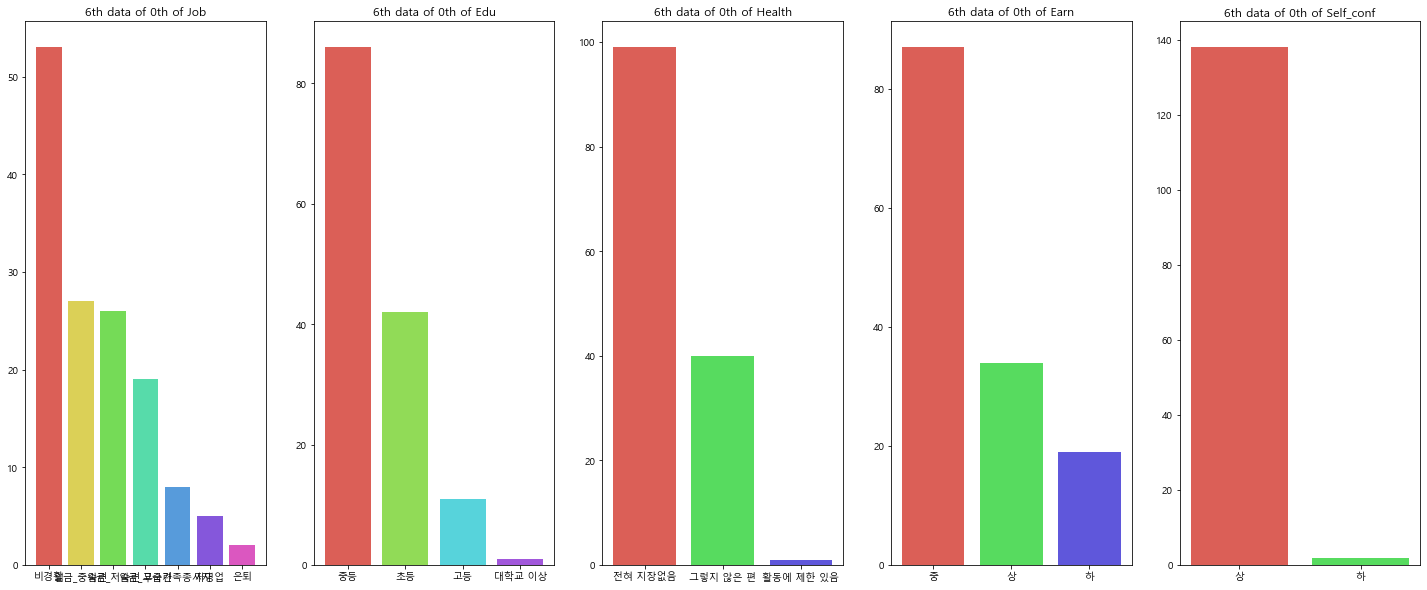

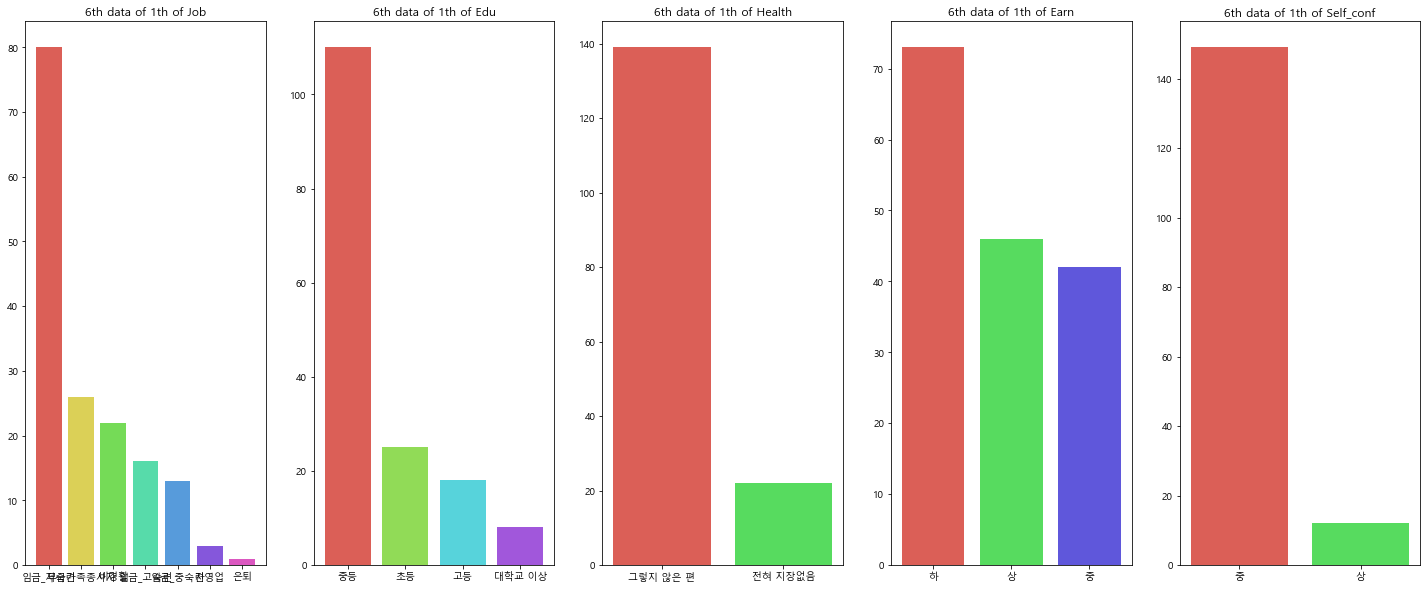

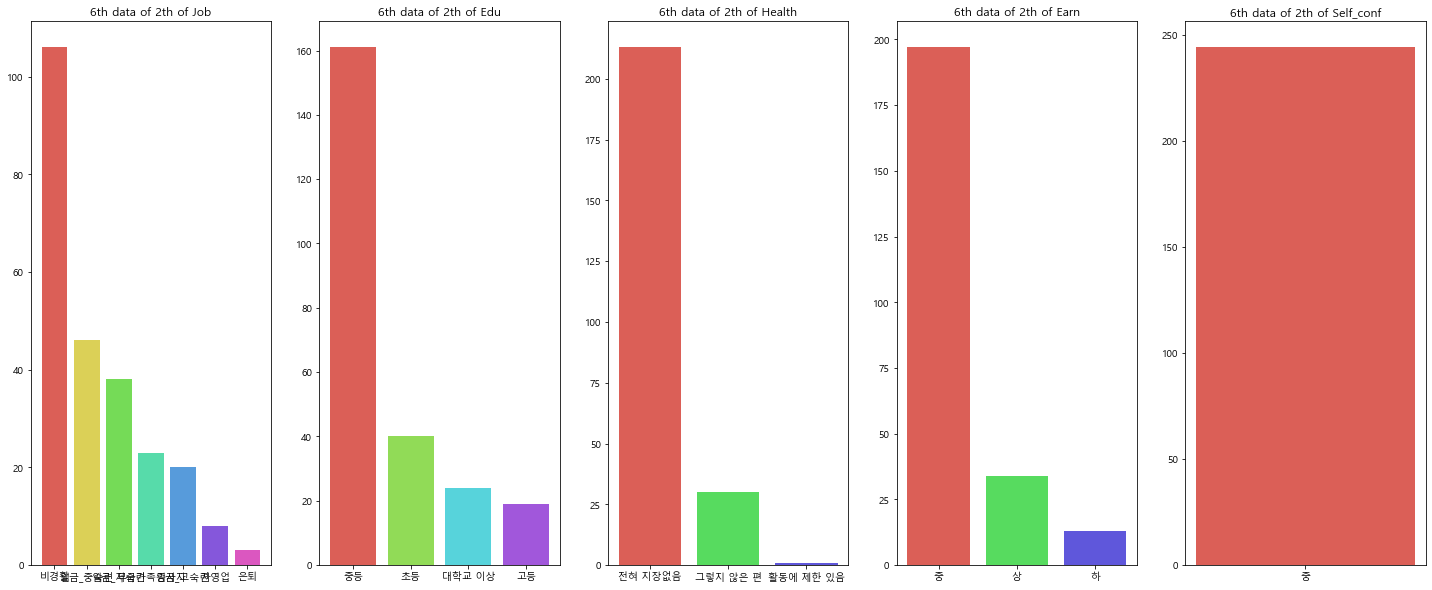

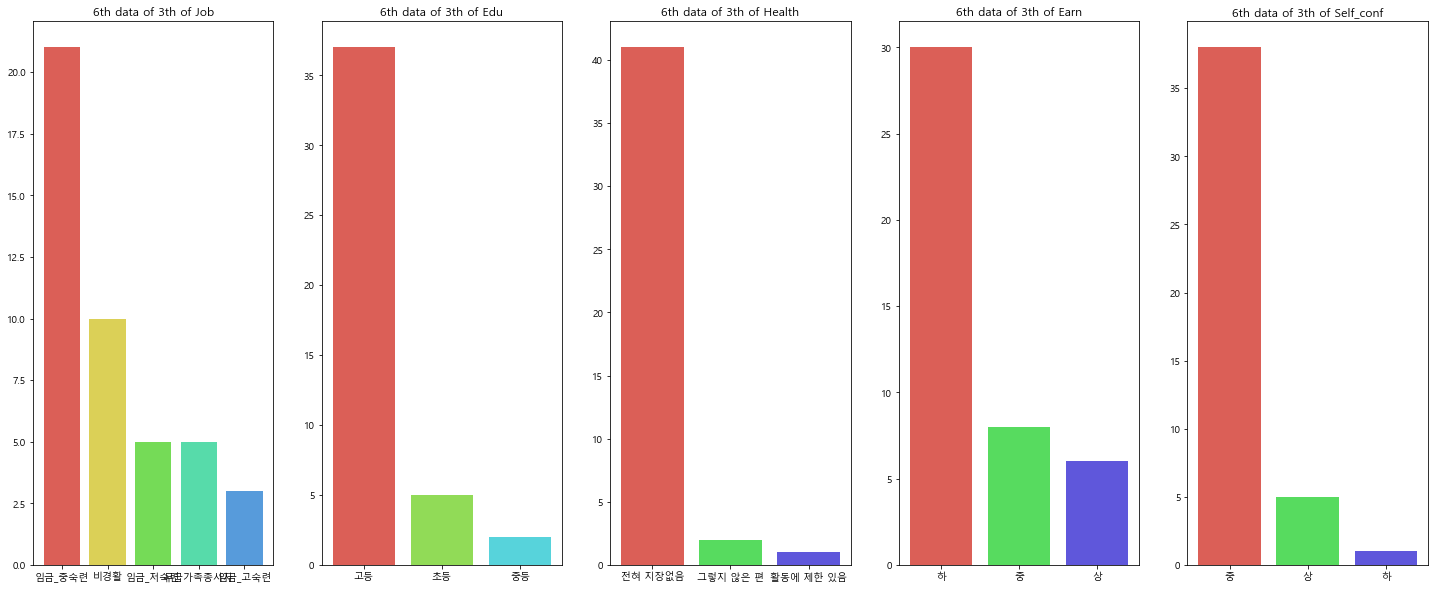

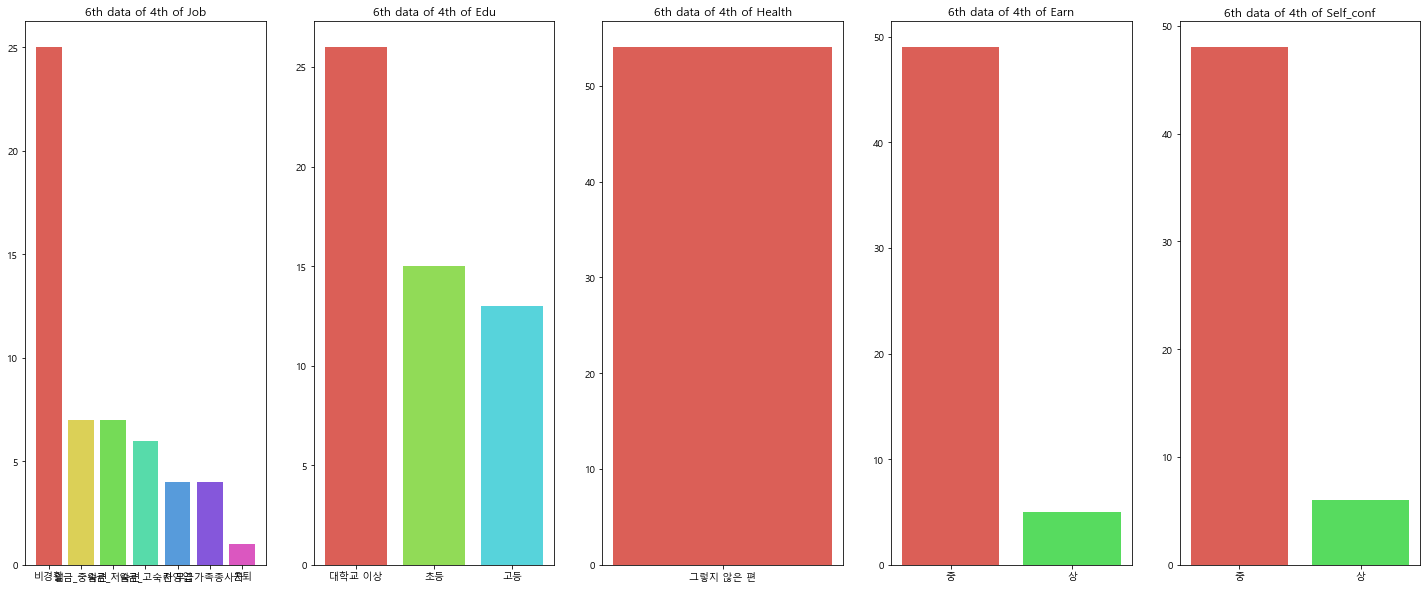

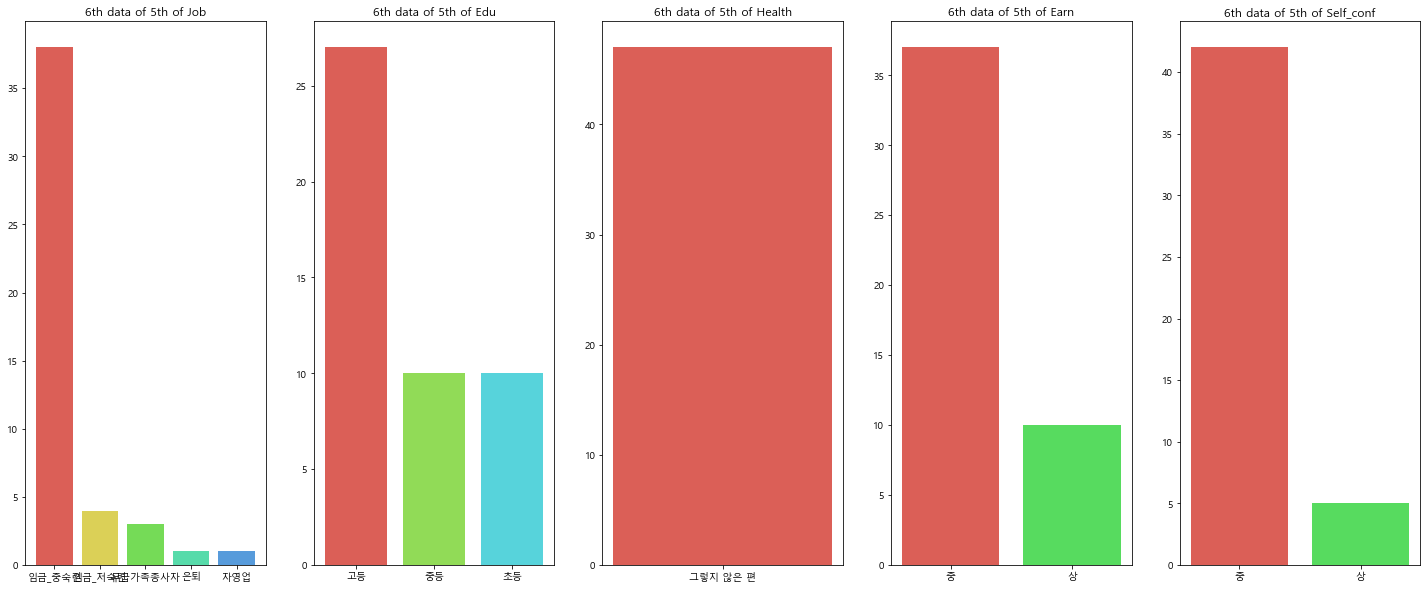

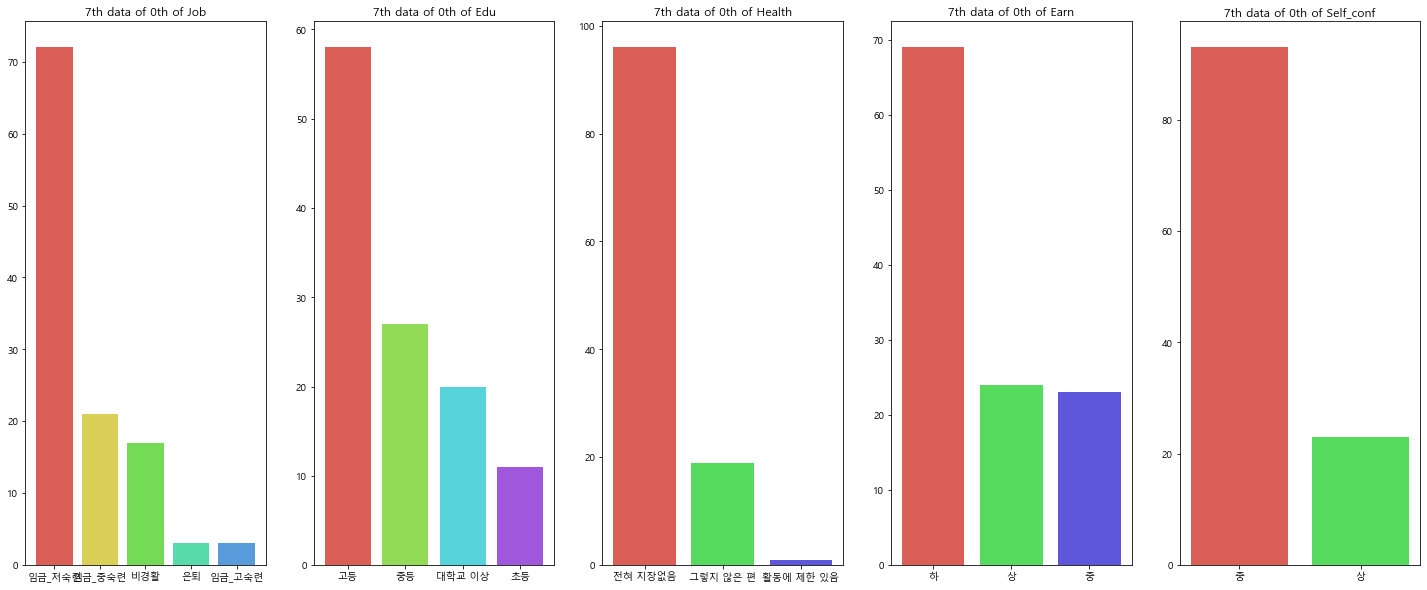

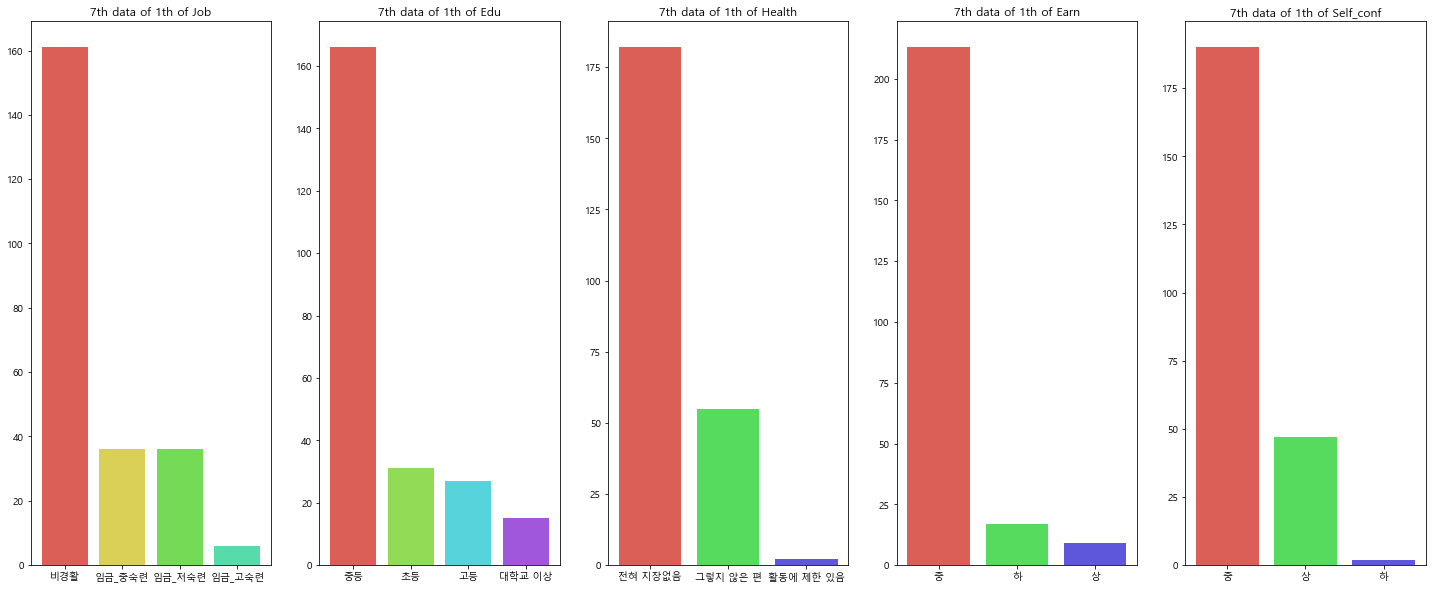

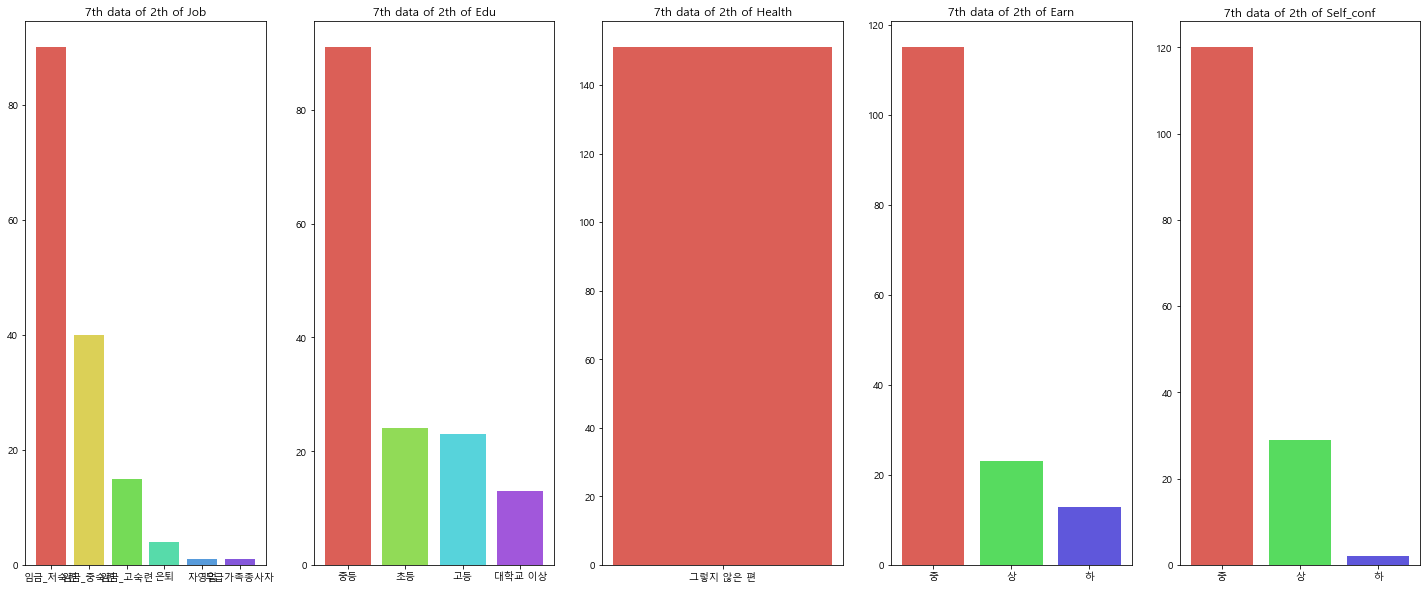

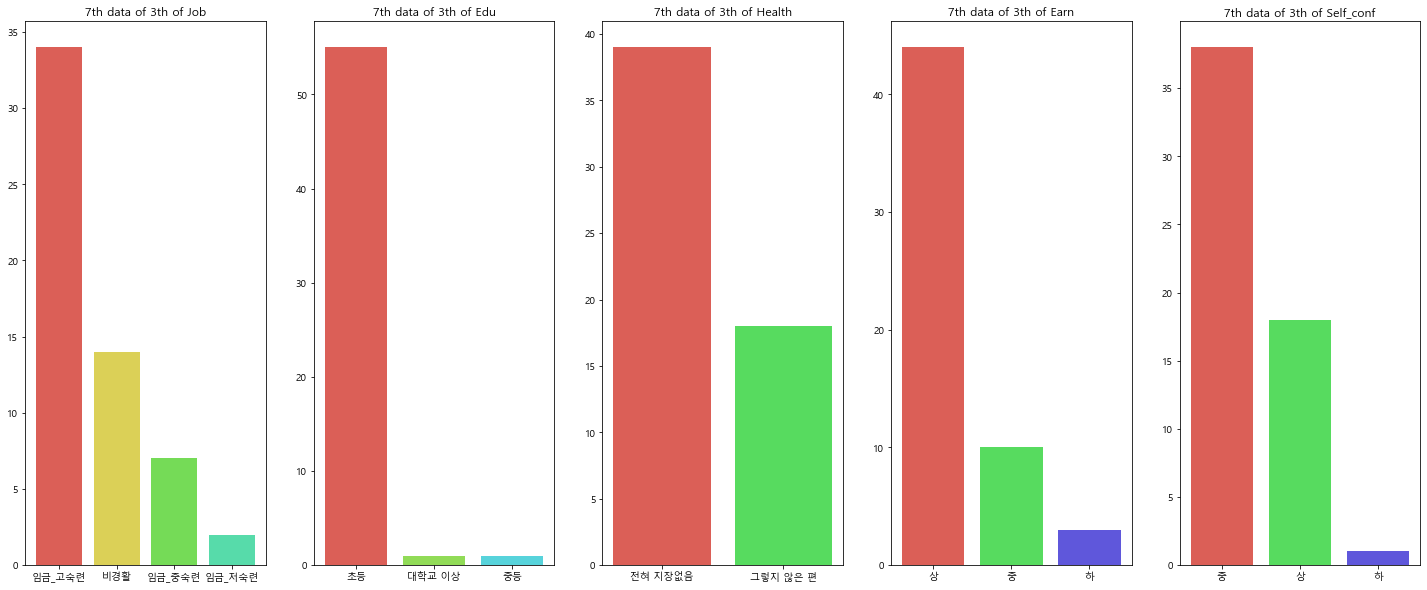

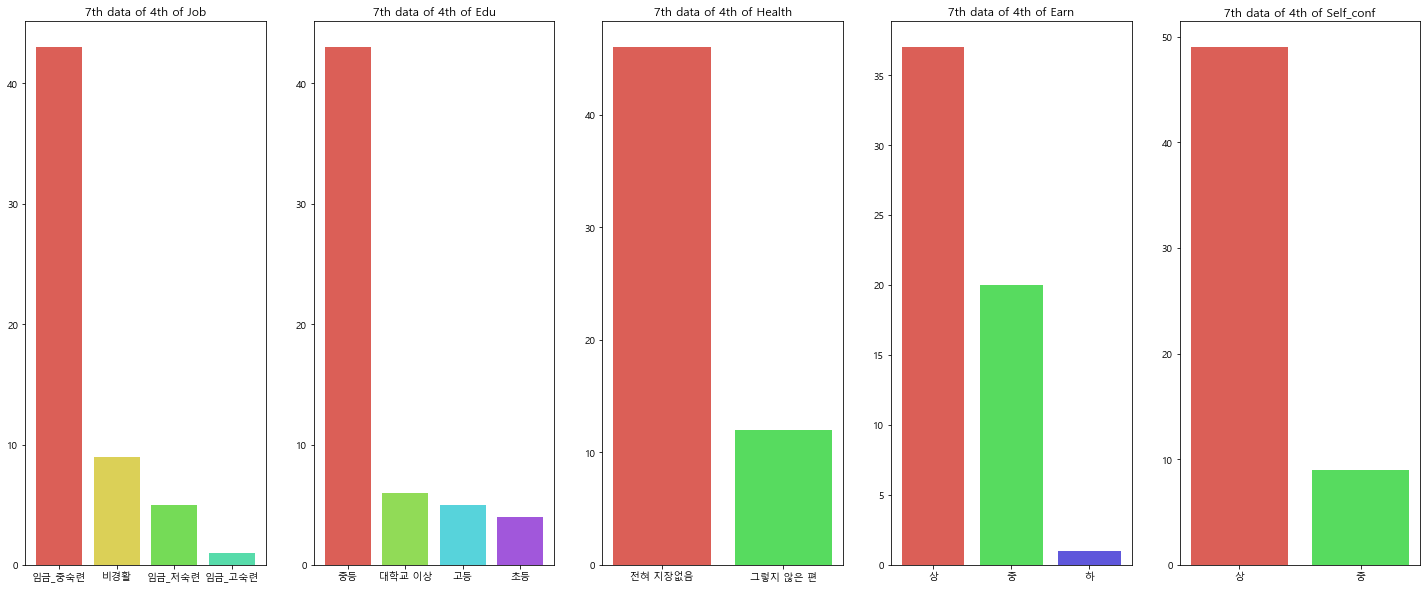

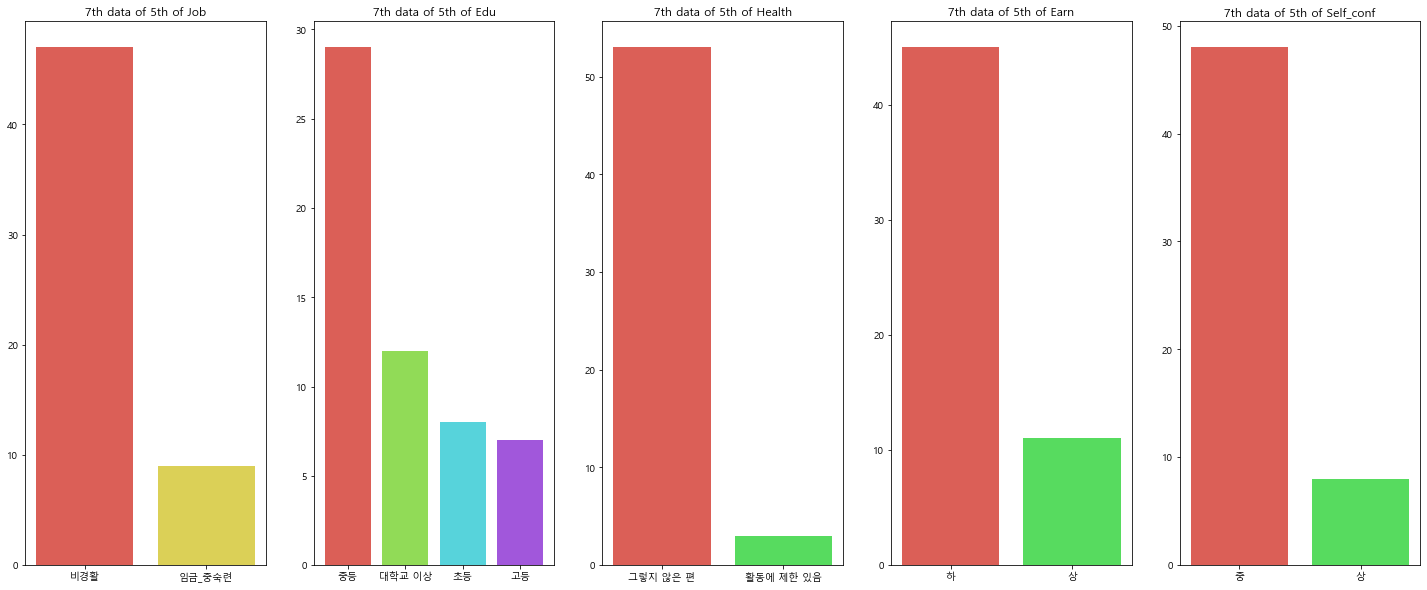

In [203]:
for idx, data in enumerate(data_lst):
    for clus in range(0, 6):
        plt.figure(figsize=(25, 10))
        n = 1 
        for i, col in enumerate(cols[1:]):
            ax = plt.subplot(1, 5, n)
            colors = sns.color_palette('hls',len(data[col].value_counts()))
            temp = data[data['Cluster'] == clus].drop(['Year', 'Cluster'], axis=1)[col].value_counts()
            ax.bar(x = temp.index, height= temp.values, color = colors, axes= ax)
            plt.title(f'{idx}th data of {clus}th of {col}')
            n += 1
        plt.show()

<BarContainer object of 2 artists>

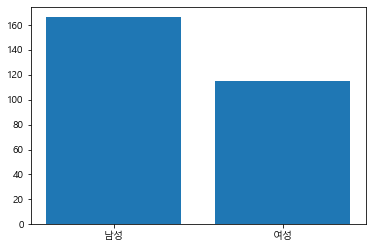

In [196]:
x = data_0[data_0['Cluster'] == 0].drop(['Year', 'Cluster'], axis=1)['Gender'].value_counts().values
plt.bar(x = data_0[data_0['Cluster'] == 0].drop(['Year', 'Cluster'], axis=1)['Gender'].value_counts().index,height = x)


In [184]:
cols

['Gender', 'Job', 'Edu', 'Health', 'Earn', 'Self_conf']